# **Libraries**

In [ ]:
!pip install ucimlrepo==0.0.7
!pip install dcor==0.6
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2
!pip install xgboost==2.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.5 MB/s eta 0:00:00
Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 106.2 MB/s eta 0:00:00


In [ ]:
# Importing Libraries

## Data import
from ucimlrepo import fetch_ucirepo

## Data manipulation
import numpy as np
import pandas as pd

## Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    MinMaxScaler,
  )
from dcor import distance_correlation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


## Validation and Hyperparameter tuning
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split
  )


## Models
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    ExtraTreesClassifier,
    ExtraTreesRegressor
  )
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance


## Performance metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
  )

## Scipy functions
from scipy.stats import randint

## Othe imports
import time
import datetime
import warnings
from os import rename
from google.colab import files
# Ignore the UndefinedMetricWarning
warnings.filterwarnings("ignore")
RANDOM_STATE=2025

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Base functions**

**Load data**

In [ ]:
def load_data_from_ucimlrepo(repo_id, variable_rename_dict=None):
  # fetch dataset
  dataset = fetch_ucirepo(id=repo_id)

  # metadata
  print(dataset.metadata)

  # variable information
  print(dataset.variables)
  variables_df = dataset.variables
  variables_df['name'] = variables_df['name'].str.lstrip()

  # data (as pandas dataframes)
  df = dataset.data.features

  # Rename columns using the dictionary
  if variable_rename_dict:
    df = df.rename(columns=variable_rename_dict)
    variables_df['name'] = variables_df['name'].map(variable_rename_dict)

  df['Target'] = dataset.data.targets

  # Remove spaces at the beginning of each column name
  df.columns = df.columns.str.lstrip()
  return df, variables_df

**Variable encoding**

In [ ]:
def encode_binary_variables(df, binary_cols, binary_values):
  for col in binary_cols:
      df[col] = df[col].map(binary_values)
  return df

def one_hot_encoding(df, categorical_cols, encoder=None):
  """
  Performs one-hot encoding on specified categorical columns.

  Args:
      df: The input DataFrame.
      categorical_cols: A list of categorical columns to encode
      encoder: if mode 'test', receives here the scaler object to be used

  Returns:
      A DataFrame with the categorical columns one-hot encoded.
  """
  # Initialize encoder
  if encoder is None:  # train mode
    encoder = OneHotEncoder(
        drop='first', sparse_output=False, handle_unknown='ignore'
    )
    # Fit and transform training data
    encoded_df = encoder.fit_transform(df[categorical_cols])
  else:  # test mode
    # Transform test data using same encoding
    encoded_df = encoder.transform(df[categorical_cols])

  # Convert to DataFrame with proper column names
  feature_names = encoder.get_feature_names_out(categorical_cols)
  encoded_df = pd.DataFrame(encoded_df, columns=feature_names, index=df.index)

  non_categorical_cols = [col for col in df.columns if col not in categorical_cols]
  final_df = pd.concat([df[non_categorical_cols], encoded_df], axis=1)
  return final_df, encoder


def map_encoded_variables_to_original(encoded_vars, categorical_vars):
  """
  Creates a dictionary that maps each one-hot encoded variable to its
  original categorical variable.

  Args:
      encoded_vars: A list of one-hot encoded variable names.
      categorical_vars: A list of original categorical variable names.

  Returns:
      A dictionary with one-hot encoded variables as keys and original
      categorical variables as values.
  """
  # dictionary to store the mapping
  one_hot_mapping = {}

  # Iterate through original categorical variables
  for cvar in categorical_vars:
      # Get the one-hot encoded columns derived from this original column
      encoded_cols = [c for c in encoded_vars if c.startswith(cvar + "_")]
      # Map encoded columns to the original column
      for evar in encoded_cols:
          one_hot_mapping[evar] = cvar
  return one_hot_mapping

**Feature scaling:**

- In use for SVM and LR algorithms.
- MinMax Scaler chosen due to maintaining binary/ohe variables original values, meanwhile numerical variables get a similar domain of variation. This choice keeps the full interpretability of binary/ohe variables.

In [ ]:
def scale_minmax_features(df, mode, scaler = None):
  """
  Scale features to range [0,1] using MinMaxScaler

  Args:
      df: dataframe with the features to be scaled
      mode: 'train' or 'test'
      scaler: if mode 'test', receives here the scaler object to be used

  Returns:
      df_scaled: scaled features
      scaler: fitted scaler object
  """
  if mode == 'train':
      # Initialize the scaler
    scaler = MinMaxScaler()
    # Fit on training data and transform it
    df_scaled = scaler.fit_transform(df)
  else:
    # Transform test data using the fitted scaler
    df_scaled = scaler.transform(df)

  # Convert back to DataFrames with original column names
  df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

  return df_scaled, scaler

**Data summary and quality**

In [ ]:
def describe_data(df):
  # Dimension
  print("\nData dimension :")
  print("Number of Records : ",df.shape[0],"\nNumber of Features : ", df.shape[1])

  # Datatype of columns
  print("\nDatatype of Features :")
  print(df.dtypes.value_counts())

  # Missing values
  print("\nMissing values :")
  na_value_check = df.isna().sum()
  if len(na_value_check[na_value_check > 0]) == 0 :
      print("Missing values not identified")
  else :
      print(na_value_check[na_value_check > 0])

  # Duplicated records check
  print("\nDuplicated records :")
  duplicate_rows = df.duplicated()
  if len(df[duplicate_rows]) == 0:
      print("Duplicated records not identified")
  else :
      print("Number of duplicated records :",len(df[duplicate_rows]))

  # data summary
  print("\nData summary :")
  print(df.describe())

**Correlation**

In [ ]:
def non_numeric_variables(df, exclude_types):
  # Filter out variables that are not mumeric
  non_numeric_variables = df.select_dtypes(exclude=exclude_types)
  return non_numeric_variables.columns.tolist()

def create_heatmap(matrix, title, center=0, mask=None):
  # Create a heatmap from the matrix provided as input
  f, ax = plt.subplots(figsize=(11, 9))
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  sns.heatmap(matrix, cmap=cmap, center=center,
              mask=mask, linewidths=.5,
              cbar_kws={"shrink": .5})
  plt.title(title)
  plt.show()

def calculate_correlation(df, corr_method, features='all'):
  # Compute the correlation matrix
  if features == "all":
    corr = df.corr(method=corr_method)
  else :
    corr = df[features].corr()

  # Create a mask to hide the upper triangle of the correlation matrix
  mask = np.triu(np.ones_like(corr, dtype=bool))

  # Generate a heatmap with the correlation matrix
  create_heatmap(corr, title="Correlation matrix", mask=mask)
  return corr

In [ ]:
def calculate_distance_correlation_matrix(df, features='all', debug=False):
    """
    Calculates the distance correlation matrix for a given DataFrame.

    Args:
      df: the input DataFrame
      features: 'all' or a list of the features to be considered
      debug: True / False to control the printing of additional information

    Returns:
      A distance correlation matrix as a pandas DataFrame.
      Produces a heatmap for the distance correlation matrix.
    """

    # Select features
    if features == "all":
        selected_df = df
    else:
        selected_df = df[features]

    print('df columns: ', selected_df.columns)

    # Convert all int64 columns in float64 to avoid errors
    int64_cols = selected_df.select_dtypes(include=['int64']).columns
    selected_df[int64_cols] = df[int64_cols].astype('float64')

    # Initialize distance correlation matrix
    n_features = len(selected_df.columns)
    print('num_features: ', n_features)
    dcor_matrix = pd.DataFrame(
        np.zeros((n_features, n_features)),
        index=selected_df.columns,
        columns=selected_df.columns
    )

    # Calculate distance correlation for each pair
    for i, col1 in enumerate(selected_df.columns):
        if debug: print('col1: ', col1)
        for j, col2 in enumerate(selected_df.columns):
            if debug: print('----- col2: ', col2)
            if i <= j:  # Only calculate upper triangle
                # Convert categorical variables to numeric
                x = pd.Categorical(selected_df[col1]).codes if selected_df[col1].dtype == 'object' else selected_df[col1]
                y = pd.Categorical(selected_df[col2]).codes if selected_df[col2].dtype == 'object' else selected_df[col2]

                # Calculate distance correlation
                dcor = distance_correlation(x, y, method='mergesort')

                dcor_matrix.iloc[i, j] = dcor
                dcor_matrix.iloc[j, i] = dcor  # Matrix is symmetric

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(dcor_matrix, dtype=bool))
    # Create heatmap
    create_heatmap(dcor_matrix, title="Distance Correlation Matrix", mask=mask)
    return dcor_matrix

In [ ]:
def plot_dcor_histogram(dcor_df):
    """
    Reads a distance correlation (dcor) DataFrame and produces a histogram
    of the distance correlations, displaying percentages on the y-axis.
    Also prints the percentage of correlations below different thresholds.

    Args:
    dcor_df : pandas.DataFrame
        The distance correlation matrix as a pandas DataFrame.

    Returns:
    Histogram plot of the correlations.
    """

    # Flatten the matrix and exclude diagonal elements for histogram
    flattened_dcor = dcor_df.where(~np.eye(dcor_df.shape[0], dcor_df.shape[1], dtype=bool)).stack()

    # Create histogram with 10 equally spaced bins from 0 to 1.0
    bins = np.linspace(0, 1.0, 11)  # Creates 10 bins with edges at 0, 0.1, 0.2, ..., 1.0
    plt.figure(figsize=(8, 6))
    n, bins, patches = plt.hist(flattened_dcor, bins=bins, color='blue', alpha=0.7, edgecolor='black')

    # Convert counts to percentages of total
    total_count = flattened_dcor.count()
    percentage_heights = (n / total_count) * 100  # Multiply by 100 for actual percentage values

    # Set y-axis labels to percentages
    for i in range(len(patches)):
        patches[i].set_height(percentage_heights[i])  # Update patch height
        plt.text(patches[i].get_x() + patches[i].get_width() / 2,
                 percentage_heights[i] + 0.5,  # Add 0.5 for better spacing
                 f'{percentage_heights[i]:.2f}%',  # Display percentage with 2 decimal places
                 ha='center', va='bottom')

    plt.title('Histogram of Distance Correlations (% of Total)')
    plt.xlabel('Distance Correlation')
    plt.ylabel('% of Total Correlations')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(percentage_heights) + 5)  # Set y-axis limits slightly above max percentage
    plt.show()

    # Calculate and print percentage of correlations below different thresholds
    for i in np.arange(0.1, 1.1, 0.1):  # From 0.1 to 1.0 in steps of 0.1
        percentage_below = (flattened_dcor[flattened_dcor <= i].count() / total_count) * 100
        print(f"Percentage of correlations below {i:.1f}: {percentage_below:.2f}%")

**Pre-feature selection**

In [ ]:
def identify_zero_variance_columns(df):
  # Calculate the variance of each column
  variances = df.var()
  print("Variance of each column:")
  print(variances)

  # Identify columns with zero variance
  zero_variance_columns = variances[variances <= 1.00e-10].index.tolist()
  print("Columns with zero variance to be dropped:")
  print(zero_variance_columns)
  return zero_variance_columns


def identify_weak_associated_features(association_matrix, target_variable, threshold=0.1):
  """
  Identifies features with a weak association with the target variable.

  Args:
    association_matrix: usually a correlation matrix as dataframe
    target_variable: The name of the target variable column.
    threshold: value for which correlations below are considered weak

  Returns:
    A list of feature names that have a association with the target variable
    lower than the threshold.
  """
  target_association = association_matrix[target_variable]
  weak_associated_features = target_association[
      abs(target_association) < threshold
  ].index.tolist()
  print("Features with weak association with the target variable:")
  print(weak_associated_features)
  return weak_associated_features


def filter_out_intercorrelated_features(corr_df, target_name, correlation_threshold=0.8):
  """
  Filters highly correlated features based on a distance correlation matrix.

  Args:
      corr_df: Dataframe with the correlation matrix
      target_name: Name of the column with the target
      correlation_threshold: The threshold for correlation above which features
                             are considered highly correlated.

  Returns:
      A list of features after dropping of intercorrelated
  """

  # get a list with the features sorted by correlation with target
  target_correlations = corr_df[target_name].sort_values(ascending=False)
  sorted_correlated_feat_with_target = [feat for feat in target_correlations.index if feat != target_name]

  selected_features = []
  eliminated_features = []

  # Iterate through features, starting with the most correlated to the target
  for feat in sorted_correlated_feat_with_target:
      if feat not in eliminated_features:  # If not already eliminated
          selected_features.append(feat)
          print('appended feature: ', feat)

          # Eliminate other features highly correlated with the current feature
          for other_feat in sorted_correlated_feat_with_target:
              if other_feat != feat and other_feat not in eliminated_features:
                  correlation = corr_df[corr_df.index==feat][other_feat][0]
                  if abs(correlation) > correlation_threshold:
                      eliminated_features.append(other_feat)
                      print('eliminated feature: ', other_feat, correlation)
  return selected_features

**Missing values handling**

**Simple imputation (median and mode):** Missing values will be inputed with the median for numerical variables and with the model for binary/ohe variables. This choice guarantees that the value inputed is a value that makes sense for the domain of each variable and also avoid the influence of outliers or long-tailed distributions.

**Imputation via MissForest:** The missing values are inputed via an ensemble model that makes use of all other features available at the moment. Note that for this use case a new MissForest algorithm has to be run at each scenario, because the features available will change. Otherwise there will be unfair data leakage. The implementation used for MissForest uses ExtraTrees instead of Random Forests in accordance with the suggestion from Scikit Learn as present in: https://scikit-learn.org/0.21/auto_examples/impute/plot_iterative_imputer_variants_comparison.html

Note: In the case of models that require feature scaling (normalization), the simple inputation will be based on the median and mode of features after scaling.

In [ ]:
def calculate_imputation_values_for_missing(df):
  """
  Calculates the median for numeric columns and mode for non-numeric columns in a DataFrame.

  Args:
    df: The pandas DataFrame.

  Returns:
    A dictionary with column names as keys and their median/mode as values.
  """
  imputation_dict = dict()
  for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
      imputation_dict[column] = df[column].median()
    else:
      imputation_dict[column] = df[column].mode()[0] if not df[column].mode().empty else None
  return imputation_dict


def imputation_missforest(train_df, test_df, cat_vars_list=[]):
  """
  Auxiliary function for Performance Decay
  Imputes missing values in the testing datasets using the MissForest algorithm.

  Args:
    train_df / test_df: DataFrame with training/test data
    cat_vars_list: list of categorical variables for imputation

  Returns:
    test_df_imputed: DataFrame with imputed missing values by MissForest
  """
  # check of the nr of columsn with nan
  nan_counts_per_column = test_df.isnull().any()
  num_columns_with_nan = nan_counts_per_column.sum()
  print('Nr. columns with nan: ', num_columns_with_nan)
  columns_with_nulls = test_df.columns[test_df.isnull().any()].tolist()

  # identify categorical and numerical features
  categorical = cat_vars_list
  numerical = [col for col in test_df.columns if col not in categorical and col!='Type']
  print('Numerical columns: ', numerical)
  print('Categorical columns: ', categorical)

  train_df['Type'] = 'Train'
  test_df['Type'] = 'Test'
  df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
  df_imputation = df.drop(columns=['Type'])
  """
  # missforest with random forests

  imp_num = IterativeImputer(estimator=RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)
  """

  # missforest with extra trees (faster and with similar performance)
  imp_num = IterativeImputer(estimator=ExtraTreesRegressor(
                              max_features='sqrt',
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=ExtraTreesClassifier(
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)

  if len(numerical)>0:
    df_imputation[numerical] = imp_num.fit_transform(df_imputation[numerical])

  if len(categorical)>0:
    df_imputation[categorical] = imp_cat.fit_transform(df_imputation[categorical])

  # test_df_imputed and auxiliary info to be displayed along the imputation
  test_df_imputed = df_imputation[df['Type']=='Test']
  for col in columns_with_nulls:
    print('Column imputed: ', col)
    if col in numerical:
      print('Mean: ', test_df_imputed[col].mean())
      print('Std deviation: ', test_df_imputed[col].std())
    else:
      print(test_df_imputed[col].value_counts())
  return test_df_imputed

**Model training / Feature permutation importance / Hyperparameter optimization**

In [ ]:
def apply_model(model, X_train, y_train, X_test, y_test):
  # Fit the model
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  return model, y_train_pred, y_test_pred


def analyze_feat_permut_import(
    model, X, y, scoring_metric, n_repeats=5, random_state=RANDOM_STATE
):
    # Calculate permutation importance
    result = permutation_importance(
        model, X, y, scoring=scoring_metric, n_repeats=n_repeats,
        random_state=random_state, n_jobs=-1
    )

    # Create DataFrame with results
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result.importances_mean,
        'Std': result.importances_std
    }).sort_values(by='Importance', ascending=True)

    return importance_df.sort_values(by='Importance', ascending=False)


def plot_feat_permut_importance(feat_imp_df, threshold=0, k=20):
  # Filter features with importance above the threshold
  feat_imp_plot = feat_imp_df[feat_imp_df['Importance'] > threshold]
  feat_imp_plot = feat_imp_plot.sort_values(by='Importance', ascending=False)

  # select the top k features
  if len(feat_imp_plot) > k:
    feat_imp_plot = feat_imp_plot.head(k)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feat_imp_plot['Feature'], feat_imp_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Permutation Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()


def plot_feature_importance(model, importance_threshold, col_names):
  if model.__class__.__name__ == 'LGBMClassifier':
    feature_importances = model.booster_.feature_importance(importance_type='split')
  else:
    feature_importances = model.feature_importances_

  # Create a DataFrame with feature names and importances
  feature_importance_df = pd.DataFrame({'Feature': col_names, 'Importance': feature_importances})

  # Sort features by importance in descending order
  feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

  # Filter features with importance above the threshold
  feature_importance_plot = feature_importance_df[feature_importance_df['Importance'] >= importance_threshold]
  if len(feature_importance_plot) > 20:
    feature_importance_plot = feature_importance_plot.head(20)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feature_importance_plot['Feature'], feature_importance_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()
  return feature_importance_df


def hyperparameter_tuning(model, param_grid, k_hyp_par, k_cv, scoring_metric, X, y):
    """
    Performs hyperparameter tuning using nested cross-validation.

    Args:
        model: The base model to be tuned.
        param_grid: A dictionary containing the hyperparameter grid.
        k_hyp_par: The number of folds for the inner cross-validation.
        k_cv: The number of folds for the outer cross-validation.
        scoring_metric: The scoring metric to be used for evaluation.
        X: The feature matrix.
        y: The target variable.

    Returns:
        A tuple containing the fitted GridSearchCV object, nested scores, and best parameters.
    """
    # Time control
    start_time = time.time()
    print(f"Starting hyperparameter tuning at: {datetime.datetime.now()}")

    # Cross-validation strategies for inner and outer loops
    cv_inner = StratifiedKFold(n_splits=k_hyp_par, shuffle=True, random_state=RANDOM_STATE)
    cv_outer = StratifiedKFold(n_splits=k_cv, shuffle=True, random_state=RANDOM_STATE)

    # Hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_inner,
        scoring=scoring_metric,
        verbose=3,
        n_jobs=-1,
        return_train_score=True,  # To help diagnose overfitting/underfitting
        refit=True
    )

    # Perform nested cross-validation
    nested_scores = cross_val_score(
        grid_search,
        X=X,
        y=y,
        cv=cv_outer,
        scoring=scoring_metric,
        n_jobs=-1
    )

    # Print cross-validation results
    print("\nNested Cross-validation Results:")
    print(f"Individual scores: {nested_scores}")
    print(f"Average nested CV score: {nested_scores.mean():.3f} (+/- {nested_scores.std() * 2:.3f})")

    # Fit the model on the entire dataset
    print("\nFitting final model on entire dataset...")
    grid_search.fit(X, y)

    # Get best parameters and scores
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")
    cv_results = pd.DataFrame(grid_search.cv_results_)

    print("\nBest Model Performance:")
    print(f"Best CV score: {grid_search.best_score_:.3f}")

    # Print execution time
    print(datetime.datetime.now())
    end_time = time.time()
    execution_time = (end_time - start_time) / 60
    print(f"\nExecution time: {execution_time:.2f} minutes")

    return grid_search, best_model, best_params

**Performance**

In [ ]:
# Calculation of performance metrics
def perf_metrics(y_true, y_pred_binary):
    """
    Returns a dictionary with the values of the main metrics
    """
    # Calculate Specificity using confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    specificity = tn / (tn + fp)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary,average='binary')
    recall = recall_score(y_true, y_pred_binary,average='binary')
    f1 = f1_score(y_true, y_pred_binary,average='binary')

    # Create dictionary to store metrics
    metrics_dict = {
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'precision': round(precision*100,2),
        'recall': round(recall*100,2),
        'specificity': round(specificity*100,2),
        'accuracy': round(accuracy*100,2),
        'f1_score': round(f1*100,2),
        'balanced_accuracy' : round(balanced_accuracy*100,2)
    }

    return metrics_dict


def measure_performance_decline(
  X_train, X_test, y_test, model, feat_importance_df, imputation_dict=None, num_feat=25,
  method='simple', encoded_vars_family=None, categorical_vars=[], log_info=False
):
  """
  Simulates the feature disruption events by decreasing order of feature
  permutation importance and imputs missing values in accordance with the method
  chosen. In the case of ohe features, it disrupts simultaneously all ohe
  features generated from the same original feature.
  Re-evaluated the performance of the model in the imputed test set.

  Args:
    imputation_dict: mandatory if nethod='simple', and for each feature (key)
                     has the value to be imputed (median / mode)
    num_feat: max number of original features to be disrupted
    method: imputation method 'simple' or 'missforest'
    encoded_vars_family: dict with ohe features (keys) and their original
                         features (values)

  Returns:
    Dataframe with performance metrics evolution for each disruption event
  """

  # validation of the inputs
  if method not in ['simple', 'missforest']:
    raise ValueError("method must be 'simple' or 'missforest'")

  # if method == 'simple' then inputation_dict must be provided
  if method == 'simple' and imputation_dict is None:
    raise ValueError("imputation_dict must be provided for method 'simple'")

  # list of features ordered by feature importance
  feat_importance_df = (
      feat_importance_df.sort_values('Importance', ascending=False)
  )
  features_importance_list = feat_importance_df['Feature'].to_list()

  # to not affect X_train and X_test outside of the function
  # X_train will be only used in MissForest
  X_train_new = X_train.copy()
  X_test_new = X_test.copy()
  test_pred = model.predict(X_test_new)

  df_perf = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
  df_perf['num_feat_missing'] = [0]
  df_perf['imputed'] = ['']

  removed = list()  # store all the features (includes the ohe)
  original_removed = list()  # store only the original features removed
  i=0
  while len(original_removed)<num_feat and i <= len(features_importance_list):
    print('')
    print('--- NEW ITERATION ---')
    if features_importance_list[i] in removed:
      i = i+1
      continue
    current_feature = features_importance_list[i]
    print("Removing feature: ", current_feature)
    if encoded_vars_family is not None:
      # all the ohe variables derived from the original category should be set to missing
      if current_feature in encoded_vars_family.keys():
        original_feature = encoded_vars_family[current_feature]
        related_features = [k for k,v in encoded_vars_family.items() if v == original_feature]
        # related features that are still in the model (e.g. logistic regression does not have all feat)
        related_features = [feat for feat in related_features if feat in X_test.columns]
        print("Removing related features: ", related_features)
        removed.extend(related_features)
        original_removed.extend([original_feature])
        for feature in related_features:
          if method == 'simple':
            X_test_new[feature] = imputation_dict[feature]
      else:
        removed.extend([current_feature])
        original_removed.extend([current_feature])
        if method == 'simple':
          X_test_new[current_feature] = imputation_dict[current_feature]
    else:
      removed.extend([current_feature])
      original_removed.extend([current_feature])
      if method == 'simple':
        X_test_new[current_feature] = imputation_dict[current_feature]

    if log_info and method=='simple':
      variances = X_test_new.var(numeric_only=True) # Calculate variance for numerical columns
      variance_df = pd.DataFrame({'feature': variances.index, 'variance': variances.values})
      print("Variance of each column:")
      print(variance_df[variance_df['variance']<1e-10])

    # model predictions with inputed data
    # if missforest, then the nan values must be inputed here before applying the model
    if method == 'missforest':
      for col in removed:
        X_test_new[col] = np.nan
      X_test_new = imputation_missforest(X_train_new, X_test_new, categorical_vars)
    test_pred = model.predict(X_test_new)
    new_row = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
    feat_removed = len(original_removed)
    print('Original feat removed so far: ', original_removed)
    new_row['num_feat_missing'] = feat_removed
    new_row['imputed'] = f'{removed} imputed'
    df_perf = pd.concat([df_perf, new_row], ignore_index=True)
    i=i+1
  return df_perf, original_removed, removed

**Save results**

In [ ]:
def combine_datasets(datasets, source_name, scenario_name, seed):
  """Combines multiple datasets with the same schema into a single DataFrame.

  Args:
    datasets: A dictionary of pandas DataFrames.
    source_name: A string representing the name of the dataset source.
    scenario_name: A string representing the name of the experiment.

  Returns:
    A pandas DataFrame containing all datasets combined, with new columns
    indicating the source dataset and the experiment name.
  """

  combined_df = pd.DataFrame()
  for name, df in datasets.items():
      df['dataset'] = name
      df['source'] = source_name
      df['scenario'] = scenario_name
      df['random_state'] = seed
      if '2' in name:
        df['metric'] = 'balanced accuracy'
      else:
        df['metric'] = 'f1 score'
      combined_df = pd.concat([combined_df, df], ignore_index=True)
  return combined_df

def save_dataset(df, dataset_name):
  df.to_csv(dataset_name, encoding = 'utf-8-sig')
  files.download(dataset_name)

# **Load data**

In [ ]:
variable_rename = {
    'Attribute1': 'Status_of_existing_checking_account',
    'Attribute2': 'Duration',
    'Attribute3': 'Credit_history',
    'Attribute4': 'Purpose',
    'Attribute5': 'Credit_amount',
    'Attribute6': 'Savings_account_bonds',
    'Attribute7': 'Present_employment_since',
    'Attribute8': 'Installment_rate_in_percentage_of_disposable_income',
    'Attribute9': 'Personal_status_and_sex',
    'Attribute10': 'Other_debtors_guarantors',
    'Attribute11': 'Present_residence_since',
    'Attribute12': 'Property',
    'Attribute13': 'Age',
    'Attribute14': 'Other_installment_plans',
    'Attribute15': 'Housing',
    'Attribute16': 'Number_of_existing_credits_at_this_bank',
    'Attribute17': 'Job',
    'Attribute18': 'Number_of_people_being_liable_to_provide_maintenance_for',
    'Attribute19': 'Telephone',
    'Attribute20': 'Foreign_worker',
    'class': 'Target'
}

german_credit, german_variables = load_data_from_ucimlrepo(144, variable_rename_dict=variable_rename)

{'uci_id': 144, 'name': 'Statlog (German Credit Data)', 'repository_url': 'https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data', 'data_url': 'https://archive.ics.uci.edu/static/public/144/data.csv', 'abstract': 'This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1000, 'num_features': 20, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Other', 'Marital Status', 'Age', 'Occupation'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5NC77', 'creators': ['Hans Hofmann'], 'intro_paper': None, 'additional_info': {'summary': 'Two datasets are provided.  the original dataset, in the form provided by

In [ ]:
german_credit.head()

Status_of_existing_checking_account  Duration Credit_history Purpose  \
0                                 A11         6            A34     A43   
1                                 A12        48            A32     A43   
2                                 A14        12            A34     A46   
3                                 A11        42            A32     A42   
4                                 A11        24            A33     A40   

   Credit_amount Savings_account_bonds Present_employment_since  \
0           1169                   A65                      A75   
1           5951                   A61                      A73   
2           2096                   A61                      A74   
3           7882                   A61                      A74   
4           4870                   A61                      A73   

   Installment_rate_in_percentage_of_disposable_income  \
0                                                  4     
1                                                  2     
2                                                  2     
3                                                  2     
4                                                  3     

  Personal_status_and_sex Other_debtors_guarantors  ...  Property Age  \
0                     A93                     A101  ...      A121  67   
1                     A92                     A101  ...      A121  22   
2                     A93                     A101  ...      A121  49   
3                     A93                     A103  ...      A122  45   
4                     A93                     A101  ...      A124  53   

   Other_installment_plans Housing Number_of_existing_credits_at_this_bank  \
0                     A143    A152                                       2   
1                     A143    A152                                       1   
2                     A143    A152                                       1   
3                     A143    A153                                       1   
4                     A143    A153                                       2   

    Job Number_of_people_being_liable_to_provide_maintenance_for  Telephone  \
0  A173                                                  1             A192   
1  A173                                                  1             A191   
2  A172                                                  2             A191   
3  A173                                                  2             A191   
4  A173                                                  2             A191   

  Foreign_worker Target  
0           A201      1  
1           A201      2  
2           A201      1  
3           A201      1  
4           A201      2  

[5 rows x 21 columns]

In [ ]:
german_variables

name     role         type  \
0                 Status_of_existing_checking_account  Feature  Categorical   
1                                            Duration  Feature      Integer   
2                                      Credit_history  Feature  Categorical   
3                                             Purpose  Feature  Categorical   
4                                       Credit_amount  Feature      Integer   
5                               Savings_account_bonds  Feature  Categorical   
6                            Present_employment_since  Feature  Categorical   
7   Installment_rate_in_percentage_of_disposable_i...  Feature      Integer   
8                             Personal_status_and_sex  Feature  Categorical   
9                            Other_debtors_guarantors  Feature  Categorical   
10                            Present_residence_since  Feature      Integer   
11                                           Property  Feature  Categorical   
12                                                Age  Feature      Integer   
13                            Other_installment_plans  Feature  Categorical   
14                                            Housing  Feature  Categorical   
15            Number_of_existing_credits_at_this_bank  Feature      Integer   
16                                                Job  Feature  Categorical   
17  Number_of_people_being_liable_to_provide_maint...  Feature      Integer   
18                                          Telephone  Feature       Binary   
19                                     Foreign_worker  Feature       Binary   
20                                             Target   Target       Binary   

       demographic                                        description   units  \
0             None                Status of existing checking account    None   
1             None                                           Duration  months   
2             None                                     Credit history    None   
3             None                                            Purpose    None   
4             None                                      Credit amount    None   
5             None                              Savings account/bonds    None   
6            Other                           Present employment since    None   
7             None  Installment rate in percentage of disposable i...    None   
8   Marital Status                            Personal status and sex    None   
9             None                         Other debtors / guarantors    None   
10            None                            Present residence since    None   
11            None                                           Property    None   
12             Age                                                Age   years   
13            None                            Other installment plans    None   
14           Other                                            Housing    None   
15            None            Number of existing credits at this bank    None   
16      Occupation                                                Job    None   
17            None  Number of people being liable to provide maint...    None   
18            None                                          Telephone    None   
19           Other                                     foreign worker    None   
20            None                                  1 = Good, 2 = Bad    None   

   missing_values  
0              no  
1              no  
2              no  
3              no  
4              no  
5              no  
6              no  
7              no  
8              no  
9              no  
10             no  
11             no  
12             no  
13             no  
14             no  
15             no  
16             no  
17             no  
18             no  
19             no  
20             no

## Make feature names and feature values more human-interpretable

In [ ]:
# Dictionaries for each categorical attribute
Status_of_existing_checking_account = {
    'A11': 'less than 0 DM',
    'A12': 'from 0 to 200 DM',
    'A13': 'greater or equal to 200 DM or salary assignments',
    'A14': 'no checking account'
}

Credit_history = {
    'A30': 'no credits taken or all credits paid back duly',
    'A31': 'all credits at this bank paid back duly',
    'A32': 'existing credits paid back duly till now',
    'A33': 'delay in paying off in the past',
    'A34': 'critical account or other credits existing'
}

Purpose = {
    'A40': 'car new',
    'A41': 'car used',
    'A42': 'furniture or equipment',
    'A43': 'radio or television',
    'A44': 'domestic appliances',
    'A45': 'repairs',
    'A46': 'education',
    'A48': 'retraining',
    'A49': 'business',
    'A410': 'others'
}

Savings_account_bonds = {
    'A61': 'less than 100 DM',
    'A62': 'from 100 to 500 DM',
    'A63': 'from 500 to 1000 DM',
    'A64': 'greater or equal to 1000 DM',
    'A65': 'unknown/no savings account'
}

Present_employment_since = {
    'A71': 'unemployed',
    'A72': 'less than 1 year',
    'A73': 'from 1 to 4 years',
    'A74': 'from 4 to 7 years',
    'A75': 'greater or equal to 7 years'
}

Personal_status_and_sex = {
    'A91': 'male divorced or separated',
    'A92': 'female divorced or separated or married',
    'A93': 'male single',
    'A94': 'male married or widowed',
    'A95': 'female single'
}

Other_debtors_guarantors = {
    'A101': 'none',
    'A102': 'co-applicant',
    'A103': 'guarantor'
}

Property = {
    'A121': 'real estate',
    'A122': 'building society savings or agreement or life insurance',
    'A123': 'car or other',
    'A124': 'unknown or no property'
}

Other_installment_plans = {
    'A141': 'bank',
    'A142': 'stores',
    'A143': 'none'
}

Housing = {
    'A151': 'rent',
    'A152': 'own',
    'A153': 'for free'
}

Job = {
    'A171': 'unemployed or unskilled - non-resident',
    'A172': 'unskilled - resident',
    'A173': 'skilled employee or official',
    'A174': 'management or self-employed or highly qualified employee or officer'
}

Telephone = {
    'A191': 'no',
    'A192': 'yes'
}

Foreign_worker = {
    'A201': 'yes',
    'A202': 'no'
}

Target = {
    1: 'good',
    2: 'bad'
}

# Dictionary mapping attributes to their respective mapping dictionaries
attribute_mappings = {
    'Status_of_existing_checking_account': Status_of_existing_checking_account,
    'Credit_history': Credit_history,
    'Purpose': Purpose,
    'Savings_account_bonds': Savings_account_bonds,
    'Present_employment_since': Present_employment_since,
    'Personal_status_and_sex': Personal_status_and_sex,
    'Other_debtors_guarantors': Other_debtors_guarantors,
    'Property': Property,
    'Other_installment_plans': Other_installment_plans,
    'Housing': Housing,
    'Job': Job,
    'Telephone': Telephone,
    'Foreign_worker': Foreign_worker,
    'Target': Target
}

# Apply the mappings to the DataFrame:
for column, mapping in attribute_mappings.items():
    german_credit[column] = german_credit[column].map(mapping)

german_credit.head()

Status_of_existing_checking_account  Duration  \
0                      less than 0 DM         6   
1                    from 0 to 200 DM        48   
2                 no checking account        12   
3                      less than 0 DM        42   
4                      less than 0 DM        24   

                               Credit_history                 Purpose  \
0  critical account or other credits existing     radio or television   
1    existing credits paid back duly till now     radio or television   
2  critical account or other credits existing               education   
3    existing credits paid back duly till now  furniture or equipment   
4             delay in paying off in the past                 car new   

   Credit_amount       Savings_account_bonds     Present_employment_since  \
0           1169  unknown/no savings account  greater or equal to 7 years   
1           5951            less than 100 DM            from 1 to 4 years   
2           2096            less than 100 DM            from 4 to 7 years   
3           7882            less than 100 DM            from 4 to 7 years   
4           4870            less than 100 DM            from 1 to 4 years   

   Installment_rate_in_percentage_of_disposable_income  \
0                                                  4     
1                                                  2     
2                                                  2     
3                                                  2     
4                                                  3     

                   Personal_status_and_sex Other_debtors_guarantors  ...  \
0                              male single                     none  ...   
1  female divorced or separated or married                     none  ...   
2                              male single                     none  ...   
3                              male single                guarantor  ...   
4                              male single                     none  ...   

                                            Property Age  \
0                                        real estate  67   
1                                        real estate  22   
2                                        real estate  49   
3  building society savings or agreement or life ...  45   
4                             unknown or no property  53   

   Other_installment_plans   Housing Number_of_existing_credits_at_this_bank  \
0                     none       own                                       2   
1                     none       own                                       1   
2                     none       own                                       1   
3                     none  for free                                       1   
4                     none  for free                                       2   

                            Job  \
0  skilled employee or official   
1  skilled employee or official   
2          unskilled - resident   
3  skilled employee or official   
4  skilled employee or official   

  Number_of_people_being_liable_to_provide_maintenance_for  Telephone  \
0                                                  1              yes   
1                                                  1               no   
2                                                  2               no   
3                                                  2               no   
4                                                  2               no   

  Foreign_worker Target  
0            yes   good  
1            yes    bad  
2            yes   good  
3            yes   good  
4            yes    bad  

[5 rows x 21 columns]

# **Split data in train and test set**

In [ ]:
german_credit_train, german_credit_test = train_test_split(
    german_credit, test_size=0.2, random_state=RANDOM_STATE,
    stratify=german_credit["Target"]
)
german_credit_train['Target'].value_counts()

Target
good    560
bad     240
Name: count, dtype: int64

## Variable encoding

In [ ]:
cat_variables = (
    list(german_variables[german_variables['type']=='Binary']['name']) +
    list(german_variables[german_variables['type']=='Categorical']['name'])
)

if 'Target' in cat_variables:
  cat_variables.remove('Target')

print('Categorical variables: ', cat_variables)

# Apply the encoding function
german_credit_train_encoded, german_ohe = one_hot_encoding(german_credit_train, cat_variables, encoder=None)
german_credit_test_encoded, _ = one_hot_encoding(german_credit_test, cat_variables, encoder=german_ohe)

# Traget variable encoding for the project 0: "Good" and 1: "Bad", useful for F1 calculation
Target_encoder = {
    'good': 0.0,
    'bad': 1.0
}
german_credit_train_encoded = encode_binary_variables(german_credit_train_encoded, ['Target'], Target_encoder)
german_credit_test_encoded = encode_binary_variables(german_credit_test_encoded, ['Target'], Target_encoder)

# move target variable to the end of the dataframe
X_vars = [col for col in german_credit_train_encoded.columns if col != 'Target']
german_credit_train_encoded = german_credit_train_encoded[X_vars + ['Target']]
german_credit_test_encoded = german_credit_test_encoded[X_vars + ['Target']]

german_encoded_vars_family = map_encoded_variables_to_original(german_credit_train_encoded.columns, cat_variables)

Categorical variables:  ['Telephone', 'Foreign_worker', 'Status_of_existing_checking_account', 'Credit_history', 'Purpose', 'Savings_account_bonds', 'Present_employment_since', 'Personal_status_and_sex', 'Other_debtors_guarantors', 'Property', 'Other_installment_plans', 'Housing', 'Job']


In [ ]:
german_credit_train_encoded.head()

Duration  Credit_amount  \
630        24           3660   
663         6           1050   
739        30           4280   
540        12           1534   
691        15           2631   

     Installment_rate_in_percentage_of_disposable_income  \
630                                                  2     
663                                                  4     
739                                                  4     
540                                                  1     
691                                                  3     

     Present_residence_since  Age  Number_of_existing_credits_at_this_bank  \
630                        4   28                                        1   
663                        1   35                                        2   
739                        4   26                                        2   
540                        1   23                                        1   
691                        2   25                                        1   

     Number_of_people_being_liable_to_provide_maintenance_for  Telephone_yes  \
630                                                  1                   0.0   
663                                                  1                   1.0   
739                                                  1                   0.0   
540                                                  1                   0.0   
691                                                  1                   0.0   

     Foreign_worker_yes  \
630                 1.0   
663                 1.0   
739                 1.0   
540                 1.0   
691                 1.0   

     Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments  \
630                                                0.0                                      
663                                                0.0                                      
739                                                0.0                                      
540                                                0.0                                      
691                                                0.0                                      

     ...  Property_real estate  Property_unknown or no property  \
630  ...                   0.0                              0.0   
663  ...                   0.0                              0.0   
739  ...                   0.0                              0.0   
540  ...                   1.0                              0.0   
691  ...                   1.0                              0.0   

     Other_installment_plans_none  Other_installment_plans_stores  \
630                           1.0                             0.0   
663                           0.0                             1.0   
739                           1.0                             0.0   
540                           1.0                             0.0   
691                           1.0                             0.0   

     Housing_own  Housing_rent  Job_skilled employee or official  \
630          1.0           0.0                               1.0   
663          1.0           0.0                               0.0   
739          0.0           1.0                               0.0   
540          0.0           1.0                               1.0   
691          1.0           0.0                               0.0   

     Job_unemployed or unskilled - non-resident  Job_unskilled - resident  \
630                                         0.0                       0.0   
663                                         0.0                       0.0   
739                                         0.0                       1.0   
540                                         0.0                       0.0   
691                                         0.0                       1.0   

     Target  
630     0.0  
663     0.0  
739     1.0  
540     1.0  
691     0.0  

[5 r

In [ ]:
german_credit_train_encoded.columns

Index(['Duration', 'Credit_amount',
       'Installment_rate_in_percentage_of_disposable_income',
       'Present_residence_since', 'Age',
       'Number_of_existing_credits_at_this_bank',
       'Number_of_people_being_liable_to_provide_maintenance_for',
       'Telephone_yes', 'Foreign_worker_yes',
       'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments',
       'Status_of_existing_checking_account_less than 0 DM',
       'Status_of_existing_checking_account_no checking account',
       'Credit_history_critical account or other credits existing',
       'Credit_history_delay in paying off in the past',
       'Credit_history_existing credits paid back duly till now',
       'Credit_history_no credits taken or all credits paid back duly',
       'Purpose_car new', 'Purpose_car used', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture or equipment', 'Purpose_others',
       'Purpose_radio or television', 'Purpose_repairs',

In [ ]:
german_encoded_vars_family

{'Telephone_yes': 'Telephone',
 'Foreign_worker_yes': 'Foreign_worker',
 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments': 'Status_of_existing_checking_account',
 'Status_of_existing_checking_account_less than 0 DM': 'Status_of_existing_checking_account',
 'Status_of_existing_checking_account_no checking account': 'Status_of_existing_checking_account',
 'Credit_history_critical account or other credits existing': 'Credit_history',
 'Credit_history_delay in paying off in the past': 'Credit_history',
 'Credit_history_existing credits paid back duly till now': 'Credit_history',
 'Credit_history_no credits taken or all credits paid back duly': 'Credit_history',
 'Purpose_car new': 'Purpose',
 'Purpose_car used': 'Purpose',
 'Purpose_domestic appliances': 'Purpose',
 'Purpose_education': 'Purpose',
 'Purpose_furniture or equipment': 'Purpose',
 'Purpose_others': 'Purpose',
 'Purpose_radio or television': 'Purpose',
 'Purpose_repairs': 'Purpose',
 'Purpo

# **Data summary and quality**

In [ ]:
describe_data(german_credit_train_encoded)


Data dimension :
Number of Records :  800 
Number of Features :  49

Datatype of Features :
float64    42
int64       7
Name: count, dtype: int64

Missing values :
Missing values not identified

Duplicated records :
Duplicated records not identified

Data summary :
         Duration  Credit_amount  \
count  800.000000      800.00000   
mean    20.838750     3221.48875   
std     11.954869     2754.12499   
min      4.000000      250.00000   
25%     12.000000     1354.25000   
50%     18.000000     2309.00000   
75%     24.000000     3959.00000   
max     60.000000    18424.00000   

       Installment_rate_in_percentage_of_disposable_income  \
count                                         800.000000     
mean                                            2.968750     
std                                             1.116616     
min                                             1.000000     
25%                                             2.000000     
50%                                 

# **Correlation**

In [ ]:
german_credit_train_encoded.dtypes

Duration                                                                                  int64
Credit_amount                                                                             int64
Installment_rate_in_percentage_of_disposable_income                                       int64
Present_residence_since                                                                   int64
Age                                                                                       int64
Number_of_existing_credits_at_this_bank                                                   int64
Number_of_people_being_liable_to_provide_maintenance_for                                  int64
Telephone_yes                                                                           float64
Foreign_worker_yes                                                                      float64
Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments    float64
Status_of_existing_checking_account_less than 0 DM                                      float64
Status_of_existing_checking_account_no checking account                                 float64
Credit_history_critical account or other credits existing                               float64
Credit_history_delay in paying off in the past                                          float64
Credit_history_existing credits paid back duly till now                                 float64
Credit_history_no credits taken or all credits paid back duly                           float64
Purpose_car new                                                                         float64
Purpose_car used                                                                        float64
Purpose_domestic appliances                                                             float64
Purpose_education                                                                       float64
Purpose_furniture or equipment                                                          float64
Purpose_others                                                                          float64
Purpose_radio or television                                                             float64
Purpose_repairs                                                                         float64
Purpose_retraining                                                                      float64
Savings_account_bonds_from 500 to 1000 DM                                               float64
Savings_account_bonds_greater or equal to 1000 DM                                       float64
Savings_account_bonds_less than 100 DM                                                  float64
Savings_account_bonds_unknown/no savings account                                        float64
Present_employment_since_from 4 to 7 years                                              float64
Present_employment_since_greater or equal to 7 years                                    float64
Present_employment_since_less than 1 year                                               float64
Present_employment_since_unemployed                                                     float64
Personal_status_and_sex_male divorced or separated                                      float64
Personal_status_and_sex_male married or widowed                                         float64
Personal_status_and_sex_male single                                                     float64
Other_debtors_guarantors_guarantor                                                      float64
Other_debtors_guarantors_none                                                           float64
Property_car or other                                                                   float64
Property_real estate                                                                    float64
Property_unknown or no property                                                         float64
Other_installment_plans_none                                    

Despite distance correlation having been selected as the association metric, it is also presented below the results for Spearman correlation just for reference and comparison.

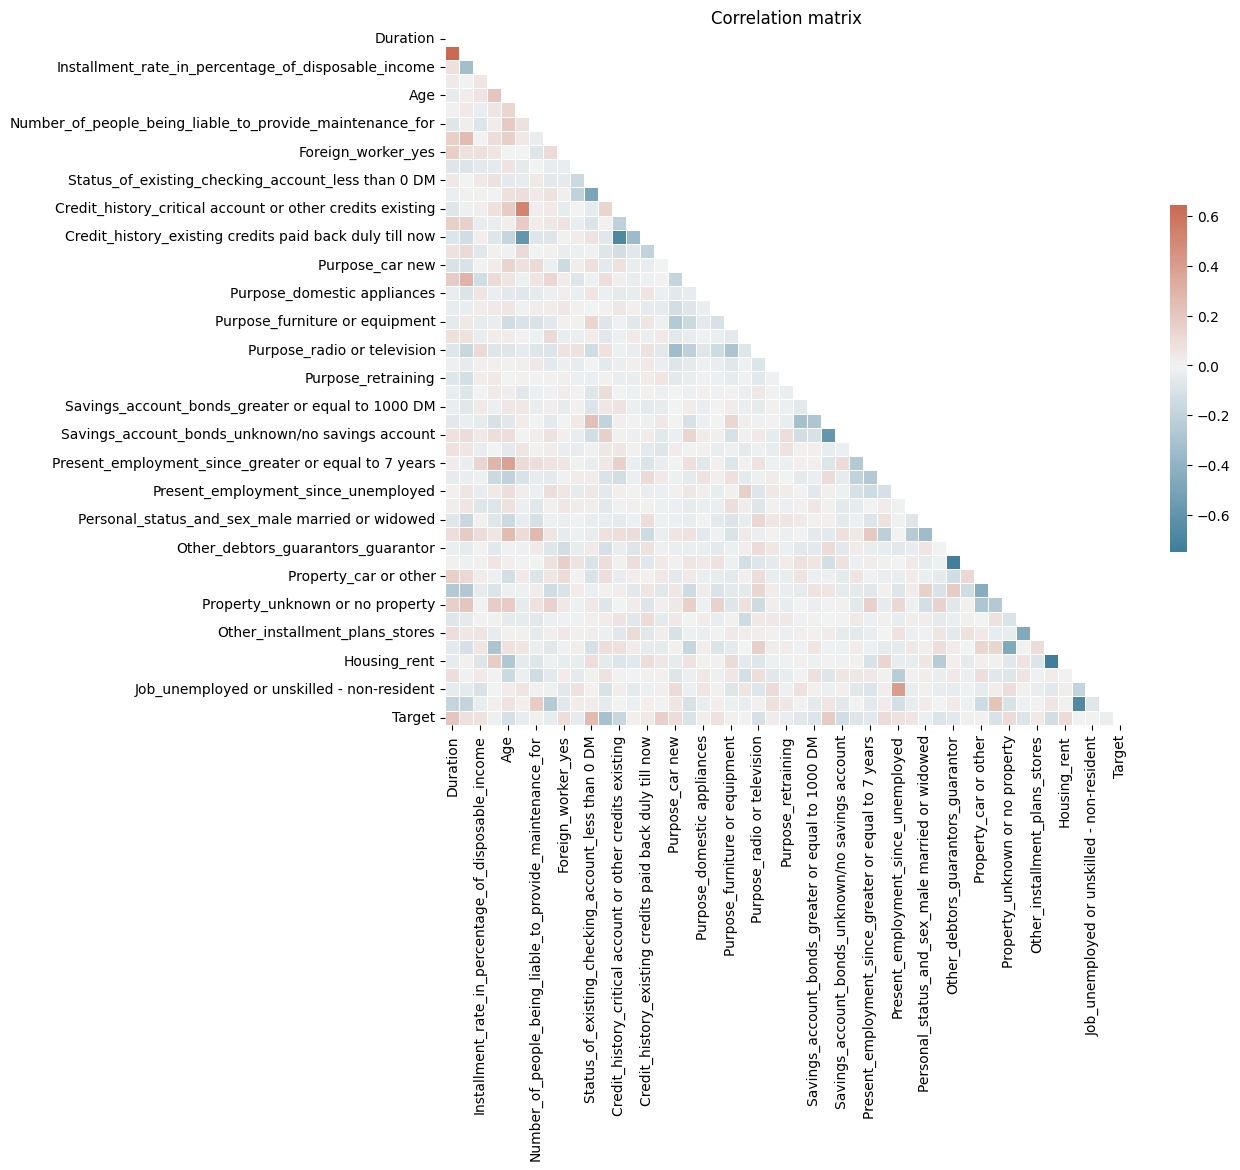

In [ ]:
german_corr = calculate_correlation(german_credit_train_encoded, 'spearman') #, variables_for_correlation)

In [ ]:
abs(german_corr['Target']).sort_values(ascending=False)

Target                                                                                  1.000000
Status_of_existing_checking_account_no checking account                                 0.309854
Status_of_existing_checking_account_less than 0 DM                                      0.262684
Duration                                                                                0.206274
Savings_account_bonds_less than 100 DM                                                  0.179752
Credit_history_critical account or other credits existing                               0.175088
Credit_history_no credits taken or all credits paid back duly                           0.157329
Savings_account_bonds_unknown/no savings account                                        0.127565
Housing_own                                                                             0.126458
Age                                                                                     0.115203
Purpose_radio or television                                                             0.112237
Housing_rent                                                                            0.109753
Present_employment_since_less than 1 year                                               0.105408
Property_unknown or no property                                                         0.104961
Property_real estate                                                                    0.103134
Purpose_car new                                                                         0.100276
Purpose_car used                                                                        0.097503
Other_installment_plans_none                                                            0.093188
Personal_status_and_sex_male single                                                     0.090852
Foreign_worker_yes                                                                      0.089040
Savings_account_bonds_greater or equal to 1000 DM                                       0.087610
Credit_amount                                                                           0.084280
Present_employment_since_unemployed                                                     0.071666
Present_employment_since_from 4 to 7 years                                              0.071164
Installment_rate_in_percentage_of_disposable_income                                     0.071034
Purpose_education                                                                       0.070510
Savings_account_bonds_from 500 to 1000 DM                                               0.067612
Present_employment_since_greater or equal to 7 years                                    0.061207
Other_debtors_guarantors_guarantor                                                      0.059266
Personal_status_and_sex_male divorced or separated                                      0.058140
Credit_history_existing credits paid back duly till now                                 0.045895
Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments    0.042090
Number_of_existing_credits_at_this_bank                                                 0.038335
Other_installment_plans_stores                                                          0.037664
Telephone_yes                                                                           0.037325
Purpose_retraining                                                                      0.032218
Purpose_repairs                                                                         0.030165
Job_unskilled - resident                                                                0.025840
Purpose_domestic appliances                                                             0.024551
Personal_status_and_sex_male married or widowed                                         0.023395
Credit_history_delay in paying off in the past                                          0.018185
Present_residence_since

df columns:  Index(['Duration', 'Credit_amount',
       'Installment_rate_in_percentage_of_disposable_income',
       'Present_residence_since', 'Age',
       'Number_of_existing_credits_at_this_bank',
       'Number_of_people_being_liable_to_provide_maintenance_for',
       'Telephone_yes', 'Foreign_worker_yes',
       'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments',
       'Status_of_existing_checking_account_less than 0 DM',
       'Status_of_existing_checking_account_no checking account',
       'Credit_history_critical account or other credits existing',
       'Credit_history_delay in paying off in the past',
       'Credit_history_existing credits paid back duly till now',
       'Credit_history_no credits taken or all credits paid back duly',
       'Purpose_car new', 'Purpose_car used', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture or equipment', 'Purpose_others',
       'Purpose_radio or television', 'Purp

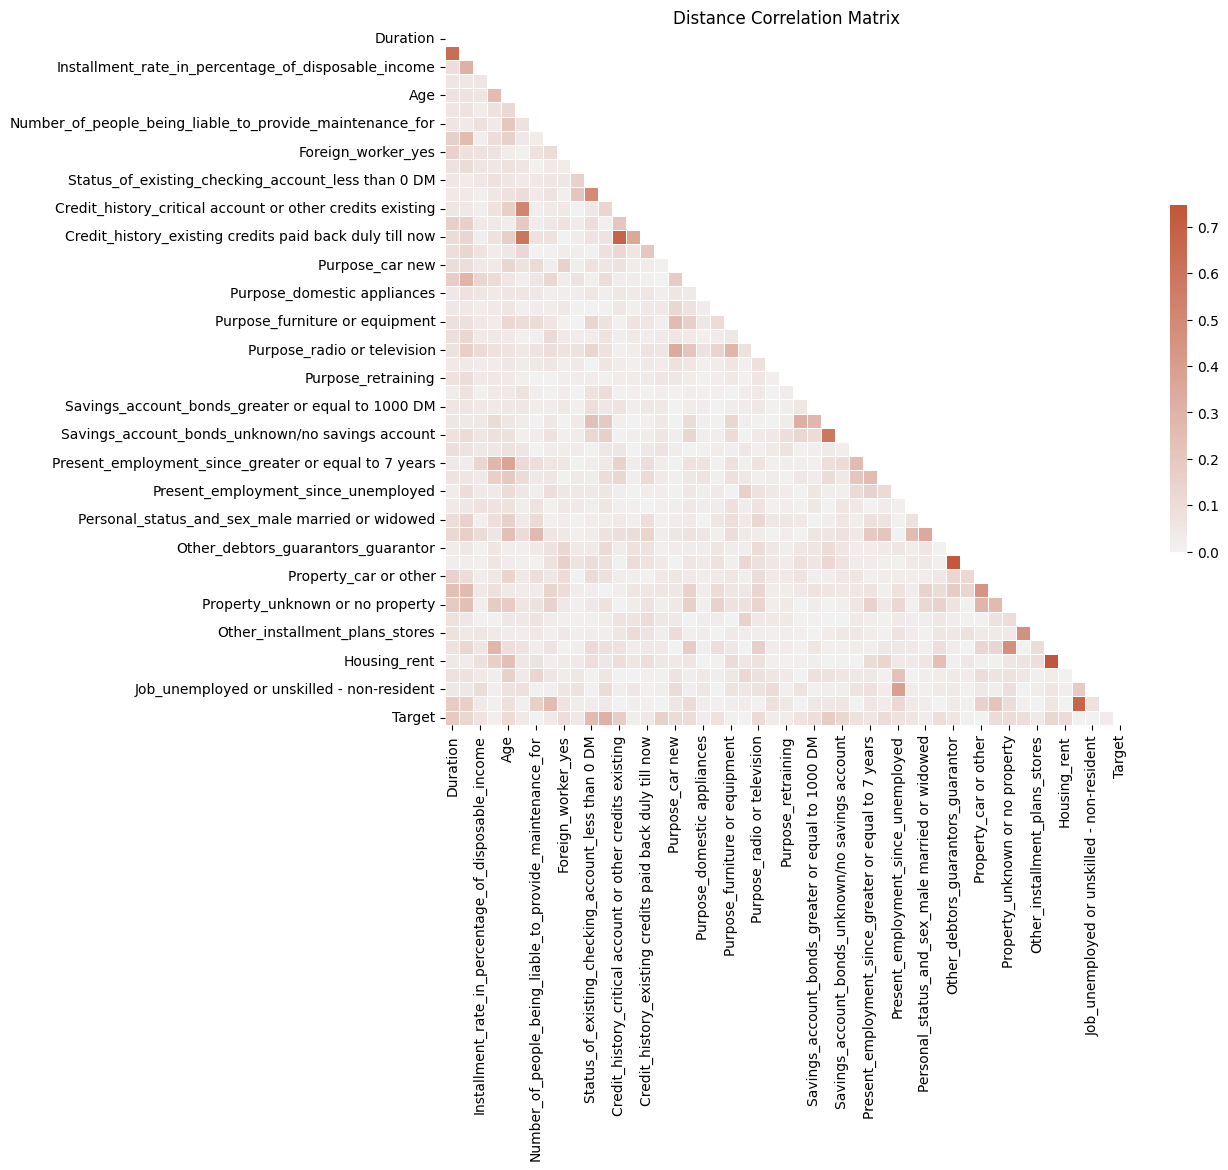

In [ ]:
german_dist_corr = calculate_distance_correlation_matrix(german_credit_train_encoded)

In [ ]:
german_dist_corr['Target'].sort_values(ascending=False)

Target                                                                                  1.000000
Status_of_existing_checking_account_no checking account                                 0.309854
Status_of_existing_checking_account_less than 0 DM                                      0.262684
Duration                                                                                0.197932
Savings_account_bonds_less than 100 DM                                                  0.179752
Credit_history_critical account or other credits existing                               0.175088
Credit_history_no credits taken or all credits paid back duly                           0.157329
Savings_account_bonds_unknown/no savings account                                        0.127565
Housing_own                                                                             0.126458
Credit_amount                                                                           0.125395
Purpose_radio or television                                                             0.112237
Housing_rent                                                                            0.109753
Age                                                                                     0.109304
Present_employment_since_less than 1 year                                               0.105408
Property_unknown or no property                                                         0.104961
Property_real estate                                                                    0.103134
Purpose_car new                                                                         0.100276
Purpose_car used                                                                        0.097503
Other_installment_plans_none                                                            0.093188
Personal_status_and_sex_male single                                                     0.090852
Foreign_worker_yes                                                                      0.089040
Savings_account_bonds_greater or equal to 1000 DM                                       0.087610
Present_employment_since_unemployed                                                     0.071666
Present_employment_since_from 4 to 7 years                                              0.071164
Purpose_education                                                                       0.070510
Installment_rate_in_percentage_of_disposable_income                                     0.069307
Savings_account_bonds_from 500 to 1000 DM                                               0.067612
Present_employment_since_greater or equal to 7 years                                    0.061207
Other_debtors_guarantors_guarantor                                                      0.059266
Personal_status_and_sex_male divorced or separated                                      0.058140
Credit_history_existing credits paid back duly till now                                 0.045895
Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments    0.042090
Number_of_existing_credits_at_this_bank                                                 0.038026
Other_installment_plans_stores                                                          0.037664
Telephone_yes                                                                           0.037325
Purpose_retraining                                                                      0.032218
Purpose_repairs                                                                         0.030165
Job_unskilled - resident                                                                0.025840
Purpose_domestic appliances                                                             0.024551
Personal_status_and_sex_male married or widowed                                         0.023395
Credit_history_delay in paying off in the past                                          0.018185
Present_residence_since

# **Pre-feature selection**
Features with zero-variance will be dropped. The code gives the option for additional removal of extremely weak correlation with the target variable. Nonetheless we will not be using it given that we have non-linear models being tested.

In [ ]:
# Drop columns with zero variance or weak correlation
DROP_WEAK_FEATURES = False
WEAK_THRESHOLD = 0.05

german_zero_variance_columns = identify_zero_variance_columns(german_credit_train_encoded)

if DROP_WEAK_FEATURES:
  german_weak_features = identify_weak_associated_features(
      german_dist_corr, "Target", WEAK_THRESHOLD
  )
else:
  german_weak_features = []

remove_columns = set(german_zero_variance_columns + german_weak_features)
print(remove_columns)

german_credit_train = german_credit_train_encoded.drop(columns=remove_columns)
german_credit_test = german_credit_test_encoded.drop(columns=remove_columns)

Variance of each column:
Duration                                                                                1.429189e+02
Credit_amount                                                                           7.585204e+06
Installment_rate_in_percentage_of_disposable_income                                     1.246832e+00
Present_residence_since                                                                 1.206782e+00
Age                                                                                     1.288472e+02
Number_of_existing_credits_at_this_bank                                                 3.354803e-01
Number_of_people_being_liable_to_provide_maintenance_for                                1.285341e-01
Telephone_yes                                                                           2.400485e-01
Foreign_worker_yes                                                                      3.729506e-02
Status_of_existing_checking_account_greater or equal to 200 DM or 

In [ ]:
print('Original number of encoded features: ', len(german_credit_train_encoded.columns))
print('Number of features after pre-feature selection: ', len(german_credit_train.columns))

Original number of encoded features:  49
Number of features after pre-feature selection:  49


# **Imbalanced dataset**

In [ ]:
X_train = german_credit_train.drop('Target', axis=1)
y_train = german_credit_train['Target']

X_test = german_credit_test.drop('Target', axis=1)
y_test = german_credit_test['Target']

In [ ]:
target_counts = y_train.value_counts()
target_percentages = y_train.value_counts(normalize=True)

df_target_stats = pd.DataFrame({'Count': target_counts, 'Percentage': target_percentages})
df_target_stats

Count  Percentage
Target                   
0.0       560         0.7
1.0       240         0.3

Class imbalance will be addressed directly in the models by using class_weight='balanced' or scale_pos_weight = # majority class / # minority class

# **Models optimized for F1-score**

**Usage of feature permutation importance** Instead of calculating the feature importance because  permutation importance is less biased and reflects better the final goal of this use-case which is to measure the capacity of other variables replace the missing one.

**F1-score and Balanced Accuracy as performance metrics:** All the models in this section are trained using F1-score. In the next section, it will be used the Balanced Accuracy. These metrics were selected over the remaining ones because they:
- provide a more holistic view of the performance by considering precision and recall at the same time
- are more resilient to imbalanced datasets
- are among the preferred on several industries like Financial Services where the accuracy it is not enough per se.

**Missing values imputation with median (continuous variables) and mode (categorical variables):**
- simple missing value imputation technique to overcome the fact of some models implementation not handlung missing values natively and with this level up all the models with the same conditions
- median was used instead of the mean because it is more resilient to outliers and guarantees that the imputed value is part of the domain of the variable and in the case of binary variables median and mode coincide

In [ ]:
german_imputation_values_dict = calculate_imputation_values_for_missing(
    german_credit_train
)
german_imputation_values_dict

{'Duration': 18.0,
 'Credit_amount': 2309.0,
 'Installment_rate_in_percentage_of_disposable_income': 3.0,
 'Present_residence_since': 3.0,
 'Age': 33.0,
 'Number_of_existing_credits_at_this_bank': 1.0,
 'Number_of_people_being_liable_to_provide_maintenance_for': 1.0,
 'Telephone_yes': 0.0,
 'Foreign_worker_yes': 1.0,
 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments': 0.0,
 'Status_of_existing_checking_account_less than 0 DM': 0.0,
 'Status_of_existing_checking_account_no checking account': 0.0,
 'Credit_history_critical account or other credits existing': 0.0,
 'Credit_history_delay in paying off in the past': 0.0,
 'Credit_history_existing credits paid back duly till now': 1.0,
 'Credit_history_no credits taken or all credits paid back duly': 0.0,
 'Purpose_car new': 0.0,
 'Purpose_car used': 0.0,
 'Purpose_domestic appliances': 0.0,
 'Purpose_education': 0.0,
 'Purpose_furniture or equipment': 0.0,
 'Purpose_others': 0.0,
 'Purpose_radio or telev

In [ ]:
german_cat_vars = [col for col in X_train.columns if X_train[col].nunique() <= 2]
german_cat_vars

['Number_of_people_being_liable_to_provide_maintenance_for',
 'Telephone_yes',
 'Foreign_worker_yes',
 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments',
 'Status_of_existing_checking_account_less than 0 DM',
 'Status_of_existing_checking_account_no checking account',
 'Credit_history_critical account or other credits existing',
 'Credit_history_delay in paying off in the past',
 'Credit_history_existing credits paid back duly till now',
 'Credit_history_no credits taken or all credits paid back duly',
 'Purpose_car new',
 'Purpose_car used',
 'Purpose_domestic appliances',
 'Purpose_education',
 'Purpose_furniture or equipment',
 'Purpose_others',
 'Purpose_radio or television',
 'Purpose_repairs',
 'Purpose_retraining',
 'Savings_account_bonds_from 500 to 1000 DM',
 'Savings_account_bonds_greater or equal to 1000 DM',
 'Savings_account_bonds_less than 100 DM',
 'Savings_account_bonds_unknown/no savings account',
 'Present_employment_since_from 4 t

In [ ]:
# Maximum number of original features to be imputed
NUM_FEAT = 20

##**Decision tree**

**Cross-validation (3,3) for large datasets and (5,5) for smaller datasets:**
- due to the unpractical runtime of some of the models, the cross-validaton set up on large datasets consists in a nested-cv with 3-fold in both inner and outer CV. The number of folds is increased to (5,5) in smaller datsets.
- this assumption is reasonable given that in larger datasets there is a higher chance of the holdout samples being big enough to be more representative and less prone to biases. So a smaller number of folds can be assummed
- on the other hand, in smaller datasets it is crucial to reduce the variance and any potential misrepresentativeness of a specific validation set, so it is requires a larger number of folds to make a more efficient use of the data available.


In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 2],  # last option reflects num of samples instead of proportion
      'min_samples_leaf': [0.2, 0.1, 0.05, 0.01, 0.005, 1]  # last option reflects num of samples instead of proportion
  }
else:
  # best model
  dt_param_grid = {
      'max_depth': [3],
      'min_samples_split': [0.05],
      'min_samples_leaf': [0.005]
  }

dt_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt_grid_search, dt_best_model, dt_best_params = hyperparameter_tuning(
    dt_classifier, dt_param_grid, 5, 5, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-19 01:18:36.518564

Nested Cross-validation Results:
Individual scores: [0.57342657 0.5323741  0.56375839 0.5915493  0.55172414]
Average nested CV score: 0.563 (+/- 0.040)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 3, 'min_samples_leaf': 0.005, 'min_samples_split': 0.05}

Best Model Performance:
Best CV score: 0.563

Train score: 0.599
Test score: 0.563
Train-test score difference: 0.037
2025-01-19 01:18:38.704848

Execution time: 0.04 minutes




```
Starting hyperparameter tuning at: 2025-01-14 22:53:53.096682

Nested Cross-validation Results:
Individual scores: [0.57342657 0.53030303 0.53061224 0.57746479 0.58730159]
Average nested CV score: 0.560 (+/- 0.049)

Fitting final model on entire dataset...
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters: {'max_depth': 3, 'min_samples_leaf': 0.005, 'min_samples_split': 0.05}

Best Model Performance:
Best CV score: 0.563

Train score: 0.599
Test score: 0.563
Train-test score difference: 0.037
2025-01-14 22:54:19.063745

Execution time: 0.43 minutes
```



In [ ]:
# dt_grid_search.cv_results_

In [ ]:
dt_classifier, dt_train_pred, dt_test_pred = apply_model(dt_best_model, X_train, y_train, X_test, y_test)
dt_feat_permut_import_df = analyze_feat_permut_import(dt_classifier, X_train, y_train, scoring_metric="f1")
dt_feat_permut_import_df[dt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
11  Status_of_existing_checking_account_no checkin...    0.146982  0.019403
0                                            Duration    0.032723  0.009038
41                       Other_installment_plans_none    0.026112  0.003396
4                                                 Age    0.022659  0.003718
22                        Purpose_radio or television    0.008253  0.003629

**Note:** feature permutation importance values do not sum up to 100% because they represent the drop in model performance when each feature is permuted, and they are not normalized.

Values can be negative if permuting an unimportant feature improves model performance.

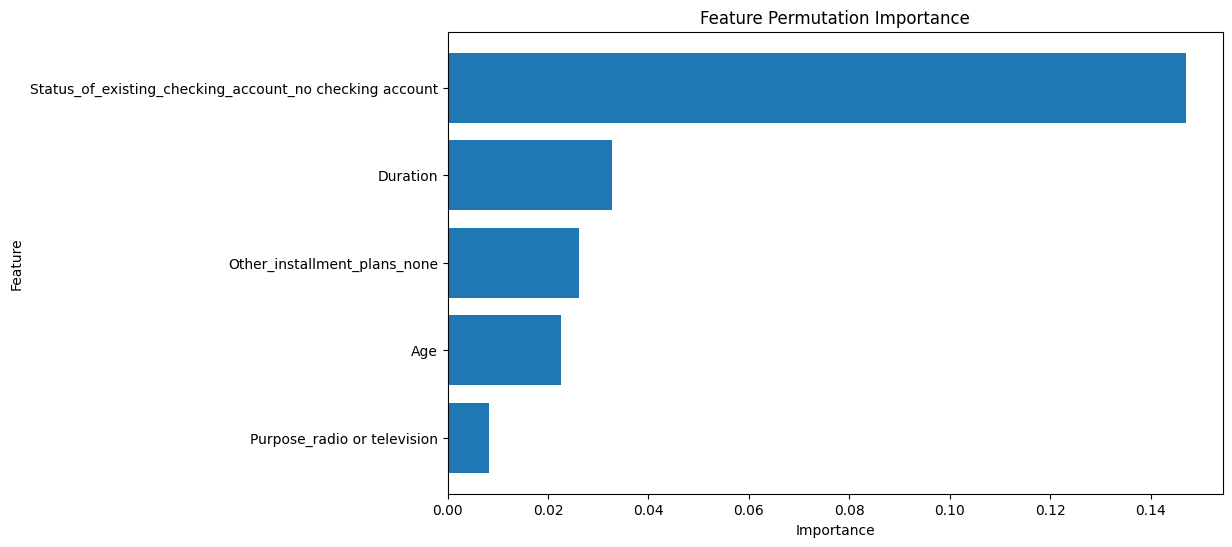

In [ ]:
plot_feat_permut_importance(dt_feat_permut_import_df)

In [ ]:
dt_perf, dt_orig_missing, dt_missing = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Duration
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration']

--- NEW ITERATION ---
Removing feature:  Other_installment_plans_none
Removing related features:  ['Other_installment_plans_none', 'Other_installment_plans_stores']
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration', 'Other_installment_plans']

--- NEW ITERATION ---
Removing feature:  Age
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration', 'Other_installment_plans', 'Age']

--- NEW ITERATION ---
Remov

In [ ]:
dt_orig_missing

['Status_of_existing_checking_account',
 'Duration',
 'Other_installment_plans',
 'Age',
 'Purpose',
 'Other_debtors_guarantors',
 'Savings_account_bonds',
 'Present_employment_since',
 'Personal_status_and_sex',
 'Job',
 'Property',
 'Housing',
 'Credit_history',
 'Installment_rate_in_percentage_of_disposable_income',
 'Present_residence_since',
 'Number_of_existing_credits_at_this_bank',
 'Number_of_people_being_liable_to_provide_maintenance_for',
 'Telephone',
 'Foreign_worker',
 'Credit_amount']

In [ ]:
len(dt_missing)

48

In [ ]:
dt_perf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   52  71   69   8      42.98   86.67        50.71      61.5     57.46   
1   58   9  131   2      30.69   96.67         6.43      33.5     46.59   
2   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
3   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
4   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
5   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
6   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
7   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
8   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
9   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
10  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
11  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
12  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
13  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
14  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
15  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               68.69                 0   
1               51.55                 1   
2               50.00                 2   
3               50.00                 3   
4               50.00                 4   
5               50.00                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())


dt_perf_mf, dt_orig_missing_mf, dt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 01:18:59.356936

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
dt_perf_mf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   52  71   69   8      42.98   86.67        50.71      61.5     57.46   
1   47  48   92  13      33.81   78.33        34.29      47.5     47.24   
2   47  47   93  13      33.57   78.33        33.57      47.0     47.00   
3   47  54   86  13      35.34   78.33        38.57      50.5     48.70   
4   47  55   85  13      35.61   78.33        39.29      51.0     48.96   
5   42  67   73  18      36.52   70.00        47.86      54.5     48.00   
6   43  69   71  17      37.72   71.67        49.29      56.0     49.43   
7   46  48   92  14      33.33   76.67        34.29      47.0     46.46   
8   49  37  103  11      32.24   81.67        26.43      43.0     46.23   
9   52  37  103   8      33.55   86.67        26.43      44.5     48.37   
10  53  31  109   7      32.72   88.33        22.14      42.0     47.75   
11  58  12  128   2      31.18   96.67         8.57      35.0     47.15   
12  58  14  126   2      31.52   96.67        10.00      36.0     47.54   
13  58  12  128   2      31.18   96.67         8.57      35.0     47.15   
14  57  10  130   3      30.48   95.00         7.14      33.5     46.15   
15  58   4  136   2      29.90   96.67         2.86      31.0     45.67   
16  57   7  133   3      30.00   95.00         5.00      32.0     45.60   
17  57   9  131   3      30.32   95.00         6.43      33.0     45.97   
18  57   9  131   3      30.32   95.00         6.43      33.0     45.97   
19  58   4  136   2      29.90   96.67         2.86      31.0     45.67   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               68.69                 0   
1               56.31                 1   
2               55.95                 2   
3               58.45                 3   
4               58.81                 4   
5               58.93                 5   
6               60.48                 6   
7               55.48                 7   
8               54.05                 8   
9               56.55                 9   
10              55.24                10   
11              52.62                11   
12              53.33                12   
13              52.62                13   
14              51.07                14   
15              49.76                15   
16              50.00                16   
17              50.71                17   
18              50.71                18   
19              49.76                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 2],
      'min_samples_leaf': [0.2, 0.1, 0.05, 0.01, 1]
  }
else:
  # best model
  rf_param_grid = {
      'n_estimators': [100],
      'max_features': ['sqrt'],
      'min_samples_split': [0.05],
      'min_samples_leaf': [1],
      'max_depth': [3]
  }

rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf_grid_search, rf_best_model, rf_best_params = hyperparameter_tuning(rf_classifier, rf_param_grid, 5, 5, 'f1', X_train, y_train)

Starting hyperparameter tuning at: 2025-01-19 01:21:43.328788

Nested Cross-validation Results:
Individual scores: [0.56074766 0.61666667 0.56666667 0.59322034 0.62962963]
Average nested CV score: 0.593 (+/- 0.054)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.05, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.593

Train score: 0.639
Test score: 0.593
Train-test score difference: 0.045
2025-01-19 01:21:45.224166

Execution time: 0.03 minutes



```
Starting hyperparameter tuning at: 2025-01-14 23:01:31.877726

Nested Cross-validation Results:
Individual scores: [0.55769231 0.57142857 0.54545455 0.5648855  0.59649123]
Average nested CV score: 0.567 (+/- 0.034)

Fitting final model on entire dataset...
Fitting 5 folds for each of 675 candidates, totalling 3375 fits
Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.05, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.593

Train score: 0.639
Test score: 0.593
Train-test score difference: 0.045
2025-01-14 23:39:52.855642

Execution time: 38.35 minutes
```





In [ ]:
rf_classifier, rf_train_pred, rf_test_pred = apply_model(rf_best_model, X_train, y_train, X_test, y_test)
rf_feat_permut_import_df = analyze_feat_permut_import(rf_classifier, X_train, y_train, scoring_metric="f1")
rf_feat_permut_import_df[rf_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
11  Status_of_existing_checking_account_no checkin...    0.085914  0.009930
0                                            Duration    0.040819  0.012534
4                                                 Age    0.015372  0.006491
1                                       Credit_amount    0.014861  0.002711
10  Status_of_existing_checking_account_less than ...    0.013381  0.005318
27             Savings_account_bonds_less than 100 DM    0.012655  0.010329
12  Credit_history_critical account or other credi...    0.012118  0.005779
31          Present_employment_since_less than 1 year    0.005553  0.004286
15  Credit_history_no credits taken or all credits...    0.005282  0.000925
39                               Property_real estate    0.005212  0.001952
47                           Job_unskilled - resident    0.004233  0.000505
35                Personal_status_and_sex_male single    0.004158  0.002091
41                       Other_installment_plans_none    0.003874  0.002901
5             Number_of_existing_credits_at_this_bank    0.003331  0.001254
16                                    Purpose_car new    0.003009  0.000855
22                        Purpose_radio or television    0.002787  0.002622
3                             Present_residence_since    0.002672  0.002249
17                                   Purpose_car used    0.002636  0.003287
13     Credit_history_delay in paying off in the past    0.002348  0.000000
45                   Job_skilled employee or official    0.002314  0.002513
32                Present_employment_since_unemployed    0.002096  0.001130
43                                        Housing_own    0.001848  0.005380
28   Savings_account_bonds_unknown/no savings account    0.001620  0.002605
44                                       Housing_rent    0.000637  0.002086
40                    Property_unknown or no property    0.000592  0.001738
9   Status_of_existing_checking_account_greater or...    0.000251  0.001131
37                      Other_debtors_guarantors_none    0.000218  0.000436
2   Installment_rate_in_percentage_of_disposable_i...    0.000127  0.001230
25          Savings_account_bonds_from 500 to 1000 DM    0.000064  0.001617
19                                  Purpose_education   -0.000032  0.001253
33  Personal_status_and_sex_male divorced or separ...   -0.000032  0.001253
36                 Other_debtors_guarantors_guarantor   -0.000374  0.002586
7                                       Telephone_yes   -0.000563  0.000530
29         Present_employment_since_from 4 to 7 years   -0.000657  0.000877
26  Savings_account_bonds_greater or equal to 1000 DM   -0.000813  0.000849
34    Personal_status_and_sex_male married or widowed   -0.000845  0.001328
8                                  Foreign_worker_yes   -0.001373  0.001374

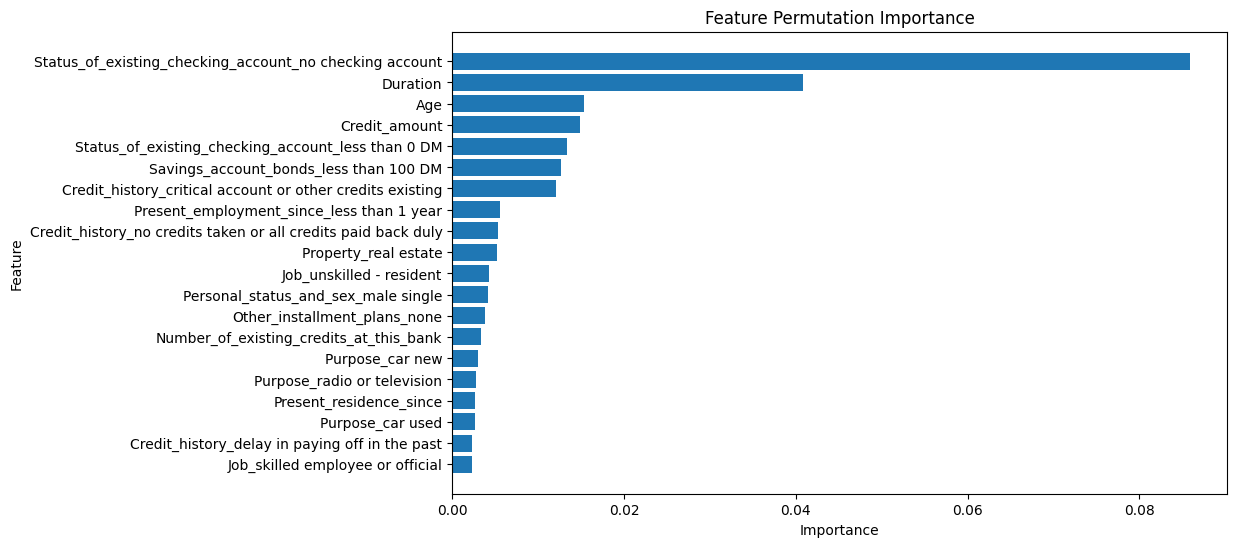

In [ ]:
plot_feat_permut_importance(rf_feat_permut_import_df)

In [ ]:
rf_perf, rf_orig_missing, rf_missing = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Duration
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration']

--- NEW ITERATION ---
Removing feature:  Age
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration', 'Age']

--- NEW ITERATION ---
Removing feature:  Credit_amount
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration', 'Age', 'Credit_amount']

--- NEW ITERATION ---

--- NEW ITERATION ---
Removing feature:  Savings_account_bonds_less than 100 DM
Removing related features:  ['Savings_account_bonds_from 500 to 

In [ ]:
rf_perf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   50  96   44  10      53.19   83.33        68.57      73.0     64.94   
1   48  73   67  12      41.74   80.00        52.14      60.5     54.86   
2   53  58   82   7      39.26   88.33        41.43      55.5     54.36   
3   53  52   88   7      37.59   88.33        37.14      52.5     52.74   
4   50  58   82  10      37.88   83.33        41.43      54.0     52.08   
5   59  12  128   1      31.55   98.33         8.57      35.5     47.77   
6   59   1  139   1      29.80   98.33         0.71      30.0     45.74   
7   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
8   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
9   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
10  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
11  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
12  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
13  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
14  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
15  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               75.95                 0   
1               66.07                 1   
2               64.88                 2   
3               62.74                 3   
4               62.38                 4   
5               53.45                 5   
6               49.52                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf_perf_mf, rf_orig_missing_mf, rf_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 01:21:46.593132

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
rf_perf_mf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   50  96   44  10      53.19   83.33        68.57      73.0     64.94   
1   38  78   62  22      38.00   63.33        55.71      58.0     47.50   
2   43  76   64  17      40.19   71.67        54.29      59.5     51.50   
3   43  75   65  17      39.81   71.67        53.57      59.0     51.19   
4   42  70   70  18      37.50   70.00        50.00      56.0     48.84   
5   50  45   95  10      34.48   83.33        32.14      47.5     48.78   
6   53  26  114   7      31.74   88.33        18.57      39.5     46.70   
7   54  24  116   6      31.76   90.00        17.14      39.0     46.96   
8   57  14  126   3      31.15   95.00        10.00      35.5     46.91   
9   58  15  125   2      31.69   96.67        10.71      36.5     47.74   
10  57  23  117   3      32.76   95.00        16.43      40.0     48.72   
11  56  28  112   4      33.33   93.33        20.00      42.0     49.12   
12  55  24  116   5      32.16   91.67        17.14      39.5     47.62   
13  59   2  138   1      29.95   98.33         1.43      30.5     45.91   
14  59   2  138   1      29.95   98.33         1.43      30.5     45.91   
15  59   3  137   1      30.10   98.33         2.14      31.0     46.09   
16  59   3  137   1      30.10   98.33         2.14      31.0     46.09   
17  59   3  137   1      30.10   98.33         2.14      31.0     46.09   
18  59   5  135   1      30.41   98.33         3.57      32.0     46.46   
19  59   5  135   1      30.41   98.33         3.57      32.0     46.46   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               75.95                 0   
1               59.52                 1   
2               62.98                 2   
3               62.62                 3   
4               60.00                 4   
5               57.74                 5   
6               53.45                 6   
7               53.57                 7   
8               52.50                 8   
9               53.69                 9   
10              55.71                10   
11              56.67                11   
12              54.40                12   
13              49.88                13   
14              49.88                14   
15              50.24                15   
16              50.24                16   
17              50.24                17   
18              50.95                18   
19              50.95                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

## **Gradient-Boosted Trees**

Instead of class_weight='balanced', GBT and XGBoost recommends the use of scale_pos_weight = # majority class samples / # minority class samples

- https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [ ]:
# scale_pos_weight value
ratio_majority_minority = y_train[y_train==0].count()/y_train[y_train==1].count()
ratio_majority_minority

2.3333333333333335

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [40, 8, 1],
      'min_split_gain': [1, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt_param_grid = {
    'n_estimators': [100],
    'max_depth': [4],
    'min_child_samples': [1],
    'min_split_gain': [0.5],
    'reg_lambda': [1.0]
}

gbt_classifier = LGBMClassifier(
    objective= "binary",
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt_grid_search, gbt_best_model, gbt_best_params = hyperparameter_tuning(
    gbt_classifier, gbt_param_grid, 5, 5, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-19 01:24:32.913300

Nested Cross-validation Results:
Individual scores: [0.5631068  0.64150943 0.62385321 0.63551402 0.56862745]
Average nested CV score: 0.607 (+/- 0.067)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 4, 'min_child_samples': 1, 'min_split_gain': 0.5, 'n_estimators': 100, 'reg_lambda': 1.0}

Best Model Performance:
Best CV score: 0.607

Train score: 0.887
Test score: 0.607
Train-test score difference: 0.281
2025-01-19 01:24:34.245772

Execution time: 0.02 minutes


```
Starting hyperparameter tuning at: 2025-01-14 23:39:54.658223

Nested Cross-validation Results:
Individual scores: [0.57692308 0.59047619 0.54867257 0.57894737 0.60714286]
Average nested CV score: 0.580 (+/- 0.038)

Fitting final model on entire dataset...
Fitting 5 folds for each of 675 candidates, totalling 3375 fits
Best parameters: {'max_depth': 4, 'min_child_samples': 1, 'min_split_gain': 0.5, 'n_estimators': 100, 'reg_lambda': 1.0}

Best Model Performance:
Best CV score: 0.607

Train score: 0.887
Test score: 0.607
Train-test score difference: 0.281
2025-01-14 23:42:56.555919

Execution time: 3.03 minutes
```





In [ ]:
gbt_classifier, gbt_train_pred, gbt_test_pred = apply_model(gbt_best_model, X_train, y_train, X_test, y_test)
gbt_feat_permut_import_df = analyze_feat_permut_import(gbt_classifier, X_train, y_train, scoring_metric="f1")
gbt_feat_permut_import_df[gbt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                                            Duration    0.151439  0.013316
1                                       Credit_amount    0.135026  0.008076
11  Status_of_existing_checking_account_no checkin...    0.115953  0.009078
4                                                 Age    0.077089  0.004441
17                                   Purpose_car used    0.041508  0.004646
12  Credit_history_critical account or other credi...    0.038707  0.006001
27             Savings_account_bonds_less than 100 DM    0.029507  0.008696
41                       Other_installment_plans_none    0.027179  0.004747
36                 Other_debtors_guarantors_guarantor    0.024996  0.001998
16                                    Purpose_car new    0.022954  0.005140
29         Present_employment_since_from 4 to 7 years    0.017332  0.004054
10  Status_of_existing_checking_account_less than ...    0.015998  0.003529
6   Number_of_people_being_liable_to_provide_maint...    0.014630  0.004709
35                Personal_status_and_sex_male single    0.013008  0.003857
44                                       Housing_rent    0.013000  0.002554
22                        Purpose_radio or television    0.011860  0.006645
32                Present_employment_since_unemployed    0.011596  0.002661
2   Installment_rate_in_percentage_of_disposable_i...    0.011267  0.001970
19                                  Purpose_education    0.008536  0.003163
31          Present_employment_since_less than 1 year    0.007549  0.002885
9   Status_of_existing_checking_account_greater or...    0.006698  0.001430
15  Credit_history_no credits taken or all credits...    0.006683  0.001602
39                               Property_real estate    0.006245  0.003948
8                                  Foreign_worker_yes    0.005254  0.003961
43                                        Housing_own    0.005031  0.001681
26  Savings_account_bonds_greater or equal to 1000 DM    0.004502  0.001874
28   Savings_account_bonds_unknown/no savings account    0.003961  0.001317
40                    Property_unknown or no property    0.003517  0.003156
7                                       Telephone_yes    0.002959  0.001822
33  Personal_status_and_sex_male divorced or separ...    0.002837  0.001321
3                             Present_residence_since    0.002615  0.001633
24                                 Purpose_retraining    0.001656  0.000000
34    Personal_status_and_sex_male married or widowed    0.001325  0.000662
30  Present_employment_since_greater or equal to 7...    0.000435  0.000871
46         Job_unemployed or unskilled - non-resident    0.000435  0.000871
23                                    Purpose_repairs    0.000435  0.000871
5             Number_of_existing_credits_at_this_bank   -0.000088  0.003362
47                           Job_unskilled - resident   -0.000103  0.001216
21                                     Purpose_others   -0.000332  0.000665

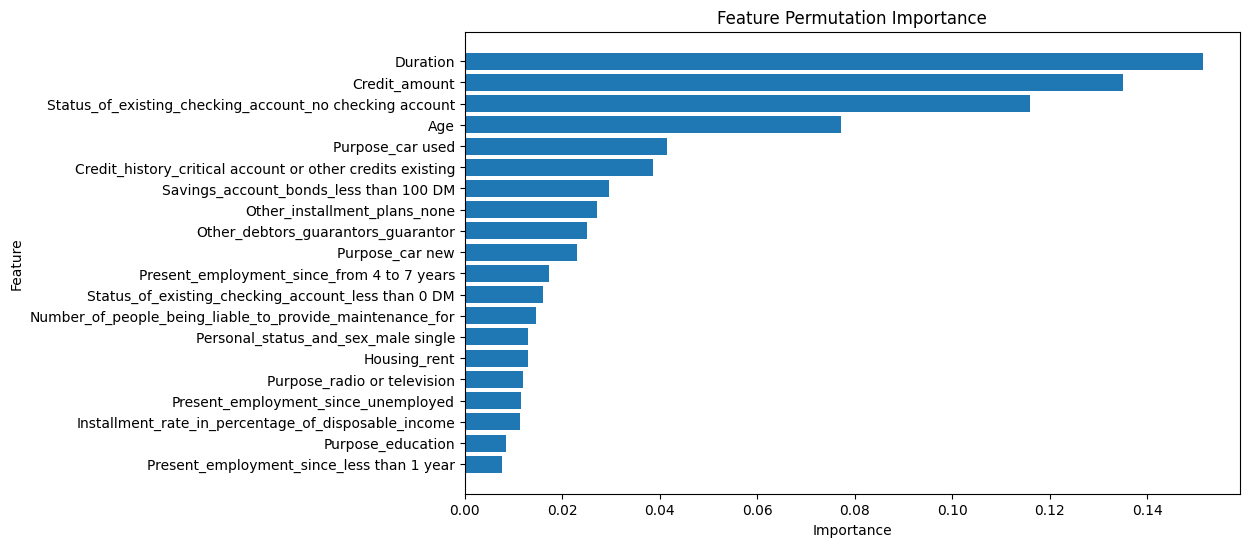

In [ ]:
plot_feat_permut_importance(gbt_feat_permut_import_df)

In [ ]:
gbt_perf, gbt_orig_missing, gbt_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Duration
Original feat removed so far:  ['Duration']

--- NEW ITERATION ---
Removing feature:  Credit_amount
Original feat removed so far:  ['Duration', 'Credit_amount']

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Duration', 'Credit_amount', 'Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Age
Original feat removed so far:  ['Duration', 'Credit_amount', 'Status_of_existing_checking_account', 'Age']

--- NEW ITERATION ---
Removing feature:  Purpose_car used
Removing related features:  ['Purpose_car new', 'Purpose_car used', 'Purpose_domestic appliances', 'Purpose_education', 'Purpose_furniture or equipm

In [ ]:
gbt_perf

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   45  101   39  15      53.57   75.00        72.14      73.0     62.50   
1   44   89   51  16      46.32   73.33        63.57      66.5     56.77   
2   40   97   43  20      48.19   66.67        69.29      68.5     55.94   
3   43   86   54  17      44.33   71.67        61.43      64.5     54.78   
4   46   77   63  14      42.20   76.67        55.00      61.5     54.44   
5   41   81   59  19      41.00   68.33        57.86      61.0     51.25   
6   39   72   68  21      36.45   65.00        51.43      55.5     46.71   
7   51   38  102   9      33.33   85.00        27.14      44.5     47.89   
8   51   38  102   9      33.33   85.00        27.14      44.5     47.89   
9   52   31  109   8      32.30   86.67        22.14      41.5     47.06   
10  57   19  121   3      32.02   95.00        13.57      38.0     47.90   
11  56   23  117   4      32.37   93.33        16.43      39.5     48.07   
12  46   40  100  14      31.51   76.67        28.57      43.0     44.66   
13  42   52   88  18      32.31   70.00        37.14      47.0     44.21   
14  57    8  132   3      30.16   95.00         5.71      32.5     45.78   
15  57    8  132   3      30.16   95.00         5.71      32.5     45.78   
16  58    3  137   2      29.74   96.67         2.14      30.5     45.49   
17  58    3  137   2      29.74   96.67         2.14      30.5     45.49   
18  58    3  137   2      29.74   96.67         2.14      30.5     45.49   
19  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               73.57                 0   
1               68.45                 1   
2               67.98                 2   
3               66.55                 3   
4               65.83                 4   
5               63.10                 5   
6               58.21                 6   
7               56.07                 7   
8               56.07                 8   
9               54.40                 9   
10              54.29                10   
11              54.88                11   
12              52.62                12   
13              53.57                13   
14              50.36                14   
15              50.36                15   
16              49.40                16   
17              49.40                17   
18              49.40                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                                ['Duration'] imputed  
2               ['Duration', 'Credit_amount'] imputed  
3   ['Duration', 'Credit_amount', 'Status_of_exist...  
4   ['Duration', 'Credit_amount', 'Status_of_exist...  
5   ['Duration', 'Credit_amount', 'Status_of_exist...  
6   ['Duration', 'Credit_amount', 'Status_of_exist...  
7   ['Duration', 'Credit_amount', 'Status_of_exist...  
8   ['Duration', 'Credit_amount', 'Status_of_exist...  
9   ['Duration', 'Credit_amount', 'Status_of_exist...  
10  ['Duration', 'Credit_amount', 'Status_of_exist...  
11  ['Duration', 'Credit_amount', 'Status_of_exist...  
12  ['Duration', 'Credit_amount', 'Status_of_exist...  
13  ['Duration', 'Credit_amount', 'Status_of_exist...  
14  ['Duration', 'Credit_amount', 'Status_of_exist...  
15  ['Duration', 'Credit_amount', 'Status_of_exist...  
16  ['Duration', 'Credit_amount', 'Status_of_exist...  
17  ['Duration', 'Credit_amount', 'Status_of_exist...  
18  ['Duration', 'Credit_amount', 'Status_of_exist...  
19  ['Duration', 'Credit_amount', 'Status_of_exist...  
20  ['Duration', 'Credit_amount', 'Status_of_exist...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt_perf_mf, gbt_orig_missing_mf, gbt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 01:24:35.126410

--- NEW ITERATION ---
Removing feature:  Duration
Nr. columns with nan:  1
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Credit_history_existing credits paid back duly till now', 'Credit_history_no credits taken or all credits paid back duly', 'Purpose_car new', 'Purpose_car used', 'Purpose_domestic appliances', 'Purpose_education', 'Purpose_furniture or equipment', 'Purpose_others', 'Purpose_radio

In [ ]:
gbt_perf_mf

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   45  101   39  15      53.57   75.00        72.14      73.0     62.50   
1   48   97   43  12      52.75   80.00        69.29      72.5     63.58   
2   38  100   40  22      48.72   63.33        71.43      69.0     55.07   
3   37   97   43  23      46.25   61.67        69.29      67.0     52.86   
4   34   90   50  26      40.48   56.67        64.29      62.0     47.22   
5   38   85   55  22      40.86   63.33        60.71      61.5     49.67   
6   38   72   68  22      35.85   63.33        51.43      55.0     45.78   
7   46   47   93  14      33.09   76.67        33.57      46.5     46.23   
8   45   48   92  15      32.85   75.00        34.29      46.5     45.69   
9   47   48   92  13      33.81   78.33        34.29      47.5     47.24   
10  50   37  103  10      32.68   83.33        26.43      43.5     46.95   
11  49   36  104  11      32.03   81.67        25.71      42.5     46.01   
12  49   41   99  11      33.11   81.67        29.29      45.0     47.12   
13  49   39  101  11      32.67   81.67        27.86      44.0     46.67   
14  44   49   91  16      32.59   73.33        35.00      46.5     45.13   
15  59    5  135   1      30.41   98.33         3.57      32.0     46.46   
16  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               73.57                 0   
1               74.64                 1   
2               67.38                 2   
3               65.48                 3   
4               60.48                 4   
5               62.02                 5   
6               57.38                 6   
7               55.12                 7   
8               54.64                 8   
9               56.31                 9   
10              54.88                10   
11              53.69                11   
12              55.48                12   
13              54.76                13   
14              54.17                14   
15              50.95                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                                ['Duration'] imputed  
2               ['Duration', 'Credit_amount'] imputed  
3   ['Duration', 'Credit_amount', 'Status_of_exist...  
4   ['Duration', 'Credit_amount', 'Status_of_exist...  
5   ['Duration', 'Credit_amount', 'Status_of_exist...  
6   ['Duration', 'Credit_amount', 'Status_of_exist...  
7   ['Duration', 'Credit_amount', 'Status_of_exist...  
8   ['Duration', 'Credit_amount', 'Status_of_exist...  
9   ['Duration', 'Credit_amount', 'Status_of_exist...  
10  ['Duration', 'Credit_amount', 'Status_of_exist...  
11  ['Duration', 'Credit_amount', 'Status_of_exist...  
12  ['Duration', 'Credit_amount', 'Status_of_exist...  
13  ['Duration', 'Credit_amount', 'Status_of_exist...  
14  ['Duration', 'Credit_amount', 'Status_of_exist...  
15  ['Duration', 'Credit_amount', 'Status_of_exist...  
16  ['Duration', 'Credit_amount', 'Status_of_exist...  
17  ['Duration', 'Credit_amount', 'Status_of_exist...  
18  ['Duration', 'Credit_amount', 'Status_of_exist...  
19  ['Duration', 'Credit_amount', 'Status_of_exist...  
20  ['Duration', 'Credit_amount', 'Status_of_exist...

## **XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10.0, 5.0, 1.0, 0.5, 0.0],   # L2 regularization on weights
      'gamma': [1.0, 0.5, 0.1, 0.05, 0.0],       # Minimum loss reduction required for node splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  # Best model
  xgb_param_grid = {
    'n_estimators': [100],
    'max_depth': [3],
    'reg_lambda':[5.0],
    'gamma': [1.0],
    'colsample_bytree':[0.25]
}

xgb_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE
)
xgb_grid_search, xgb_best_model, xgb_best_params = hyperparameter_tuning(
    xgb_classifier, xgb_param_grid, 5, 5, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-19 01:27:21.969944

Nested Cross-validation Results:
Individual scores: [0.57142857 0.59459459 0.59130435 0.62962963 0.63063063]
Average nested CV score: 0.604 (+/- 0.046)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'colsample_bytree': 0.25, 'gamma': 1.0, 'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.604

Train score: 0.763
Test score: 0.604
Train-test score difference: 0.159
2025-01-19 01:27:22.697090

Execution time: 0.01 minutes


```
Starting hyperparameter tuning at: 2025-01-14 17:15:37.879127

Nested Cross-validation Results:
Individual scores: [0.51428571 0.59259259 0.4893617  0.58928571 0.59615385]
Average nested CV score: 0.556 (+/- 0.091)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
Best parameters: {'colsample_bytree': 0.25, 'gamma': 1.0, 'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.604

Train score: 0.763
Test score: 0.604
Train-test score difference: 0.159
2025-01-14 17:35:54.176636

Execution time: 20.27 minutes
```




In [ ]:
xgb_classifier, xgb_train_pred, xgb_test_pred = apply_model(xgb_best_model, X_train, y_train, X_test, y_test)
xgb_feat_permut_import_df = analyze_feat_permut_import(xgb_classifier, X_train, y_train, scoring_metric="f1")
xgb_feat_permut_import_df[xgb_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                                            Duration    0.081003  0.009200
11  Status_of_existing_checking_account_no checkin...    0.063818  0.010468
1                                       Credit_amount    0.062900  0.013354
17                                   Purpose_car used    0.022499  0.005384
12  Credit_history_critical account or other credi...    0.020950  0.008681
4                                                 Age    0.018628  0.007924
27             Savings_account_bonds_less than 100 DM    0.018002  0.005471
28   Savings_account_bonds_unknown/no savings account    0.013236  0.003295
45                   Job_skilled employee or official    0.013161  0.003061
6   Number_of_people_being_liable_to_provide_maint...    0.011356  0.007772
3                             Present_residence_since    0.009873  0.005469
7                                       Telephone_yes    0.009417  0.004618
36                 Other_debtors_guarantors_guarantor    0.009256  0.003133
10  Status_of_existing_checking_account_less than ...    0.008665  0.010492
29         Present_employment_since_from 4 to 7 years    0.008643  0.003443
43                                        Housing_own    0.008414  0.001617
16                                    Purpose_car new    0.008037  0.004313
44                                       Housing_rent    0.007219  0.003120
22                        Purpose_radio or television    0.006683  0.003938
9   Status_of_existing_checking_account_greater or...    0.005875  0.002859
41                       Other_installment_plans_none    0.005731  0.002032
39                               Property_real estate    0.005307  0.003161
26  Savings_account_bonds_greater or equal to 1000 DM    0.004677  0.002937
8                                  Foreign_worker_yes    0.004625  0.002848
19                                  Purpose_education    0.004624  0.001777
2   Installment_rate_in_percentage_of_disposable_i...    0.004429  0.003123
20                     Purpose_furniture or equipment    0.004287  0.001898
34    Personal_status_and_sex_male married or widowed    0.003495  0.001992
37                      Other_debtors_guarantors_none    0.002855  0.002681
25          Savings_account_bonds_from 500 to 1000 DM    0.002723  0.001322
32                Present_employment_since_unemployed    0.002618  0.001684
31          Present_employment_since_less than 1 year    0.002082  0.001437
15  Credit_history_no credits taken or all credits...    0.001765  0.002618
14  Credit_history_existing credits paid back duly...    0.001708  0.001622
30  Present_employment_since_greater or equal to 7...    0.001174  0.001722
13     Credit_history_delay in paying off in the past    0.000717  0.002224
47                           Job_unskilled - resident    0.000266  0.001001
33  Personal_status_and_sex_male divorced or separ...    0.000187  0.002150
35                Personal_status_and_sex_male single   -0.000420  0.004532
42                     Other_installment_plans_stores   -0.001525  0.001162

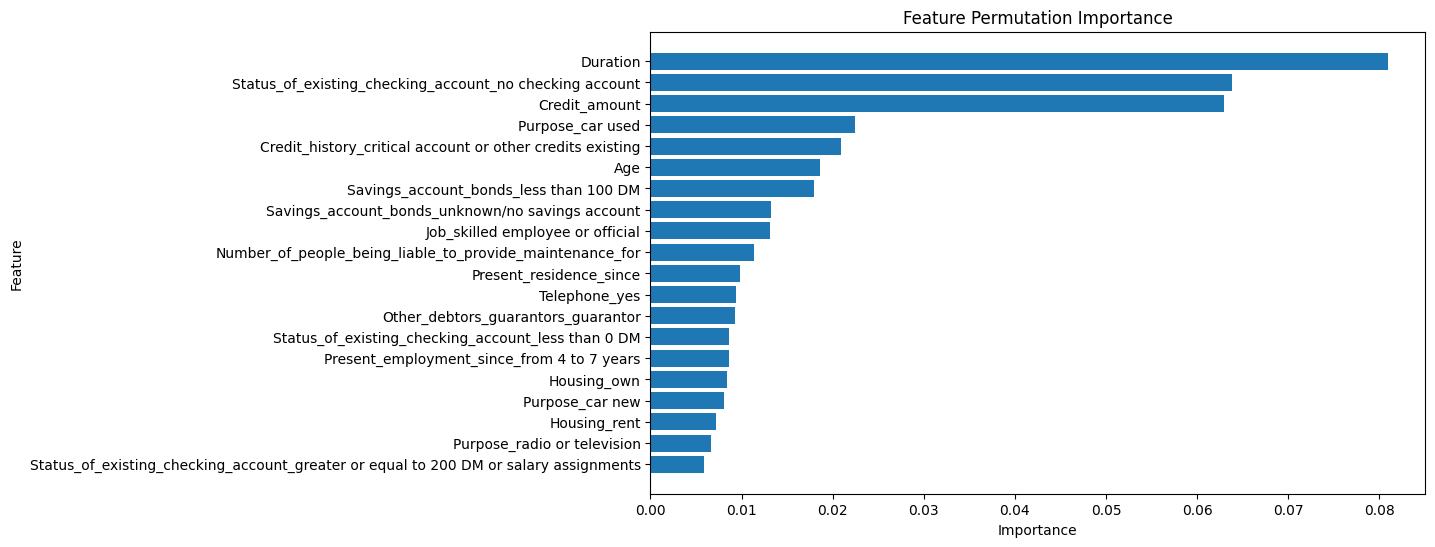

In [ ]:
plot_feat_permut_importance(xgb_feat_permut_import_df)

In [ ]:
xgb_perf, xgb_orig_missing, xgb_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Duration
Original feat removed so far:  ['Duration']

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Duration', 'Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Credit_amount
Original feat removed so far:  ['Duration', 'Status_of_existing_checking_account', 'Credit_amount']

--- NEW ITERATION ---
Removing feature:  Purpose_car used
Removing related features:  ['Purpose_car new', 'Purpose_car used', 'Purpose_domestic appliances', 'Purpose_education', 'Purpose_furniture or equipment', 'Purpose_others', 'Purpose_radio or television', 'Purpose_repairs', 'Purpose_retraining']
Original feat removed so far:  ['Du

In [ ]:
xgb_perf

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   46  102   38  14      54.76   76.67        72.86      74.0     63.89   
1   46   99   41  14      52.87   76.67        70.71      72.5     62.59   
2   49   76   64  11      43.36   81.67        54.29      62.5     56.65   
3   37   94   46  23      44.58   61.67        67.14      65.5     51.75   
4   39   89   51  21      43.33   65.00        63.57      64.0     52.00   
5   38   75   65  22      36.89   63.33        53.57      56.5     46.63   
6   42   67   73  18      36.52   70.00        47.86      54.5     48.00   
7   49   38  102  11      32.45   81.67        27.14      43.5     46.45   
8   53   30  110   7      32.52   88.33        21.43      41.5     47.53   
9   51   37  103   9      33.12   85.00        26.43      44.0     47.66   
10  50   37  103  10      32.68   83.33        26.43      43.5     46.95   
11  51   33  107   9      32.28   85.00        23.57      42.0     46.79   
12  52   28  112   8      31.71   86.67        20.00      40.0     46.43   
13  56   20  120   4      31.82   93.33        14.29      38.0     47.46   
14  55   26  114   5      32.54   91.67        18.57      40.5     48.03   
15  53   31  109   7      32.72   88.33        22.14      42.0     47.75   
16  53   30  110   7      32.52   88.33        21.43      41.5     47.53   
17  54   28  112   6      32.53   90.00        20.00      41.0     47.79   
18  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               74.76                 0   
1               73.69                 1   
2               67.98                 2   
3               64.40                 3   
4               64.29                 4   
5               58.45                 5   
6               58.93                 6   
7               54.40                 7   
8               54.88                 8   
9               55.71                 9   
10              54.88                10   
11              54.29                11   
12              53.33                12   
13              53.81                13   
14              55.12                14   
15              55.24                15   
16              54.88                16   
17              55.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                                ['Duration'] imputed  
2   ['Duration', 'Status_of_existing_checking_acco...  
3   ['Duration', 'Status_of_existing_checking_acco...  
4   ['Duration', 'Status_of_existing_checking_acco...  
5   ['Duration', 'Status_of_existing_checking_acco...  
6   ['Duration', 'Status_of_existing_checking_acco...  
7   ['Duration', 'Status_of_existing_checking_acco...  
8   ['Duration', 'Status_of_existing_checking_acco...  
9   ['Duration', 'Status_of_existing_checking_acco...  
10  ['Duration', 'Status_of_existing_checking_acco...  
11  ['Duration', 'Status_of_existing_checking_acco...  
12  ['Duration', 'Status_of_existing_checking_acco...  
13  ['Duration', 'Status_of_existing_checking_acco...  
14  ['Duration', 'Status_of_existing_checking_acco...  
15  ['Duration', 'Status_of_existing_checking_acco...  
16  ['Duration', 'Status_of_existing_checking_acco...  
17  ['Duration', 'Status_of_existing_checking_acco...  
18  ['Duration', 'Status_of_existing_checking_acco...  
19  ['Duration', 'Status_of_existing_checking_acco...  
20  ['Duration', 'Status_of_existing_checking_acco...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb_perf_mf, xgb_orig_missing_mf, xgb_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 01:27:24.087082

--- NEW ITERATION ---
Removing feature:  Duration
Nr. columns with nan:  1
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Credit_history_existing credits paid back duly till now', 'Credit_history_no credits taken or all credits paid back duly', 'Purpose_car new', 'Purpose_car used', 'Purpose_domestic appliances', 'Purpose_education', 'Purpose_furniture or equipment', 'Purpose_others', 'Purpose_radio

In [ ]:
xgb_perf_mf

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   46  102   38  14      54.76   76.67        72.86      74.0     63.89   
1   47   98   42  13      52.81   78.33        70.00      72.5     63.09   
2   44   85   55  16      44.44   73.33        60.71      64.5     55.35   
3   36   97   43  24      45.57   60.00        69.29      66.5     51.80   
4   38   87   53  22      41.76   63.33        62.14      62.5     50.33   
5   39   74   66  21      37.14   65.00        52.86      56.5     47.27   
6   43   69   71  17      37.72   71.67        49.29      56.0     49.43   
7   48   50   90  12      34.78   80.00        35.71      49.0     48.48   
8   46   45   95  14      32.62   76.67        32.14      45.5     45.77   
9   45   45   95  15      32.14   75.00        32.14      45.0     45.00   
10  47   39  101  13      31.76   78.33        27.86      43.0     45.19   
11  50   30  110  10      31.25   83.33        21.43      40.0     45.45   
12  49   30  110  11      30.82   81.67        21.43      39.5     44.75   
13  53   32  108   7      32.92   88.33        22.86      42.5     47.96   
14  51   33  107   9      32.28   85.00        23.57      42.0     46.79   
15  49   31  109  11      31.01   81.67        22.14      40.0     44.95   
16  57    8  132   3      30.16   95.00         5.71      32.5     45.78   
17  57    3  137   3      29.38   95.00         2.14      30.0     44.88   
18  55    8  132   5      29.41   91.67         5.71      31.5     44.53   
19  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               74.76                 0   
1               74.17                 1   
2               67.02                 2   
3               64.64                 3   
4               62.74                 4   
5               58.93                 5   
6               60.48                 6   
7               57.86                 7   
8               54.40                 8   
9               53.57                 9   
10              53.10                10   
11              52.38                11   
12              51.55                12   
13              55.60                13   
14              54.29                14   
15              51.90                15   
16              50.36                16   
17              48.57                17   
18              48.69                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                                ['Duration'] imputed  
2   ['Duration', 'Status_of_existing_checking_acco...  
3   ['Duration', 'Status_of_existing_checking_acco...  
4   ['Duration', 'Status_of_existing_checking_acco...  
5   ['Duration', 'Status_of_existing_checking_acco...  
6   ['Duration', 'Status_of_existing_checking_acco...  
7   ['Duration', 'Status_of_existing_checking_acco...  
8   ['Duration', 'Status_of_existing_checking_acco...  
9   ['Duration', 'Status_of_existing_checking_acco...  
10  ['Duration', 'Status_of_existing_checking_acco...  
11  ['Duration', 'Status_of_existing_checking_acco...  
12  ['Duration', 'Status_of_existing_checking_acco...  
13  ['Duration', 'Status_of_existing_checking_acco...  
14  ['Duration', 'Status_of_existing_checking_acco...  
15  ['Duration', 'Status_of_existing_checking_acco...  
16  ['Duration', 'Status_of_existing_checking_acco...  
17  ['Duration', 'Status_of_existing_checking_acco...  
18  ['Duration', 'Status_of_existing_checking_acco...  
19  ['Duration', 'Status_of_existing_checking_acco...  
20  ['Duration', 'Status_of_existing_checking_acco...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.05, 0.01, 2],
      'min_samples_leaf': [0.05, 0.01, 1]
  }
else:
  # best model
  et_param_grid = {
    'n_estimators': [200],
    'max_depth': [5],
    'max_features':['sqrt'],
    'min_samples_split': [0.05],
    'min_samples_leaf': [0.05],
}

et_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et_grid_search, et_best_model, et_best_params = hyperparameter_tuning(
    et_classifier, et_param_grid, 5, 5, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-19 01:30:13.161374

Nested Cross-validation Results:
Individual scores: [0.55357143 0.58914729 0.5862069  0.58333333 0.60869565]
Average nested CV score: 0.584 (+/- 0.035)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 0.05, 'min_samples_split': 0.05, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.584

Train score: 0.614
Test score: 0.584
Train-test score difference: 0.030
2025-01-19 01:30:15.868788

Execution time: 0.05 minutes


```
Starting hyperparameter tuning at: 2025-01-14 23:42:56.565180

Nested Cross-validation Results:
Individual scores: [0.52336449 0.578125   0.53913043 0.57377049 0.62608696]
Average nested CV score: 0.568 (+/- 0.071)

Fitting final model on entire dataset...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 0.05, 'min_samples_split': 0.05, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.584

Train score: 0.614
Test score: 0.584
Train-test score difference: 0.030
2025-01-15 00:10:50.783895

Execution time: 27.90 minutes
```




In [ ]:
# et_grid_search.cv_results_

In [ ]:
et_classifier, train_pred, test_pred = apply_model(et_best_model, X_train, y_train, X_test, y_test)
et_feat_permut_import_df = analyze_feat_permut_import(et_classifier, X_train, y_train, scoring_metric="f1")
et_feat_permut_import_df[et_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
11  Status_of_existing_checking_account_no checkin...    0.044629  0.007995
27             Savings_account_bonds_less than 100 DM    0.025068  0.007497
0                                            Duration    0.017032  0.004293
39                               Property_real estate    0.016950  0.004072
12  Credit_history_critical account or other credi...    0.014128  0.008744
10  Status_of_existing_checking_account_less than ...    0.012626  0.004590
43                                        Housing_own    0.010762  0.002443
22                        Purpose_radio or television    0.008866  0.004212
28   Savings_account_bonds_unknown/no savings account    0.008138  0.003334
16                                    Purpose_car new    0.006828  0.003716
35                Personal_status_and_sex_male single    0.006486  0.004619
44                                       Housing_rent    0.005892  0.001736
2   Installment_rate_in_percentage_of_disposable_i...    0.003393  0.001532
29         Present_employment_since_from 4 to 7 years    0.002977  0.002703
41                       Other_installment_plans_none    0.002765  0.000510
17                                   Purpose_car used    0.002664  0.001950
7                                       Telephone_yes    0.002401  0.002031
30  Present_employment_since_greater or equal to 7...    0.002087  0.002421
26  Savings_account_bonds_greater or equal to 1000 DM    0.001982  0.001149
40                    Property_unknown or no property    0.001616  0.001818
38                              Property_car or other    0.001201  0.000453
36                 Other_debtors_guarantors_guarantor    0.000835  0.000418
5             Number_of_existing_credits_at_this_bank    0.000468  0.001516
37                      Other_debtors_guarantors_none    0.000417  0.000836
19                                  Purpose_education    0.000209  0.000418
20                     Purpose_furniture or equipment   -0.000417  0.001569
31          Present_employment_since_less than 1 year   -0.000420  0.000837
45                   Job_skilled employee or official   -0.000423  0.002832
3                             Present_residence_since   -0.000466  0.001754
14  Credit_history_existing credits paid back duly...   -0.000467  0.001876
4                                                 Age   -0.000528  0.001678
1                                       Credit_amount   -0.000628  0.000513
47                           Job_unskilled - resident   -0.002128  0.001738
9   Status_of_existing_checking_account_greater or...   -0.002550  0.000420

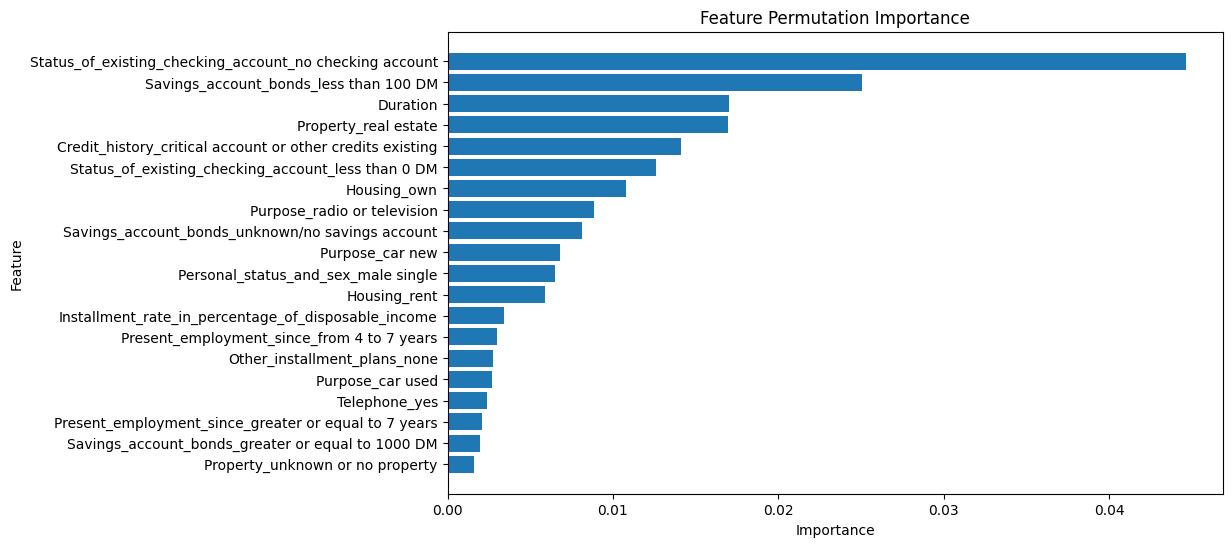

In [ ]:
plot_feat_permut_importance(et_feat_permut_import_df)

In [ ]:
et_perf, et_orig_missing, et_missing = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Savings_account_bonds_less than 100 DM
Removing related features:  ['Savings_account_bonds_from 500 to 1000 DM', 'Savings_account_bonds_greater or equal to 1000 DM', 'Savings_account_bonds_less than 100 DM', 'Savings_account_bonds_unknown/no savings account']
Original feat removed so far:  ['Status_of_existing_checking_account', 'Savings_account_bonds']

--- NEW ITERATION ---
Removing feature:  Duration
Original feat removed so far:  ['Status_of_existing_checking_account', 'Savings_account_bonds', 'Duration']

--- NEW ITERATION ---
Removing feature:  Pr

In [ ]:
et_perf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   49  92   48  11      50.52   81.67        65.71      70.5     62.42   
1   51  77   63   9      44.74   85.00        55.00      64.0     58.62   
2   55  48   92   5      37.41   91.67        34.29      51.5     53.14   
3   55  43   97   5      36.18   91.67        30.71      49.0     51.89   
4   56  39  101   4      35.67   93.33        27.86      47.5     51.61   
5   60   1  139   0      30.15  100.00         0.71      30.5     46.33   
6   60   1  139   0      30.15  100.00         0.71      30.5     46.33   
7   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
8   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
9   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
10  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
11  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
12  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
13  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
14  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
15  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               73.69                 0   
1               70.00                 1   
2               62.98                 2   
3               61.19                 3   
4               60.60                 4   
5               50.36                 5   
6               50.36                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et_perf_mf, et_orig_missing_mf, et_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 01:30:17.939996

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
et_perf_mf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   49  92   48  11      50.52   81.67        65.71      70.5     62.42   
1   43  74   66  17      39.45   71.67        52.86      58.5     50.89   
2   50  51   89  10      35.97   83.33        36.43      50.5     50.25   
3   50  47   93  10      34.97   83.33        33.57      48.5     49.26   
4   55  32  108   5      33.74   91.67        22.86      43.5     49.33   
5   56  17  123   4      31.28   93.33        12.14      36.5     46.86   
6   51  19  121   9      29.65   85.00        13.57      35.0     43.97   
7   52  11  129   8      28.73   86.67         7.86      31.5     43.15   
8   50   9  131  10      27.62   83.33         6.43      29.5     41.49   
9   50   9  131  10      27.62   83.33         6.43      29.5     41.49   
10  57   4  136   3      29.53   95.00         2.86      30.5     45.06   
11  59   2  138   1      29.95   98.33         1.43      30.5     45.91   
12  59   2  138   1      29.95   98.33         1.43      30.5     45.91   
13  59   2  138   1      29.95   98.33         1.43      30.5     45.91   
14  59   2  138   1      29.95   98.33         1.43      30.5     45.91   
15  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               73.69                 0   
1               62.26                 1   
2               59.88                 2   
3               58.45                 3   
4               57.26                 4   
5               52.74                 5   
6               49.29                 6   
7               47.26                 7   
8               44.88                 8   
9               44.88                 9   
10              48.93                10   
11              49.88                11   
12              49.88                12   
13              49.88                13   
14              49.88                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

##**Support Vector Classifier**

In [ ]:
# scale data with MinMax
X_train_scaled, german_scaler = scale_minmax_features(X_train, mode="train", scaler = None)
X_test_scaled, _ = scale_minmax_features(X_test, mode="test", scaler = german_scaler)

In [ ]:
german_imputation_scaled_values_dict = calculate_imputation_values_for_missing(X_train_scaled)

In [ ]:
german_imputation_scaled_values_dict

{'Duration': 0.24999999999999997,
 'Credit_amount': 0.11329371629800815,
 'Installment_rate_in_percentage_of_disposable_income': 0.6666666666666667,
 'Present_residence_since': 0.6666666666666667,
 'Age': 0.25000000000000006,
 'Number_of_existing_credits_at_this_bank': 0.0,
 'Number_of_people_being_liable_to_provide_maintenance_for': 0.0,
 'Telephone_yes': 0.0,
 'Foreign_worker_yes': 1.0,
 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments': 0.0,
 'Status_of_existing_checking_account_less than 0 DM': 0.0,
 'Status_of_existing_checking_account_no checking account': 0.0,
 'Credit_history_critical account or other credits existing': 0.0,
 'Credit_history_delay in paying off in the past': 0.0,
 'Credit_history_existing credits paid back duly till now': 1.0,
 'Credit_history_no credits taken or all credits paid back duly': 0.0,
 'Purpose_car new': 0.0,
 'Purpose_car used': 0.0,
 'Purpose_domestic appliances': 0.0,
 'Purpose_education': 0.0,
 'Purpose_furni

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm_param_grid = {
      'C': [0.1, 1, 2, 3, 5, 10, 20],
      'kernel': ['linear', 'poly', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1, 2],
      'degree': [2, 3, 4, 5]
  }
else:
  # best model
  svm_param_grid = {
    'C': [0.1],
    'kernel': ['linear'],
    'gamma': ['scale'],
    'degree': [2]
}

svm_classifier = SVC(class_weight='balanced', random_state=RANDOM_STATE)
svm_grid_search, svm_best_model, svm_best_params = hyperparameter_tuning(
    svm_classifier, svm_param_grid, 5, 5, 'f1', X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-19 01:32:59.734395

Nested Cross-validation Results:
Individual scores: [0.56363636 0.61290323 0.52727273 0.60504202 0.64912281]
Average nested CV score: 0.592 (+/- 0.084)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}

Best Model Performance:
Best CV score: 0.592

Train score: 0.634
Test score: 0.592
Train-test score difference: 0.042
2025-01-19 01:32:59.967264

Execution time: 0.00 minutes


```
Starting hyperparameter tuning at: 2025-01-14 18:07:27.125407

Nested Cross-validation Results:
Individual scores: [0.54700855 0.57894737 0.52727273 0.5840708  0.63414634]
Average nested CV score: 0.574 (+/- 0.073)

Fitting final model on entire dataset...
Fitting 5 folds for each of 420 candidates, totalling 2100 fits
Best parameters: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}

Best Model Performance:
Best CV score: 0.592

Train score: 0.634
Test score: 0.592
Train-test score difference: 0.042
2025-01-14 18:09:03.322989

Execution time: 1.60 minutes
```




In [ ]:
svm_classifier, train_pred, test_pred = apply_model(svm_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm_feat_permut_import_df = analyze_feat_permut_import(svm_classifier, X_train_scaled, y_train, scoring_metric="f1")
svm_feat_permut_import_df[svm_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
11  Status_of_existing_checking_account_no checkin...    0.036458  0.013107
0                                            Duration    0.016046  0.005970
35                Personal_status_and_sex_male single    0.014275  0.007058
12  Credit_history_critical account or other credi...    0.011541  0.009475
22                        Purpose_radio or television    0.011284  0.002508
36                 Other_debtors_guarantors_guarantor    0.010929  0.004665
29         Present_employment_since_from 4 to 7 years    0.010056  0.002796
39                               Property_real estate    0.007969  0.002598
27             Savings_account_bonds_less than 100 DM    0.006971  0.007038
33  Personal_status_and_sex_male divorced or separ...    0.006851  0.002706
4                                                 Age    0.006573  0.005418
44                                       Housing_rent    0.006455  0.002471
5             Number_of_existing_credits_at_this_bank    0.006449  0.001561
14  Credit_history_existing credits paid back duly...    0.006310  0.002108
1                                       Credit_amount    0.006237  0.004127
10  Status_of_existing_checking_account_less than ...    0.006205  0.006481
17                                   Purpose_car used    0.005110  0.003284
15  Credit_history_no credits taken or all credits...    0.005035  0.000901
37                      Other_debtors_guarantors_none    0.004788  0.002394
7                                       Telephone_yes    0.003748  0.003226
3                             Present_residence_since    0.003377  0.001785
47                           Job_unskilled - resident    0.003158  0.001357
30  Present_employment_since_greater or equal to 7...    0.002640  0.002970
8                                  Foreign_worker_yes    0.002482  0.004287
40                    Property_unknown or no property    0.002476  0.001148
46         Job_unemployed or unskilled - non-resident    0.001751  0.002227
28   Savings_account_bonds_unknown/no savings account    0.001487  0.004086
25          Savings_account_bonds_from 500 to 1000 DM    0.001323  0.001477
6   Number_of_people_being_liable_to_provide_maint...    0.001101  0.004900
43                                        Housing_own    0.000857  0.001352
13     Credit_history_delay in paying off in the past    0.000849  0.003547
9   Status_of_existing_checking_account_greater or...    0.000642  0.002435
31          Present_employment_since_less than 1 year    0.000549  0.001539
32                Present_employment_since_unemployed    0.000520  0.001654
42                     Other_installment_plans_stores    0.000214  0.000428
41                       Other_installment_plans_none   -0.000192  0.002766
24                                 Purpose_retraining   -0.000215  0.000429
34    Personal_status_and_sex_male married or widowed   -0.000467  0.000935
23                                    Purpose_repairs   -0.000683  0.001524
38                              Property_car or other   -0.000898  0.000351
19                                  Purpose_education   -0.001013  0.001949
26  Savings_account_bonds_greater or equal to 1000 DM   -0.001032  0.004176
21                                     Purpose_others   -0.001074  0.000680
45                   Job_skilled employee or official   -0.001192  0.002223
2   Installment_rate_in_percentage_of_disposable_i...   -0.001315  0.004623
16                                    Purpose_car new   -0.003050  0.005458
20                     Purpose_furniture or equipment   -0.003088  0.002219

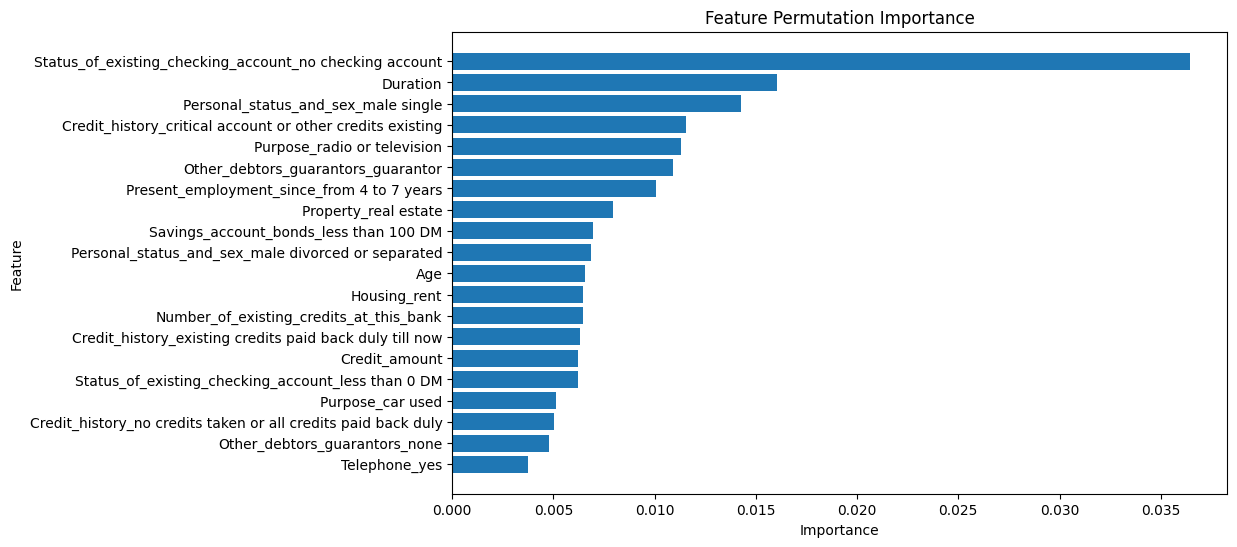

In [ ]:
plot_feat_permut_importance(svm_feat_permut_import_df)

In [ ]:
svm_perf, svm_orig_missing, svm_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    german_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Duration
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration']

--- NEW ITERATION ---
Removing feature:  Personal_status_and_sex_male single
Removing related features:  ['Personal_status_and_sex_male divorced or separated', 'Personal_status_and_sex_male married or widowed', 'Personal_status_and_sex_male single']
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration', 'Personal_status_and_sex']

--- NEW ITERATION ---
Removing feature:  Credit_history_critical account or other credits existing
Removi

In [ ]:
svm_perf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   52  98   42   8      55.32   86.67        70.00      75.0     67.53   
1   51  73   67   9      43.22   85.00        52.14      62.0     57.30   
2   51  73   67   9      43.22   85.00        52.14      62.0     57.30   
3   44  84   56  16      44.00   73.33        60.00      64.0     55.00   
4   47  74   66  13      41.59   78.33        52.86      60.5     54.34   
5   48  70   70  12      40.68   80.00        50.00      59.0     53.93   
6   48  67   73  12      39.67   80.00        47.86      57.5     53.04   
7   51  53   87   9      36.96   85.00        37.86      52.0     51.52   
8   50  49   91  10      35.46   83.33        35.00      49.5     49.75   
9   58  21  119   2      32.77   96.67        15.00      39.5     48.95   
10  58  18  122   2      32.22   96.67        12.86      38.0     48.33   
11  58  22  118   2      32.95   96.67        15.71      40.0     49.15   
12  58  23  117   2      33.14   96.67        16.43      40.5     49.36   
13  55  27  113   5      32.74   91.67        19.29      41.0     48.25   
14  56  23  117   4      32.37   93.33        16.43      39.5     48.07   
15  57  15  125   3      31.32   95.00        10.71      36.0     47.11   
16  59   5  135   1      30.41   98.33         3.57      32.0     46.46   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               78.33                 0   
1               68.57                 1   
2               68.57                 2   
3               66.67                 3   
4               65.60                 4   
5               65.00                 5   
6               63.93                 6   
7               61.43                 7   
8               59.17                 8   
9               55.83                 9   
10              54.76                10   
11              56.19                11   
12              56.55                12   
13              55.48                13   
14              54.88                14   
15              52.86                15   
16              50.95                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm_perf_mf, svm_orig_missing_mf, svm_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 01:33:01.078750

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
svm_perf_mf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   52  98   42   8      55.32   86.67        70.00      75.0     67.53   
1   43  80   60  17      41.75   71.67        57.14      61.5     52.76   
2   44  79   61  16      41.90   73.33        56.43      61.5     53.33   
3   40  84   56  20      41.67   66.67        60.00      62.0     51.28   
4   42  71   69  18      37.84   70.00        50.71      56.5     49.12   
5   45  57   83  15      35.16   75.00        40.71      51.0     47.87   
6   45  56   84  15      34.88   75.00        40.00      50.5     47.62   
7   45  64   76  15      37.19   75.00        45.71      54.5     49.72   
8   44  53   87  16      33.59   73.33        37.86      48.5     46.07   
9   58   7  133   2      30.37   96.67         5.00      32.5     46.22   
10  58   7  133   2      30.37   96.67         5.00      32.5     46.22   
11  59   6  134   1      30.57   98.33         4.29      32.5     46.64   
12  59   6  134   1      30.57   98.33         4.29      32.5     46.64   
13  57   5  135   3      29.69   95.00         3.57      31.0     45.24   
14  57   5  135   3      29.69   95.00         3.57      31.0     45.24   
15  57   4  136   3      29.53   95.00         2.86      30.5     45.06   
16  59   3  137   1      30.10   98.33         2.14      31.0     46.09   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               78.33                 0   
1               64.40                 1   
2               64.88                 2   
3               63.33                 3   
4               60.36                 4   
5               57.86                 5   
6               57.50                 6   
7               60.36                 7   
8               55.60                 8   
9               50.83                 9   
10              50.83                10   
11              51.31                11   
12              51.31                12   
13              49.29                13   
14              49.29                14   
15              48.93                15   
16              50.24                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

##**Logistic Regression**##

**Data pre-processing:** It is highly recommended to mitigate as much as possible the presence of multicollinearity between features before applying Logistic regression.

In [ ]:
present_features = list(X_train_scaled.columns) + ['Target']
filtered_german_dist_corr = german_dist_corr[present_features]
filtered_german_dist_corr = filtered_german_dist_corr[filtered_german_dist_corr.index.isin(present_features)]
filtered_feat = filter_out_intercorrelated_features(filtered_german_dist_corr, 'Target', 0.8)

appended feature:  Status_of_existing_checking_account_no checking account
appended feature:  Status_of_existing_checking_account_less than 0 DM
appended feature:  Duration
appended feature:  Savings_account_bonds_less than 100 DM
appended feature:  Credit_history_critical account or other credits existing
appended feature:  Credit_history_no credits taken or all credits paid back duly
appended feature:  Savings_account_bonds_unknown/no savings account
appended feature:  Housing_own
appended feature:  Credit_amount
appended feature:  Purpose_radio or television
appended feature:  Housing_rent
appended feature:  Age
appended feature:  Present_employment_since_less than 1 year
appended feature:  Property_unknown or no property
appended feature:  Property_real estate
appended feature:  Purpose_car new
appended feature:  Purpose_car used
appended feature:  Other_installment_plans_none
appended feature:  Personal_status_and_sex_male single
appended feature:  Foreign_worker_yes
appended feat

In [ ]:
lr_X_train = X_train_scaled[filtered_feat]
lr_X_test = X_test_scaled[filtered_feat]
print('Nr features for LR: ', len(lr_X_train.columns))

Nr features for LR:  48


In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],            # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']         # Algorithm for optimization
  }
else:
  # best model
  lr_param_grid = {
    'C': [0.1],
    'penalty': ['l2'],
    'solver': ['saga']
}

lr_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr_grid_search, lr_best_model, lr_best_params = hyperparameter_tuning(
    lr_classifier, lr_param_grid, 5, 5, 'f1', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-19 01:35:43.628453

Nested Cross-validation Results:
Individual scores: [0.54867257 0.63333333 0.55357143 0.57142857 0.66666667]
Average nested CV score: 0.595 (+/- 0.094)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}

Best Model Performance:
Best CV score: 0.595

Train score: 0.620
Test score: 0.595
Train-test score difference: 0.025
2025-01-19 01:35:43.855773

Execution time: 0.00 minutes


```
Starting hyperparameter tuning at: 2025-01-15 00:10:50.792763

Nested Cross-validation Results:
Individual scores: [0.55855856 0.59130435 0.56363636 0.58928571 0.64347826]
Average nested CV score: 0.589 (+/- 0.060)

Fitting final model on entire dataset...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}

Best Model Performance:
Best CV score: 0.595

Train score: 0.620
Test score: 0.595
Train-test score difference: 0.025
2025-01-15 00:10:55.757002

Execution time: 0.08 minutes
```




In [ ]:
lr_classifier, train_pred, test_pred = apply_model(lr_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr_feat_permut_import_df = analyze_feat_permut_import(lr_classifier, lr_X_train, y_train, scoring_metric="f1")
lr_feat_permut_import_df[lr_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0   Status_of_existing_checking_account_no checkin...    0.029382  0.013161
16                                   Purpose_car used    0.010887  0.004163
18                Personal_status_and_sex_male single    0.010259  0.007176
4   Credit_history_critical account or other credi...    0.009256  0.015167
3              Savings_account_bonds_less than 100 DM    0.007870  0.010735
36                           Job_unskilled - resident    0.006006  0.002631
2                                            Duration    0.005251  0.002860
5   Credit_history_no credits taken or all credits...    0.004777  0.003869
22         Present_employment_since_from 4 to 7 years    0.004332  0.002949
11                                                Age    0.003886  0.002582
30  Status_of_existing_checking_account_greater or...    0.003107  0.002497
13                    Property_unknown or no property    0.002757  0.003511
9                         Purpose_radio or television    0.002673  0.006724
27                 Other_debtors_guarantors_guarantor    0.002047  0.003234
10                                       Housing_rent    0.001593  0.003178
1   Status_of_existing_checking_account_less than ...    0.001212  0.007105
34                                 Purpose_retraining    0.000844  0.000422
46         Job_unemployed or unskilled - non-resident    0.000790  0.002330
47                                     Purpose_others    0.000422  0.000517
28  Personal_status_and_sex_male divorced or separ...    0.000316  0.002247
42                      Other_debtors_guarantors_none    0.000265  0.000854
23                                  Purpose_education    0.000255  0.002616
35                                    Purpose_repairs   -0.000053  0.000753
26  Present_employment_since_greater or equal to 7...   -0.000112  0.001464
8                                       Credit_amount   -0.000467  0.004046
21                Present_employment_since_unemployed   -0.000584  0.001425
31            Number_of_existing_credits_at_this_bank   -0.000845  0.001865
38    Personal_status_and_sex_male married or widowed   -0.000849  0.002455
25          Savings_account_bonds_from 500 to 1000 DM   -0.001059  0.000671
29  Credit_history_existing credits paid back duly...   -0.001111  0.002448
19                                 Foreign_worker_yes   -0.001118  0.003149
43  Number_of_people_being_liable_to_provide_maint...   -0.001277  0.002913
7                                         Housing_own   -0.001375  0.001309
39     Credit_history_delay in paying off in the past   -0.001798  0.001392
20  Savings_account_bonds_greater or equal to 1000 DM   -0.001803  0.002579
40                            Present_residence_since   -0.002082  0.005339
14                               Property_real estate   -0.002115  0.002711
33                                      Telephone_yes   -0.003405  0.004962
6    Savings_account_bonds_unknown/no savings account   -0.003410  0.005602
15                                    Purpose_car new   -0.004014  0.002459
12          Present_employment_since_less than 1 year   -0.004411  0.004338
24  Installment_rate_in_percentage_of_disposable_i...   -0.004858  0.002227
17                       Other_installment_plans_none   -0.004978  0.005161
41                     Purpose_furniture or equipment   -0.007296  0.004057

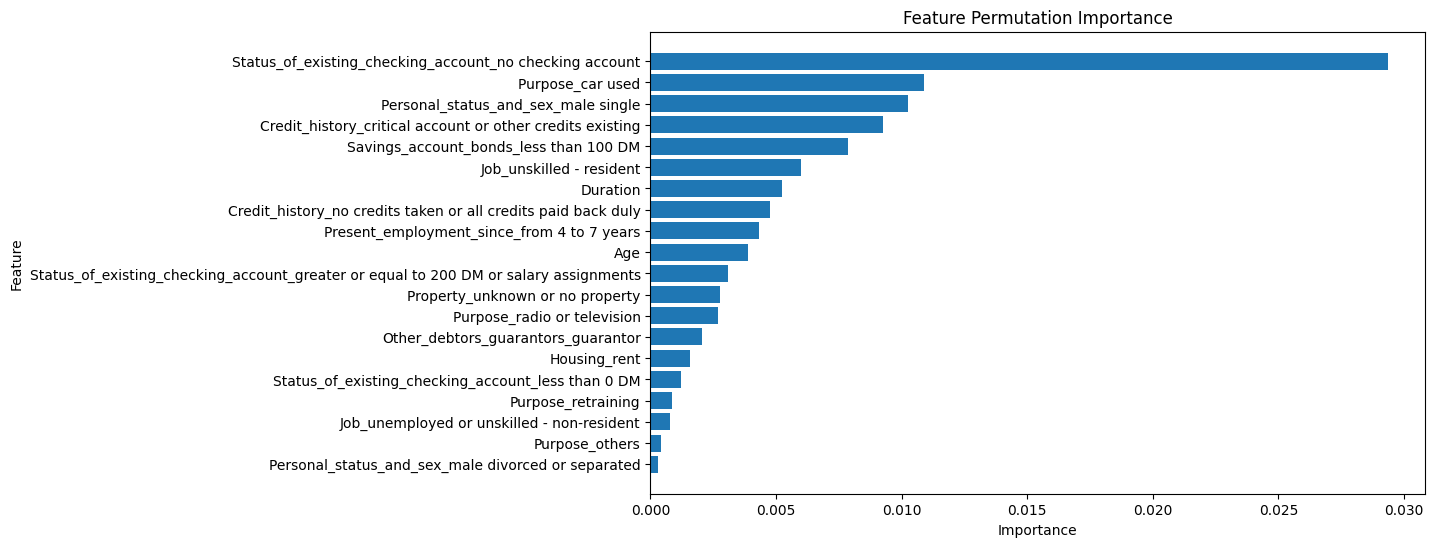

In [ ]:
plot_feat_permut_importance(lr_feat_permut_import_df)

In [ ]:
lr_perf, lr_orig_missing, lr_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    german_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Purpose_car used
Removing related features:  ['Purpose_car new', 'Purpose_car used', 'Purpose_domestic appliances', 'Purpose_education', 'Purpose_furniture or equipment', 'Purpose_others', 'Purpose_radio or television', 'Purpose_repairs', 'Purpose_retraining']
Original feat removed so far:  ['Status_of_existing_checking_account', 'Purpose']

--- NEW ITERATION ---
Removing feature:  Personal_status_and_sex_male single
Removing related features:  ['Personal_status_and_sex_male divorced or separated', 'Personal_status_and_sex_male married or widowed', 'Per

In [ ]:
lr_perf

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   50  102   38  10      56.82   83.33        72.86      76.0     67.57   
1   51   80   60   9      45.95   85.00        57.14      65.5     59.65   
2   50   75   65  10      43.48   83.33        53.57      62.5     57.14   
3   47   91   49  13      48.96   78.33        65.00      69.0     60.26   
4   50   71   69  10      42.02   83.33        50.71      60.5     55.87   
5   57   46   94   3      37.75   95.00        32.86      51.5     54.03   
6   57   45   95   3      37.50   95.00        32.14      51.0     53.77   
7   58   45   95   2      37.91   96.67        32.14      51.5     54.46   
8   59   33  107   1      35.54   98.33        23.57      46.0     52.21   
9   58   32  108   2      34.94   96.67        22.86      45.0     51.33   
10  58   23  117   2      33.14   96.67        16.43      40.5     49.36   
11  58   18  122   2      32.22   96.67        12.86      38.0     48.33   
12  58   24  116   2      33.33   96.67        17.14      41.0     49.57   
13  57   25  115   3      33.14   95.00        17.86      41.0     49.14   
14  52   27  113   8      31.52   86.67        19.29      39.5     46.22   
15  52   28  112   8      31.71   86.67        20.00      40.0     46.43   
16  52   23  117   8      30.77   86.67        16.43      37.5     45.41   
17  51   26  114   9      30.91   85.00        18.57      38.5     45.33   
18  50   34  106  10      32.05   83.33        24.29      42.0     46.30   
19  53   21  119   7      30.81   88.33        15.00      37.0     45.69   
20  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               78.10                 0   
1               71.07                 1   
2               68.45                 2   
3               71.67                 3   
4               67.02                 4   
5               63.93                 5   
6               63.57                 6   
7               64.40                 7   
8               60.95                 8   
9               59.76                 9   
10              56.55                10   
11              54.76                11   
12              56.90                12   
13              56.43                13   
14              52.98                14   
15              53.33                15   
16              51.55                16   
17              51.79                17   
18              53.81                18   
19              51.67                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
lr_X_train.columns

Index(['Status_of_existing_checking_account_no checking account',
       'Status_of_existing_checking_account_less than 0 DM', 'Duration',
       'Savings_account_bonds_less than 100 DM',
       'Credit_history_critical account or other credits existing',
       'Credit_history_no credits taken or all credits paid back duly',
       'Savings_account_bonds_unknown/no savings account', 'Housing_own',
       'Credit_amount', 'Purpose_radio or television', 'Housing_rent', 'Age',
       'Present_employment_since_less than 1 year',
       'Property_unknown or no property', 'Property_real estate',
       'Purpose_car new', 'Purpose_car used', 'Other_installment_plans_none',
       'Personal_status_and_sex_male single', 'Foreign_worker_yes',
       'Savings_account_bonds_greater or equal to 1000 DM',
       'Present_employment_since_unemployed',
       'Present_employment_since_from 4 to 7 years', 'Purpose_education',
       'Installment_rate_in_percentage_of_disposable_income',
       'Saving

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr_german_cat_vars = [col for col in lr_X_train.columns if col in german_cat_vars]

lr_perf_mf, lr_orig_missing_mf, lr_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=lr_german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 01:35:44.716619

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Age', 'Installment_rate_in_percentage_of_disposable_income', 'Number_of_existing_credits_at_this_bank', 'Present_residence_since']
Categorical columns:  ['Status_of_existing_checking_account_no checking account', 'Status_of_existing_checking_account_less than 0 DM', 'Savings_account_bonds_less than 100 DM', 'Credit_history_critical account or other credits existing', 'Credit_history_no credits taken or all credits paid back duly', 'Savings_account_bonds_unknown/no savings account', 'Housing_own', 'Purpose_radio or television', 'Housing_rent', 'Present_employment_

In [ ]:
lr_perf_mf

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   50  102   38  10      56.82   83.33        72.86      76.0     67.57   
1   34  107   33  26      50.75   56.67        76.43      70.5     53.54   
2   35  104   36  25      49.30   58.33        74.29      69.5     53.44   
3   34  108   32  26      51.52   56.67        77.14      71.0     53.97   
4   33  103   37  27      47.14   55.00        73.57      68.0     50.77   
5   36   92   48  24      42.86   60.00        65.71      64.0     50.00   
6   34   90   50  26      40.48   56.67        64.29      62.0     47.22   
7   35   89   51  25      40.70   58.33        63.57      62.0     47.95   
8   28   97   43  32      39.44   46.67        69.29      62.5     42.75   
9   30   97   43  30      41.10   50.00        69.29      63.5     45.11   
10  26   90   50  34      34.21   43.33        64.29      58.0     38.24   
11  28   89   51  32      35.44   46.67        63.57      58.5     40.29   
12  31   76   64  29      32.63   51.67        54.29      53.5     40.00   
13  43   63   77  17      35.83   71.67        45.00      53.0     47.78   
14  35   65   75  25      31.82   58.33        46.43      50.0     41.18   
15  35   65   75  25      31.82   58.33        46.43      50.0     41.18   
16  35   62   78  25      30.97   58.33        44.29      48.5     40.46   
17  36   61   79  24      31.30   60.00        43.57      48.5     41.14   
18  36   61   79  24      31.30   60.00        43.57      48.5     41.14   
19  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               78.10                 0   
1               66.55                 1   
2               66.31                 2   
3               66.90                 3   
4               64.29                 4   
5               62.86                 5   
6               60.48                 6   
7               60.95                 7   
8               57.98                 8   
9               59.64                 9   
10              53.81                10   
11              55.12                11   
12              52.98                12   
13              58.33                13   
14              52.38                14   
15              52.38                15   
16              51.31                16   
17              51.79                17   
18              51.79                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

# **Models optimized for Balanced Accuracy**

## **Decision Tree**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt2_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 2],  # last option reflects num of samples instead of proportion
      'min_samples_leaf': [0.2, 0.1, 0.05, 0.01, 0.005, 1]    # last option reflects num of samples instead of proportion
  }
else:
  # best model
  dt2_param_grid = {
      'max_depth': [3],
      'min_samples_split': [0.2],
      'min_samples_leaf': [0.1],
  }

dt2_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt2_grid_search, dt2_best_model, dt2_best_params = hyperparameter_tuning(dt2_classifier, dt2_param_grid, 5, 5, 'balanced_accuracy', X_train, y_train)

Starting hyperparameter tuning at: 2025-01-19 01:38:34.188799

Nested Cross-validation Results:
Individual scores: [0.66220238 0.64583333 0.67261905 0.70089286 0.70238095]
Average nested CV score: 0.677 (+/- 0.044)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 3, 'min_samples_leaf': 0.1, 'min_samples_split': 0.2}

Best Model Performance:
Best CV score: 0.677

Train score: 0.694
Test score: 0.677
Train-test score difference: 0.018
2025-01-19 01:38:34.378321

Execution time: 0.00 minutes


```
Starting hyperparameter tuning at: 2025-01-15 00:10:55.765120

Nested Cross-validation Results:
Individual scores: [0.64434524 0.64583333 0.63839286 0.69047619 0.70238095]
Average nested CV score: 0.664 (+/- 0.053)

Fitting final model on entire dataset...
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters: {'max_depth': 3, 'min_samples_leaf': 0.1, 'min_samples_split': 0.2}

Best Model Performance:
Best CV score: 0.677

Train score: 0.694
Test score: 0.677
Train-test score difference: 0.018
2025-01-15 00:11:16.678312

Execution time: 0.35 minutes
```

In [ ]:
dt2_classifier, dt2_train_pred, dt2_test_pred = apply_model(dt2_best_model, X_train, y_train, X_test, y_test)
dt2_feat_permut_import_df = analyze_feat_permut_import(dt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
dt2_feat_permut_import_df[dt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
11  Status_of_existing_checking_account_no checkin...    0.139107  0.019474
0                                            Duration    0.060655  0.014342

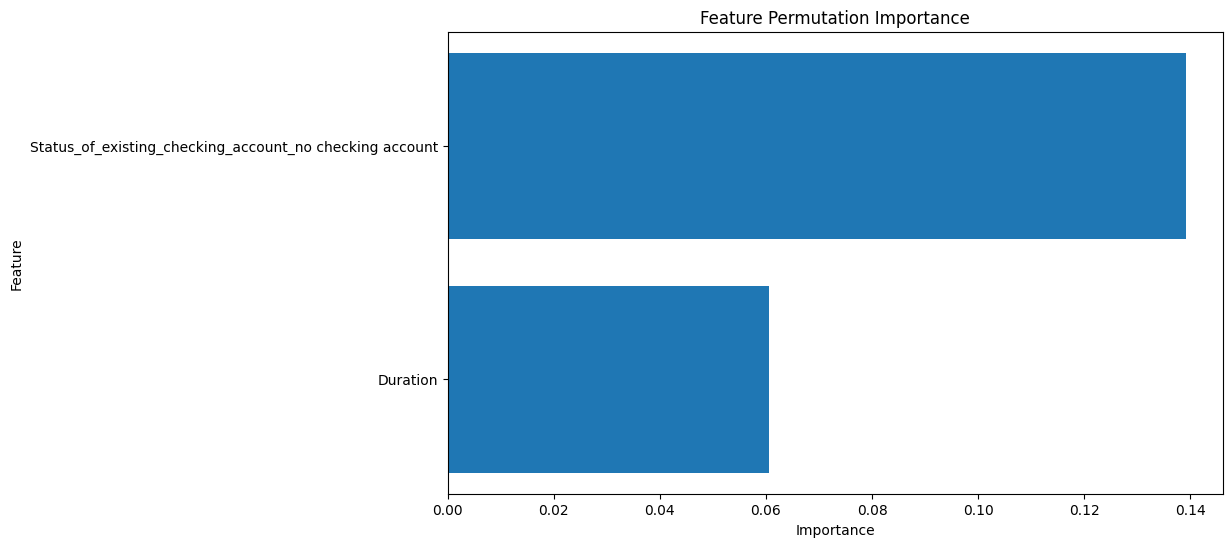

In [ ]:
plot_feat_permut_importance(dt2_feat_permut_import_df)

In [ ]:
dt2_perf, dt2_orig_missing, dt2_missing = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Duration
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration']

--- NEW ITERATION ---
Removing feature:  Personal_status_and_sex_male single
Removing related features:  ['Personal_status_and_sex_male divorced or separated', 'Personal_status_and_sex_male married or widowed', 'Personal_status_and_sex_male single']
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration', 'Personal_status_and_sex']

--- NEW ITERATION ---
Removing feature:  Savings_account_bonds_less than 100 DM
Removing related features

In [ ]:
dt2_perf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   50  82   58  10      46.30   83.33        58.57      66.0     59.52   
1   55  21  119   5      31.61   91.67        15.00      38.0     47.01   
2   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
3   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
4   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
5   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
6   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
7   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
8   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
9   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
10  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
11  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
12  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
13  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
14  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
15  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               70.95                 0   
1               53.33                 1   
2               50.00                 2   
3               50.00                 3   
4               50.00                 4   
5               50.00                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt2_perf_mf, dt2_orig_missing_mf, dt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 01:38:34.913486

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
dt2_perf_mf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   50  82   58  10      46.30   83.33        58.57      66.0     59.52   
1   42  65   75  18      35.90   70.00        46.43      53.5     47.46   
2   42  60   80  18      34.43   70.00        42.86      51.0     46.15   
3   40  62   78  20      33.90   66.67        44.29      51.0     44.94   
4   47  50   90  13      34.31   78.33        35.71      48.5     47.72   
5   47  49   91  13      34.06   78.33        35.00      48.0     47.47   
6   47  50   90  13      34.31   78.33        35.71      48.5     47.72   
7   49  48   92  11      34.75   81.67        34.29      48.5     48.76   
8   54  23  117   6      31.58   90.00        16.43      38.5     46.75   
9   55  21  119   5      31.61   91.67        15.00      38.0     47.01   
10  55  22  118   5      31.79   91.67        15.71      38.5     47.21   
11  55  22  118   5      31.79   91.67        15.71      38.5     47.21   
12  56  15  125   4      30.94   93.33        10.71      35.5     46.47   
13  56  13  127   4      30.60   93.33         9.29      34.5     46.09   
14  56  14  126   4      30.77   93.33        10.00      35.0     46.28   
15  56  10  130   4      30.11   93.33         7.14      33.0     45.53   
16  56  12  128   4      30.43   93.33         8.57      34.0     45.90   
17  56  12  128   4      30.43   93.33         8.57      34.0     45.90   
18  57   7  133   3      30.00   95.00         5.00      32.0     45.60   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               70.95                 0   
1               58.21                 1   
2               56.43                 2   
3               55.48                 3   
4               57.02                 4   
5               56.67                 5   
6               57.02                 6   
7               57.98                 7   
8               53.21                 8   
9               53.33                 9   
10              53.69                10   
11              53.69                11   
12              52.02                12   
13              51.31                13   
14              51.67                14   
15              50.24                15   
16              50.95                16   
17              50.95                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 2],
      'min_samples_leaf': [0.2, 0.1, 0.05, 0.01, 1]
  }
else:
  rf2_param_grid = {
    'n_estimators': [100],
    'max_features': ['sqrt'],
    'max_depth': [3],
    'min_samples_leaf': [1],
    'min_samples_split': [0.05],
}

rf2_classifier = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf2_grid_search, rf2_best_model, rf2_best_params = hyperparameter_tuning(
    rf2_classifier, rf2_param_grid, 5, 5, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-19 01:41:19.926681

Nested Cross-validation Results:
Individual scores: [0.68303571 0.72916667 0.68452381 0.70833333 0.73809524]
Average nested CV score: 0.709 (+/- 0.045)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.05, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.709

Train score: 0.747
Test score: 0.709
Train-test score difference: 0.039
2025-01-19 01:41:21.782841

Execution time: 0.03 minutes


```
Starting hyperparameter tuning at: 2025-01-15 00:11:16.686140

Nested Cross-validation Results:
Individual scores: [0.68154762 0.69047619 0.65625    0.71279762 0.7514881 ]
Average nested CV score: 0.699 (+/- 0.064)

Fitting final model on entire dataset...
Fitting 5 folds for each of 675 candidates, totalling 3375 fits
Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.05, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.709

Train score: 0.747
Test score: 0.709
Train-test score difference: 0.039
2025-01-15 00:53:09.571464

Execution time: 41.88 minutes
```




In [ ]:
rf2_classifier, rf2_train_pred, rf2_test_pred = apply_model(rf2_best_model, X_train, y_train, X_test, y_test)
rf2_feat_permut_import_df = analyze_feat_permut_import(rf2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
rf2_feat_permut_import_df[rf2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
11  Status_of_existing_checking_account_no checkin...    0.072083  0.007900
0                                            Duration    0.035417  0.011086
4                                                 Age    0.013333  0.005614
1                                       Credit_amount    0.012679  0.002378
10  Status_of_existing_checking_account_less than ...    0.011667  0.004496
27             Savings_account_bonds_less than 100 DM    0.011250  0.008739
12  Credit_history_critical account or other credi...    0.010417  0.004916
31          Present_employment_since_less than 1 year    0.004702  0.003657
15  Credit_history_no credits taken or all credits...    0.004583  0.000812
39                               Property_real estate    0.004464  0.001766
35                Personal_status_and_sex_male single    0.003631  0.001780
47                           Job_unskilled - resident    0.003571  0.000498
41                       Other_installment_plans_none    0.003333  0.002542
5             Number_of_existing_credits_at_this_bank    0.002798  0.001091
3                             Present_residence_since    0.002440  0.001969
22                        Purpose_radio or television    0.002440  0.002301
16                                    Purpose_car new    0.002440  0.000762
17                                   Purpose_car used    0.002381  0.002836
13     Credit_history_delay in paying off in the past    0.002083  0.000000
45                   Job_skilled employee or official    0.002024  0.002174
32                Present_employment_since_unemployed    0.001845  0.000985
43                                        Housing_own    0.001607  0.004678
28   Savings_account_bonds_unknown/no savings account    0.001429  0.002182
44                                       Housing_rent    0.000714  0.001888
40                    Property_unknown or no property    0.000417  0.001548
2   Installment_rate_in_percentage_of_disposable_i...    0.000238  0.001038
9   Status_of_existing_checking_account_greater or...    0.000238  0.000985
37                      Other_debtors_guarantors_none    0.000179  0.000357
25          Savings_account_bonds_from 500 to 1000 DM    0.000119  0.001391
19                                  Purpose_education   -0.000060  0.001088
33  Personal_status_and_sex_male divorced or separ...   -0.000060  0.001088
36                 Other_debtors_guarantors_guarantor   -0.000238  0.002238
7                                       Telephone_yes   -0.000357  0.000437
29         Present_employment_since_from 4 to 7 years   -0.000536  0.000714
26  Savings_account_bonds_greater or equal to 1000 DM   -0.000595  0.000729
34    Personal_status_and_sex_male married or widowed   -0.000655  0.001136
8                                  Foreign_worker_yes   -0.001190  0.001234

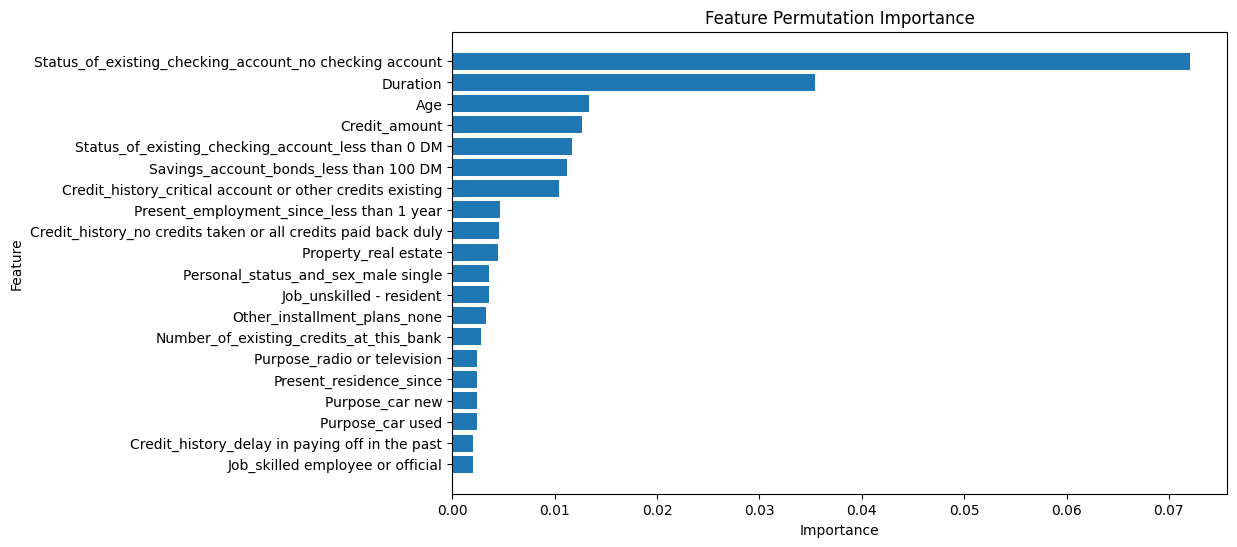

In [ ]:
plot_feat_permut_importance(rf2_feat_permut_import_df)

In [ ]:
rf2_perf, rf2_orig_missing, rf2_missing = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Duration
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration']

--- NEW ITERATION ---
Removing feature:  Age
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration', 'Age']

--- NEW ITERATION ---
Removing feature:  Credit_amount
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration', 'Age', 'Credit_amount']

--- NEW ITERATION ---

--- NEW ITERATION ---
Removing feature:  Savings_account_bonds_less than 100 DM
Removing related features:  ['Savings_account_bonds_from 500 to 

In [ ]:
rf2_perf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   50  96   44  10      53.19   83.33        68.57      73.0     64.94   
1   48  73   67  12      41.74   80.00        52.14      60.5     54.86   
2   53  58   82   7      39.26   88.33        41.43      55.5     54.36   
3   53  52   88   7      37.59   88.33        37.14      52.5     52.74   
4   50  58   82  10      37.88   83.33        41.43      54.0     52.08   
5   59  12  128   1      31.55   98.33         8.57      35.5     47.77   
6   59   1  139   1      29.80   98.33         0.71      30.0     45.74   
7   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
8   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
9   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
10  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
11  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
12  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
13  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
14  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
15  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               75.95                 0   
1               66.07                 1   
2               64.88                 2   
3               62.74                 3   
4               62.38                 4   
5               53.45                 5   
6               49.52                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf2_perf_mf, rf2_orig_missing_mf, rf2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 01:41:23.076670

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
rf2_perf_mf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   50  96   44  10      53.19   83.33        68.57      73.0     64.94   
1   38  78   62  22      38.00   63.33        55.71      58.0     47.50   
2   43  76   64  17      40.19   71.67        54.29      59.5     51.50   
3   43  75   65  17      39.81   71.67        53.57      59.0     51.19   
4   42  70   70  18      37.50   70.00        50.00      56.0     48.84   
5   50  45   95  10      34.48   83.33        32.14      47.5     48.78   
6   53  26  114   7      31.74   88.33        18.57      39.5     46.70   
7   54  24  116   6      31.76   90.00        17.14      39.0     46.96   
8   57  14  126   3      31.15   95.00        10.00      35.5     46.91   
9   57  20  120   3      32.20   95.00        14.29      38.5     48.10   
10  57  23  117   3      32.76   95.00        16.43      40.0     48.72   
11  56  28  112   4      33.33   93.33        20.00      42.0     49.12   
12  55  24  116   5      32.16   91.67        17.14      39.5     47.62   
13  56  23  117   4      32.37   93.33        16.43      39.5     48.07   
14  59   2  138   1      29.95   98.33         1.43      30.5     45.91   
15  59   3  137   1      30.10   98.33         2.14      31.0     46.09   
16  59   3  137   1      30.10   98.33         2.14      31.0     46.09   
17  59   3  137   1      30.10   98.33         2.14      31.0     46.09   
18  59   5  135   1      30.41   98.33         3.57      32.0     46.46   
19  59   5  135   1      30.41   98.33         3.57      32.0     46.46   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               75.95                 0   
1               59.52                 1   
2               62.98                 2   
3               62.62                 3   
4               60.00                 4   
5               57.74                 5   
6               53.45                 6   
7               53.57                 7   
8               52.50                 8   
9               54.64                 9   
10              55.71                10   
11              56.67                11   
12              54.40                12   
13              54.88                13   
14              49.88                14   
15              50.24                15   
16              50.24                16   
17              50.24                17   
18              50.95                18   
19              50.95                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

##**Gradient-Boosted Trees**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [40, 8, 1],
      'min_split_gain': [1, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt2_param_grid = {
    'n_estimators': [100],
    'max_depth': [4],
    'min_child_samples': [1],
    'min_split_gain': [0.5],
    'reg_lambda': [1.0]
}

gbt2_classifier = LGBMClassifier(
    objective= "binary",
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt2_grid_search, gbt2_best_model, gbt2_best_params = hyperparameter_tuning(
    gbt2_classifier, gbt2_param_grid,5, 5, 'balanced_accuracy', X_train,y_train
)

Starting hyperparameter tuning at: 2025-01-19 01:44:06.206415

Nested Cross-validation Results:
Individual scores: [0.6860119  0.74702381 0.73363095 0.74255952 0.69047619]
Average nested CV score: 0.720 (+/- 0.053)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 4, 'min_child_samples': 1, 'min_split_gain': 0.5, 'n_estimators': 100, 'reg_lambda': 1.0}

Best Model Performance:
Best CV score: 0.720

Train score: 0.936
Test score: 0.720
Train-test score difference: 0.216
2025-01-19 01:44:06.494373

Execution time: 0.00 minutes


```
Starting hyperparameter tuning at: 2025-01-15 00:53:09.580269

Nested Cross-validation Results:
Individual scores: [0.69642857 0.70684524 0.67113095 0.69642857 0.7202381 ]
Average nested CV score: 0.698 (+/- 0.032)

Fitting final model on entire dataset...
Fitting 5 folds for each of 675 candidates, totalling 3375 fits
Best parameters: {'max_depth': 4, 'min_child_samples': 1, 'min_split_gain': 0.5, 'n_estimators': 100, 'reg_lambda': 1.0}

Best Model Performance:
Best CV score: 0.720

Train score: 0.936
Test score: 0.720
Train-test score difference: 0.216
2025-01-15 00:56:20.730208

Execution time: 3.19 minutes
```




In [ ]:
gbt2_classifier, gbt2_train_pred, gbt2_test_pred = apply_model(gbt2_best_model, X_train, y_train, X_test, y_test)
gbt2_feat_permut_import_df = analyze_feat_permut_import(gbt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
gbt2_feat_permut_import_df[gbt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                                            Duration    0.112560  0.011637
1                                       Credit_amount    0.100179  0.006625
11  Status_of_existing_checking_account_no checkin...    0.093333  0.007703
4                                                 Age    0.057798  0.003748
12  Credit_history_critical account or other credi...    0.032440  0.004762
17                                   Purpose_car used    0.031548  0.004994
41                       Other_installment_plans_none    0.021548  0.003236
27             Savings_account_bonds_less than 100 DM    0.020833  0.006226
36                 Other_debtors_guarantors_guarantor    0.017262  0.002010
16                                    Purpose_car new    0.014048  0.005252
29         Present_employment_since_from 4 to 7 years    0.014048  0.003637
22                        Purpose_radio or television    0.011250  0.005275
6   Number_of_people_being_liable_to_provide_maint...    0.010476  0.003262
35                Personal_status_and_sex_male single    0.010119  0.002062
10  Status_of_existing_checking_account_less than ...    0.009821  0.003099
44                                       Housing_rent    0.009048  0.001811
32                Present_employment_since_unemployed    0.008631  0.001873
2   Installment_rate_in_percentage_of_disposable_i...    0.007917  0.001782
19                                  Purpose_education    0.007857  0.002385
31          Present_employment_since_less than 1 year    0.005714  0.002141
39                               Property_real estate    0.004464  0.003133
8                                  Foreign_worker_yes    0.004464  0.003471
15  Credit_history_no credits taken or all credits...    0.004345  0.000952
43                                        Housing_own    0.003988  0.001041
9   Status_of_existing_checking_account_greater or...    0.003274  0.001176
26  Savings_account_bonds_greater or equal to 1000 DM    0.002798  0.001391
3                             Present_residence_since    0.002500  0.001559
33  Personal_status_and_sex_male divorced or separ...    0.002440  0.000714
28   Savings_account_bonds_unknown/no savings account    0.002143  0.000714
7                                       Telephone_yes    0.002143  0.001296
40                    Property_unknown or no property    0.001726  0.001698
24                                 Purpose_retraining    0.000893  0.000000
34    Personal_status_and_sex_male married or widowed    0.000714  0.000357
30  Present_employment_since_greater or equal to 7...    0.000417  0.000833
46         Job_unemployed or unskilled - non-resident    0.000417  0.000833
23                                    Purpose_repairs    0.000417  0.000833
21                                     Purpose_others   -0.000179  0.000357
47                           Job_unskilled - resident   -0.000238  0.000985
5             Number_of_existing_credits_at_this_bank   -0.000774  0.002101

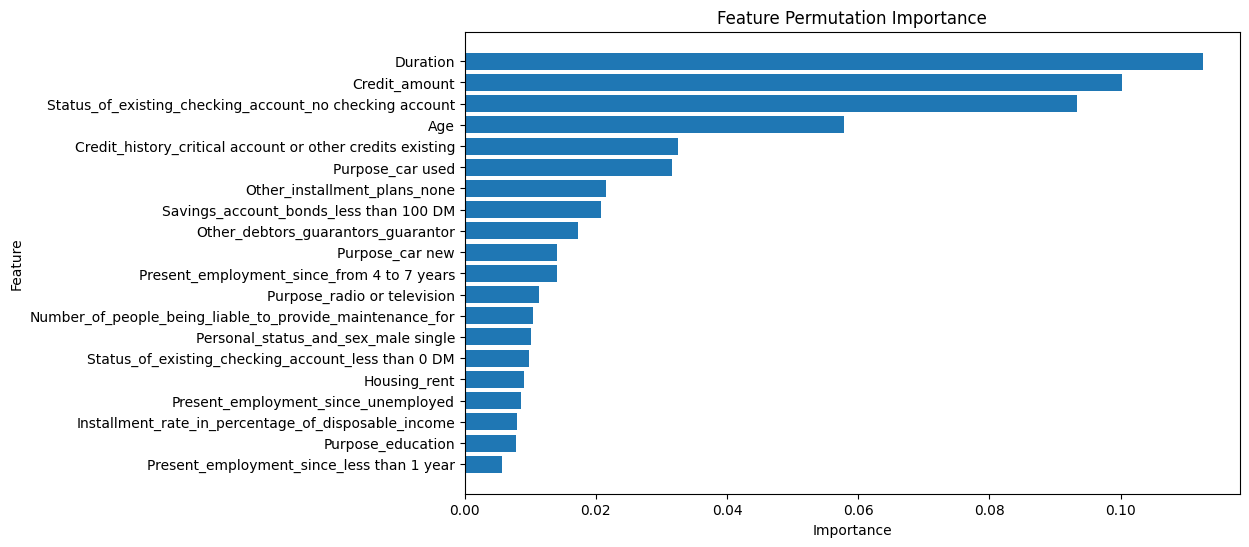

In [ ]:
plot_feat_permut_importance(gbt2_feat_permut_import_df)

In [ ]:
gbt2_perf, gbt2_orig_missing, gbt2_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Duration
Original feat removed so far:  ['Duration']

--- NEW ITERATION ---
Removing feature:  Credit_amount
Original feat removed so far:  ['Duration', 'Credit_amount']

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Duration', 'Credit_amount', 'Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Age
Original feat removed so far:  ['Duration', 'Credit_amount', 'Status_of_existing_checking_account', 'Age']

--- NEW ITERATION ---
Removing feature:  Credit_history_critical account or other credits existing
Removing related features:  ['Credit_history_critical account or other credits existing', 'Credit_history_d

In [ ]:
gbt2_perf

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   45  101   39  15      53.57   75.00        72.14      73.0     62.50   
1   44   89   51  16      46.32   73.33        63.57      66.5     56.77   
2   40   97   43  20      48.19   66.67        69.29      68.5     55.94   
3   43   86   54  17      44.33   71.67        61.43      64.5     54.78   
4   46   77   63  14      42.20   76.67        55.00      61.5     54.44   
5   44   75   65  16      40.37   73.33        53.57      59.5     52.07   
6   39   72   68  21      36.45   65.00        51.43      55.5     46.71   
7   39   72   68  21      36.45   65.00        51.43      55.5     46.71   
8   51   38  102   9      33.33   85.00        27.14      44.5     47.89   
9   52   31  109   8      32.30   86.67        22.14      41.5     47.06   
10  57   19  121   3      32.02   95.00        13.57      38.0     47.90   
11  56   23  117   4      32.37   93.33        16.43      39.5     48.07   
12  46   40  100  14      31.51   76.67        28.57      43.0     44.66   
13  42   52   88  18      32.31   70.00        37.14      47.0     44.21   
14  57    8  132   3      30.16   95.00         5.71      32.5     45.78   
15  57    8  132   3      30.16   95.00         5.71      32.5     45.78   
16  58    3  137   2      29.74   96.67         2.14      30.5     45.49   
17  58    3  137   2      29.74   96.67         2.14      30.5     45.49   
18  58    3  137   2      29.74   96.67         2.14      30.5     45.49   
19  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               73.57                 0   
1               68.45                 1   
2               67.98                 2   
3               66.55                 3   
4               65.83                 4   
5               63.45                 5   
6               58.21                 6   
7               58.21                 7   
8               56.07                 8   
9               54.40                 9   
10              54.29                10   
11              54.88                11   
12              52.62                12   
13              53.57                13   
14              50.36                14   
15              50.36                15   
16              49.40                16   
17              49.40                17   
18              49.40                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                                ['Duration'] imputed  
2               ['Duration', 'Credit_amount'] imputed  
3   ['Duration', 'Credit_amount', 'Status_of_exist...  
4   ['Duration', 'Credit_amount', 'Status_of_exist...  
5   ['Duration', 'Credit_amount', 'Status_of_exist...  
6   ['Duration', 'Credit_amount', 'Status_of_exist...  
7   ['Duration', 'Credit_amount', 'Status_of_exist...  
8   ['Duration', 'Credit_amount', 'Status_of_exist...  
9   ['Duration', 'Credit_amount', 'Status_of_exist...  
10  ['Duration', 'Credit_amount', 'Status_of_exist...  
11  ['Duration', 'Credit_amount', 'Status_of_exist...  
12  ['Duration', 'Credit_amount', 'Status_of_exist...  
13  ['Duration', 'Credit_amount', 'Status_of_exist...  
14  ['Duration', 'Credit_amount', 'Status_of_exist...  
15  ['Duration', 'Credit_amount', 'Status_of_exist...  
16  ['Duration', 'Credit_amount', 'Status_of_exist...  
17  ['Duration', 'Credit_amount', 'Status_of_exist...  
18  ['Duration', 'Credit_amount', 'Status_of_exist...  
19  ['Duration', 'Credit_amount', 'Status_of_exist...  
20  ['Duration', 'Credit_amount', 'Status_of_exist...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt2_perf_mf, gbt2_orig_missing_mf, gbt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 01:44:07.420911

--- NEW ITERATION ---
Removing feature:  Duration
Nr. columns with nan:  1
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Credit_history_existing credits paid back duly till now', 'Credit_history_no credits taken or all credits paid back duly', 'Purpose_car new', 'Purpose_car used', 'Purpose_domestic appliances', 'Purpose_education', 'Purpose_furniture or equipment', 'Purpose_others', 'Purpose_radio

In [ ]:
gbt2_perf_mf

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   45  101   39  15      53.57   75.00        72.14      73.0     62.50   
1   48   97   43  12      52.75   80.00        69.29      72.5     63.58   
2   38  100   40  22      48.72   63.33        71.43      69.0     55.07   
3   37   97   43  23      46.25   61.67        69.29      67.0     52.86   
4   34   90   50  26      40.48   56.67        64.29      62.0     47.22   
5   34   79   61  26      35.79   56.67        56.43      56.5     43.87   
6   38   72   68  22      35.85   63.33        51.43      55.0     45.78   
7   36   71   69  24      34.29   60.00        50.71      53.5     43.64   
8   45   48   92  15      32.85   75.00        34.29      46.5     45.69   
9   47   48   92  13      33.81   78.33        34.29      47.5     47.24   
10  50   37  103  10      32.68   83.33        26.43      43.5     46.95   
11  49   36  104  11      32.03   81.67        25.71      42.5     46.01   
12  49   41   99  11      33.11   81.67        29.29      45.0     47.12   
13  49   39  101  11      32.67   81.67        27.86      44.0     46.67   
14  44   49   91  16      32.59   73.33        35.00      46.5     45.13   
15  59    5  135   1      30.41   98.33         3.57      32.0     46.46   
16  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               73.57                 0   
1               74.64                 1   
2               67.38                 2   
3               65.48                 3   
4               60.48                 4   
5               56.55                 5   
6               57.38                 6   
7               55.36                 7   
8               54.64                 8   
9               56.31                 9   
10              54.88                10   
11              53.69                11   
12              55.48                12   
13              54.76                13   
14              54.17                14   
15              50.95                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                                ['Duration'] imputed  
2               ['Duration', 'Credit_amount'] imputed  
3   ['Duration', 'Credit_amount', 'Status_of_exist...  
4   ['Duration', 'Credit_amount', 'Status_of_exist...  
5   ['Duration', 'Credit_amount', 'Status_of_exist...  
6   ['Duration', 'Credit_amount', 'Status_of_exist...  
7   ['Duration', 'Credit_amount', 'Status_of_exist...  
8   ['Duration', 'Credit_amount', 'Status_of_exist...  
9   ['Duration', 'Credit_amount', 'Status_of_exist...  
10  ['Duration', 'Credit_amount', 'Status_of_exist...  
11  ['Duration', 'Credit_amount', 'Status_of_exist...  
12  ['Duration', 'Credit_amount', 'Status_of_exist...  
13  ['Duration', 'Credit_amount', 'Status_of_exist...  
14  ['Duration', 'Credit_amount', 'Status_of_exist...  
15  ['Duration', 'Credit_amount', 'Status_of_exist...  
16  ['Duration', 'Credit_amount', 'Status_of_exist...  
17  ['Duration', 'Credit_amount', 'Status_of_exist...  
18  ['Duration', 'Credit_amount', 'Status_of_exist...  
19  ['Duration', 'Credit_amount', 'Status_of_exist...  
20  ['Duration', 'Credit_amount', 'Status_of_exist...

##**XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10.0, 5.0, 1.0, 0.5, 0],     # L2 regularization on weights
      'gamma': [1.0, 0.5, 0.1, 0.05, 0.0],       # Minimum loss reduction required for node splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  xgb2_param_grid = {
      'n_estimators': [100],
      'max_depth': [3],
      'reg_lambda':[5.0],
      'gamma': [1.0],
      'colsample_bytree':[0.25]
  }

xgb2_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE, n_jobs=1
)
xgb2_grid_search, xgb2_best_model, xgb2_best_params = hyperparameter_tuning(
    xgb2_classifier, xgb2_param_grid, 5, 5, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-19 01:46:56.393042

Nested Cross-validation Results:
Individual scores: [0.69196429 0.70982143 0.70684524 0.73809524 0.73958333]
Average nested CV score: 0.717 (+/- 0.037)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'colsample_bytree': 0.25, 'gamma': 1.0, 'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.717

Train score: 0.848
Test score: 0.717
Train-test score difference: 0.131
2025-01-19 01:46:57.002597

Execution time: 0.01 minutes


```
Starting hyperparameter tuning at: 2025-01-14 18:40:43.487900

Nested Cross-validation Results:
Individual scores: [0.64732143 0.70833333 0.63690476 0.70535714 0.71130952]
Average nested CV score: 0.682 (+/- 0.065)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
Best parameters: {'colsample_bytree': 0.25, 'gamma': 1.0, 'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.717

Train score: 0.848
Test score: 0.717
Train-test score difference: 0.131
2025-01-14 18:59:53.506832

Execution time: 19.17 minutes
```



In [ ]:
xgb2_classifier, xgb2_train_pred, xgb2_test_pred = apply_model(xgb2_best_model, X_train, y_train, X_test, y_test)
xgb2_feat_permut_import_df = analyze_feat_permut_import(xgb2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
xgb2_feat_permut_import_df[xgb2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                                            Duration    0.067083  0.007647
11  Status_of_existing_checking_account_no checkin...    0.054286  0.008208
1                                       Credit_amount    0.052321  0.011130
17                                   Purpose_car used    0.018333  0.005262
12  Credit_history_critical account or other credi...    0.018036  0.006443
4                                                 Age    0.016012  0.006505
27             Savings_account_bonds_less than 100 DM    0.014464  0.004461
45                   Job_skilled employee or official    0.011369  0.002590
28   Savings_account_bonds_unknown/no savings account    0.010893  0.002777
7                                       Telephone_yes    0.009286  0.003647
3                             Present_residence_since    0.008512  0.004433
6   Number_of_people_being_liable_to_provide_maint...    0.008452  0.006324
36                 Other_debtors_guarantors_guarantor    0.007440  0.002842
29         Present_employment_since_from 4 to 7 years    0.007143  0.002702
43                                        Housing_own    0.006548  0.001586
22                        Purpose_radio or television    0.006369  0.003175
16                                    Purpose_car new    0.006071  0.003842
41                       Other_installment_plans_none    0.005952  0.001882
44                                       Housing_rent    0.005952  0.003035
10  Status_of_existing_checking_account_less than ...    0.005952  0.008895
39                               Property_real estate    0.004345  0.002523
9   Status_of_existing_checking_account_greater or...    0.004286  0.002271
19                                  Purpose_education    0.004107  0.001349
26  Savings_account_bonds_greater or equal to 1000 DM    0.003690  0.002808
8                                  Foreign_worker_yes    0.003333  0.002108
20                     Purpose_furniture or equipment    0.003214  0.001414
2   Installment_rate_in_percentage_of_disposable_i...    0.003095  0.002084
34    Personal_status_and_sex_male married or widowed    0.002679  0.001766
25          Savings_account_bonds_from 500 to 1000 DM    0.002500  0.000952
32                Present_employment_since_unemployed    0.002202  0.001525
37                      Other_debtors_guarantors_none    0.002024  0.002376
31          Present_employment_since_less than 1 year    0.001845  0.001136
14  Credit_history_existing credits paid back duly...    0.001369  0.001352
30  Present_employment_since_greater or equal to 7...    0.001012  0.001391
15  Credit_history_no credits taken or all credits...    0.000952  0.002421
13     Credit_history_delay in paying off in the past    0.000595  0.001641
35                Personal_status_and_sex_male single    0.000298  0.003511
33  Personal_status_and_sex_male divorced or separ...    0.000238  0.001858
47                           Job_unskilled - resident    0.000179  0.000668
42                     Other_installment_plans_stores   -0.001131  0.000985

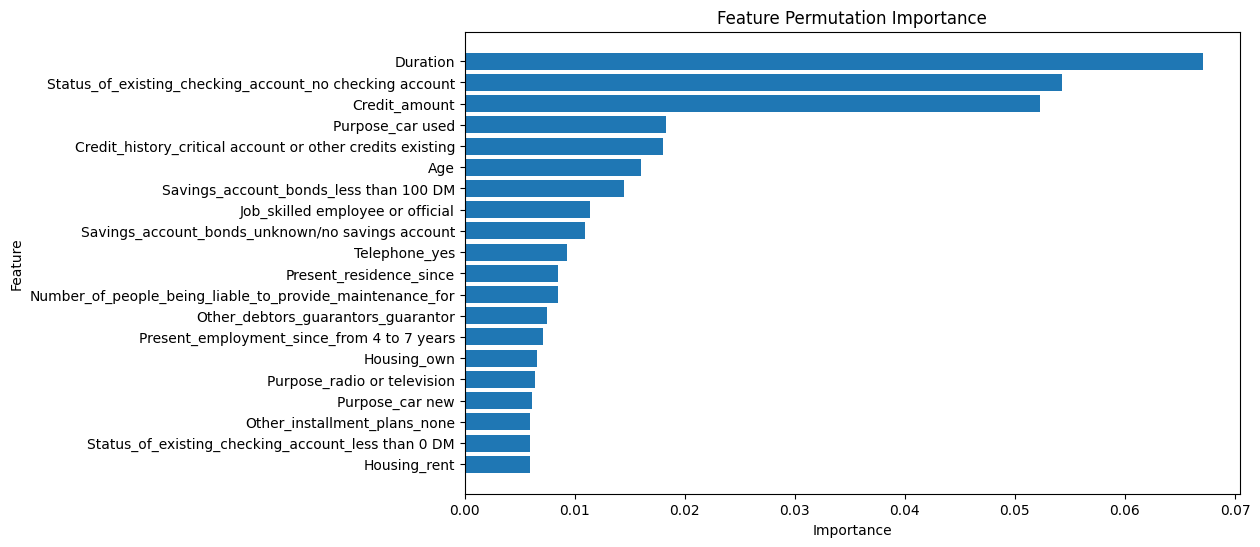

In [ ]:
plot_feat_permut_importance(xgb2_feat_permut_import_df)

In [ ]:
xgb2_perf, xgb2_orig_missing, xgb2_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Duration
Original feat removed so far:  ['Duration']

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Duration', 'Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Credit_amount
Original feat removed so far:  ['Duration', 'Status_of_existing_checking_account', 'Credit_amount']

--- NEW ITERATION ---
Removing feature:  Purpose_car used
Removing related features:  ['Purpose_car new', 'Purpose_car used', 'Purpose_domestic appliances', 'Purpose_education', 'Purpose_furniture or equipment', 'Purpose_others', 'Purpose_radio or television', 'Purpose_repairs', 'Purpose_retraining']
Original feat removed so far:  ['Du

In [ ]:
xgb2_perf

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   46  102   38  14      54.76   76.67        72.86      74.0     63.89   
1   46   99   41  14      52.87   76.67        70.71      72.5     62.59   
2   49   76   64  11      43.36   81.67        54.29      62.5     56.65   
3   37   94   46  23      44.58   61.67        67.14      65.5     51.75   
4   39   89   51  21      43.33   65.00        63.57      64.0     52.00   
5   38   75   65  22      36.89   63.33        53.57      56.5     46.63   
6   42   67   73  18      36.52   70.00        47.86      54.5     48.00   
7   49   38  102  11      32.45   81.67        27.14      43.5     46.45   
8   53   30  110   7      32.52   88.33        21.43      41.5     47.53   
9   54   25  115   6      31.95   90.00        17.86      39.5     47.16   
10  52   26  114   8      31.33   86.67        18.57      39.0     46.02   
11  51   33  107   9      32.28   85.00        23.57      42.0     46.79   
12  52   28  112   8      31.71   86.67        20.00      40.0     46.43   
13  56   20  120   4      31.82   93.33        14.29      38.0     47.46   
14  55   26  114   5      32.54   91.67        18.57      40.5     48.03   
15  53   31  109   7      32.72   88.33        22.14      42.0     47.75   
16  53   30  110   7      32.52   88.33        21.43      41.5     47.53   
17  54   28  112   6      32.53   90.00        20.00      41.0     47.79   
18  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               74.76                 0   
1               73.69                 1   
2               67.98                 2   
3               64.40                 3   
4               64.29                 4   
5               58.45                 5   
6               58.93                 6   
7               54.40                 7   
8               54.88                 8   
9               53.93                 9   
10              52.62                10   
11              54.29                11   
12              53.33                12   
13              53.81                13   
14              55.12                14   
15              55.24                15   
16              54.88                16   
17              55.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                                ['Duration'] imputed  
2   ['Duration', 'Status_of_existing_checking_acco...  
3   ['Duration', 'Status_of_existing_checking_acco...  
4   ['Duration', 'Status_of_existing_checking_acco...  
5   ['Duration', 'Status_of_existing_checking_acco...  
6   ['Duration', 'Status_of_existing_checking_acco...  
7   ['Duration', 'Status_of_existing_checking_acco...  
8   ['Duration', 'Status_of_existing_checking_acco...  
9   ['Duration', 'Status_of_existing_checking_acco...  
10  ['Duration', 'Status_of_existing_checking_acco...  
11  ['Duration', 'Status_of_existing_checking_acco...  
12  ['Duration', 'Status_of_existing_checking_acco...  
13  ['Duration', 'Status_of_existing_checking_acco...  
14  ['Duration', 'Status_of_existing_checking_acco...  
15  ['Duration', 'Status_of_existing_checking_acco...  
16  ['Duration', 'Status_of_existing_checking_acco...  
17  ['Duration', 'Status_of_existing_checking_acco...  
18  ['Duration', 'Status_of_existing_checking_acco...  
19  ['Duration', 'Status_of_existing_checking_acco...  
20  ['Duration', 'Status_of_existing_checking_acco...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb2_perf_mf, xgb2_orig_missing_mf, xgb2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 01:46:58.281325

--- NEW ITERATION ---
Removing feature:  Duration
Nr. columns with nan:  1
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Credit_history_existing credits paid back duly till now', 'Credit_history_no credits taken or all credits paid back duly', 'Purpose_car new', 'Purpose_car used', 'Purpose_domestic appliances', 'Purpose_education', 'Purpose_furniture or equipment', 'Purpose_others', 'Purpose_radio

In [ ]:
xgb2_perf_mf

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   46  102   38  14      54.76   76.67        72.86      74.0     63.89   
1   47   98   42  13      52.81   78.33        70.00      72.5     63.09   
2   44   85   55  16      44.44   73.33        60.71      64.5     55.35   
3   36   97   43  24      45.57   60.00        69.29      66.5     51.80   
4   38   87   53  22      41.76   63.33        62.14      62.5     50.33   
5   39   74   66  21      37.14   65.00        52.86      56.5     47.27   
6   43   69   71  17      37.72   71.67        49.29      56.0     49.43   
7   48   50   90  12      34.78   80.00        35.71      49.0     48.48   
8   46   45   95  14      32.62   76.67        32.14      45.5     45.77   
9   50   42   98  10      33.78   83.33        30.00      46.0     48.08   
10  52   34  106   8      32.91   86.67        24.29      43.0     47.71   
11  50   30  110  10      31.25   83.33        21.43      40.0     45.45   
12  49   30  110  11      30.82   81.67        21.43      39.5     44.75   
13  53   32  108   7      32.92   88.33        22.86      42.5     47.96   
14  51   33  107   9      32.28   85.00        23.57      42.0     46.79   
15  49   31  109  11      31.01   81.67        22.14      40.0     44.95   
16  57    8  132   3      30.16   95.00         5.71      32.5     45.78   
17  57    3  137   3      29.38   95.00         2.14      30.0     44.88   
18  55    8  132   5      29.41   91.67         5.71      31.5     44.53   
19  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               74.76                 0   
1               74.17                 1   
2               67.02                 2   
3               64.64                 3   
4               62.74                 4   
5               58.93                 5   
6               60.48                 6   
7               57.86                 7   
8               54.40                 8   
9               56.67                 9   
10              55.48                10   
11              52.38                11   
12              51.55                12   
13              55.60                13   
14              54.29                14   
15              51.90                15   
16              50.36                16   
17              48.57                17   
18              48.69                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                                ['Duration'] imputed  
2   ['Duration', 'Status_of_existing_checking_acco...  
3   ['Duration', 'Status_of_existing_checking_acco...  
4   ['Duration', 'Status_of_existing_checking_acco...  
5   ['Duration', 'Status_of_existing_checking_acco...  
6   ['Duration', 'Status_of_existing_checking_acco...  
7   ['Duration', 'Status_of_existing_checking_acco...  
8   ['Duration', 'Status_of_existing_checking_acco...  
9   ['Duration', 'Status_of_existing_checking_acco...  
10  ['Duration', 'Status_of_existing_checking_acco...  
11  ['Duration', 'Status_of_existing_checking_acco...  
12  ['Duration', 'Status_of_existing_checking_acco...  
13  ['Duration', 'Status_of_existing_checking_acco...  
14  ['Duration', 'Status_of_existing_checking_acco...  
15  ['Duration', 'Status_of_existing_checking_acco...  
16  ['Duration', 'Status_of_existing_checking_acco...  
17  ['Duration', 'Status_of_existing_checking_acco...  
18  ['Duration', 'Status_of_existing_checking_acco...  
19  ['Duration', 'Status_of_existing_checking_acco...  
20  ['Duration', 'Status_of_existing_checking_acco...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et2_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.05, 0.01, 2],
      'min_samples_leaf': [0.05, 0.01, 1]
  }
else:
  et2_param_grid = {
    'n_estimators': [200],
    'max_depth': [5],
    'max_features':['sqrt'],
    'min_samples_split': [0.05],
    'min_samples_leaf': [0.05],
}

et2_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et2_grid_search, et2_best_model, et2_best_params = hyperparameter_tuning(
    et2_classifier, et2_param_grid, 5, 5, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-19 01:49:42.966131

Nested Cross-validation Results:
Individual scores: [0.67559524 0.70386905 0.70238095 0.69940476 0.72172619]
Average nested CV score: 0.701 (+/- 0.029)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 0.05, 'min_samples_split': 0.05, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.701

Train score: 0.727
Test score: 0.701
Train-test score difference: 0.026
2025-01-19 01:49:45.850026

Execution time: 0.05 minutes


```
Starting hyperparameter tuning at: 2025-01-15 00:56:20.739011

Nested Cross-validation Results:
Individual scores: [0.65327381 0.69345238 0.66220238 0.69047619 0.73660714]
Average nested CV score: 0.687 (+/- 0.058)

Fitting final model on entire dataset...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 0.05, 'min_samples_split': 0.05, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.701

Train score: 0.727
Test score: 0.701
Train-test score difference: 0.026
2025-01-15 01:28:24.164062

Execution time: 32.06 minutes
```




In [ ]:
et2_classifier, train_pred, test_pred = apply_model(et2_best_model, X_train, y_train, X_test, y_test)
et2_feat_permut_import_df = analyze_feat_permut_import(et2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
et2_feat_permut_import_df[et2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
11  Status_of_existing_checking_account_no checkin...    0.038333  0.006733
27             Savings_account_bonds_less than 100 DM    0.021964  0.006532
0                                            Duration    0.014940  0.003771
39                               Property_real estate    0.014881  0.003626
12  Credit_history_critical account or other credi...    0.012381  0.007703
10  Status_of_existing_checking_account_less than ...    0.011012  0.004107
43                                        Housing_own    0.009405  0.002151
22                        Purpose_radio or television    0.007738  0.003722
28   Savings_account_bonds_unknown/no savings account    0.007143  0.002934
16                                    Purpose_car new    0.006012  0.003235
35                Personal_status_and_sex_male single    0.005655  0.004059
44                                       Housing_rent    0.005179  0.001513
2   Installment_rate_in_percentage_of_disposable_i...    0.002976  0.001370
29         Present_employment_since_from 4 to 7 years    0.002619  0.002391
41                       Other_installment_plans_none    0.002440  0.000437
17                                   Purpose_car used    0.002381  0.001715
7                                       Telephone_yes    0.002083  0.001805
30  Present_employment_since_greater or equal to 7...    0.001845  0.002125
26  Savings_account_bonds_greater or equal to 1000 DM    0.001726  0.001021
40                    Property_unknown or no property    0.001429  0.001591
38                              Property_car or other    0.001012  0.000404
36                 Other_debtors_guarantors_guarantor    0.000714  0.000357
5             Number_of_existing_credits_at_this_bank    0.000417  0.001326
37                      Other_debtors_guarantors_none    0.000357  0.000714
19                                  Purpose_education    0.000179  0.000357
31          Present_employment_since_less than 1 year   -0.000357  0.000714
20                     Purpose_furniture or equipment   -0.000357  0.001388
45                   Job_skilled employee or official   -0.000357  0.002464
14  Credit_history_existing credits paid back duly...   -0.000417  0.001658
3                             Present_residence_since   -0.000417  0.001559
4                                                 Age   -0.000417  0.001465
1                                       Credit_amount   -0.000536  0.000437
47                           Job_unskilled - resident   -0.001905  0.001559
9   Status_of_existing_checking_account_greater or...   -0.002262  0.000357

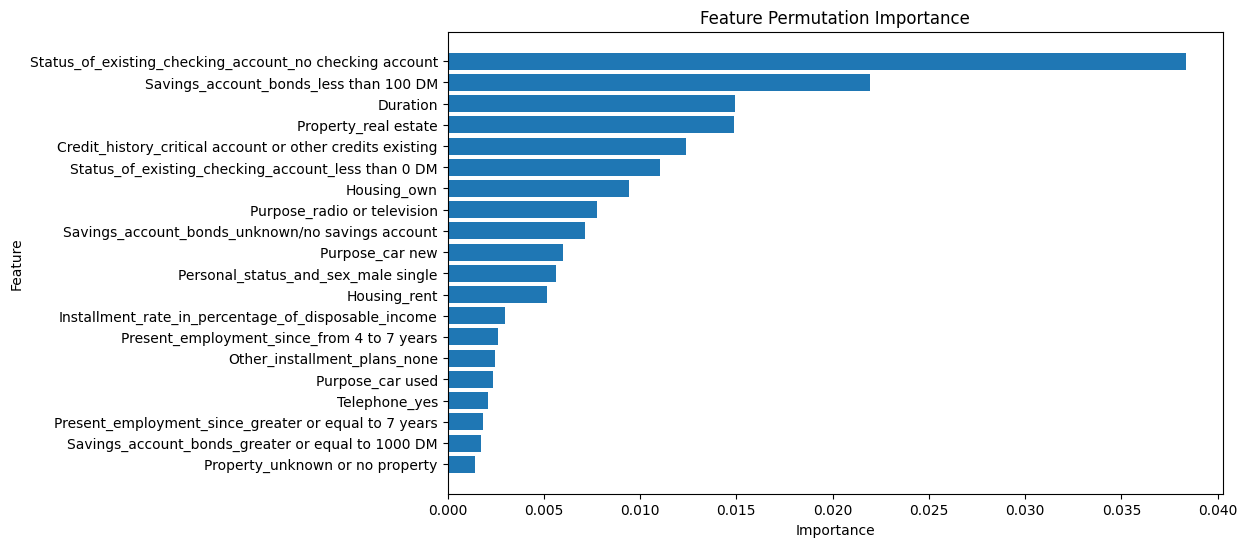

In [ ]:
plot_feat_permut_importance(et2_feat_permut_import_df)

In [ ]:
et2_perf, et2_orig_missing, et2_missing = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    german_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Savings_account_bonds_less than 100 DM
Removing related features:  ['Savings_account_bonds_from 500 to 1000 DM', 'Savings_account_bonds_greater or equal to 1000 DM', 'Savings_account_bonds_less than 100 DM', 'Savings_account_bonds_unknown/no savings account']
Original feat removed so far:  ['Status_of_existing_checking_account', 'Savings_account_bonds']

--- NEW ITERATION ---
Removing feature:  Duration
Original feat removed so far:  ['Status_of_existing_checking_account', 'Savings_account_bonds', 'Duration']

--- NEW ITERATION ---
Removing feature:  Pr

In [ ]:
et2_perf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   49  92   48  11      50.52   81.67        65.71      70.5     62.42   
1   51  77   63   9      44.74   85.00        55.00      64.0     58.62   
2   55  48   92   5      37.41   91.67        34.29      51.5     53.14   
3   55  43   97   5      36.18   91.67        30.71      49.0     51.89   
4   56  39  101   4      35.67   93.33        27.86      47.5     51.61   
5   60   1  139   0      30.15  100.00         0.71      30.5     46.33   
6   60   1  139   0      30.15  100.00         0.71      30.5     46.33   
7   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
8   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
9   60   0  140   0      30.00  100.00         0.00      30.0     46.15   
10  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
11  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
12  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
13  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
14  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
15  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               73.69                 0   
1               70.00                 1   
2               62.98                 2   
3               61.19                 3   
4               60.60                 4   
5               50.36                 5   
6               50.36                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et2_perf_mf, et2_orig_missing_mf, et2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 01:49:47.866402

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
et2_perf_mf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   49  92   48  11      50.52   81.67        65.71      70.5     62.42   
1   43  74   66  17      39.45   71.67        52.86      58.5     50.89   
2   50  51   89  10      35.97   83.33        36.43      50.5     50.25   
3   50  47   93  10      34.97   83.33        33.57      48.5     49.26   
4   55  32  108   5      33.74   91.67        22.86      43.5     49.33   
5   56  17  123   4      31.28   93.33        12.14      36.5     46.86   
6   51  19  121   9      29.65   85.00        13.57      35.0     43.97   
7   52  11  129   8      28.73   86.67         7.86      31.5     43.15   
8   50   9  131  10      27.62   83.33         6.43      29.5     41.49   
9   50   9  131  10      27.62   83.33         6.43      29.5     41.49   
10  57   4  136   3      29.53   95.00         2.86      30.5     45.06   
11  59   2  138   1      29.95   98.33         1.43      30.5     45.91   
12  59   2  138   1      29.95   98.33         1.43      30.5     45.91   
13  59   2  138   1      29.95   98.33         1.43      30.5     45.91   
14  59   2  138   1      29.95   98.33         1.43      30.5     45.91   
15  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
16  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               73.69                 0   
1               62.26                 1   
2               59.88                 2   
3               58.45                 3   
4               57.26                 4   
5               52.74                 5   
6               49.29                 6   
7               47.26                 7   
8               44.88                 8   
9               44.88                 9   
10              48.93                10   
11              49.88                11   
12              49.88                12   
13              49.88                13   
14              49.88                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

## **Support Vector Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm2_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],
      'kernel': ['linear', 'poly', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1, 2],
      'degree': [2, 3, 4, 5]
  }
else:
  # best model
  svm2_param_grid = {
    'C': [0.1],
    'kernel': ['linear'],
    'gamma': ['scale'],
    'degree': [2]
}

svm2_classifier = SVC(class_weight='balanced', random_state=RANDOM_STATE)
svm2_grid_search, svm2_best_model, svm2_best_params = hyperparameter_tuning(
    svm2_classifier, svm2_param_grid, 5, 5, 'balanced_accuracy', X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-19 01:52:36.032332

Nested Cross-validation Results:
Individual scores: [0.68452381 0.72619048 0.6547619  0.71875    0.75595238]
Average nested CV score: 0.708 (+/- 0.070)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}

Best Model Performance:
Best CV score: 0.708

Train score: 0.744
Test score: 0.708
Train-test score difference: 0.036
2025-01-19 01:52:36.243334

Execution time: 0.00 minutes


```
Starting hyperparameter tuning at: 2025-01-14 19:31:10.872807

Nested Cross-validation Results:
Individual scores: [0.66815476 0.69642857 0.67708333 0.69642857 0.73214286]
Average nested CV score: 0.694 (+/- 0.044)

Fitting final model on entire dataset...
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best parameters: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}

Best Model Performance:
Best CV score: 0.708

Train score: 0.744
Test score: 0.708
Train-test score difference: 0.036
2025-01-14 19:32:30.466426

Execution time: 1.33 minutes
```





In [ ]:
svm2_classifier, train_pred, test_pred = apply_model(svm2_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm2_feat_permut_import_df = analyze_feat_permut_import(svm2_classifier, X_train_scaled, y_train, scoring_metric="balanced_accuracy")
svm2_feat_permut_import_df[svm2_feat_permut_import_df['Importance']!=0]

Feature    Importance       Std
11  Status_of_existing_checking_account_no checkin...  3.148810e-02  0.010978
0                                            Duration  1.404762e-02  0.005201
35                Personal_status_and_sex_male single  1.261905e-02  0.006043
12  Credit_history_critical account or other credi...  1.017857e-02  0.008216
22                        Purpose_radio or television  9.880952e-03  0.002174
36                 Other_debtors_guarantors_guarantor  9.464286e-03  0.004082
29         Present_employment_since_from 4 to 7 years  8.928571e-03  0.002418
39                               Property_real estate  7.023810e-03  0.002325
27             Savings_account_bonds_less than 100 DM  6.369048e-03  0.005906
33  Personal_status_and_sex_male divorced or separ...  6.071429e-03  0.002378
4                                                 Age  5.892857e-03  0.004730
5             Number_of_existing_credits_at_this_bank  5.654762e-03  0.001370
44                                       Housing_rent  5.654762e-03  0.002211
1                                       Credit_amount  5.595238e-03  0.003503
10  Status_of_existing_checking_account_less than ...  5.535714e-03  0.005605
14  Credit_history_existing credits paid back duly...  5.476190e-03  0.001840
17                                   Purpose_car used  4.523810e-03  0.002769
15  Credit_history_no credits taken or all credits...  4.404762e-03  0.000785
37                      Other_debtors_guarantors_none  4.285714e-03  0.002076
7                                       Telephone_yes  3.333333e-03  0.002750
3                             Present_residence_since  3.035714e-03  0.001624
47                           Job_unskilled - resident  2.738095e-03  0.001211
30  Present_employment_since_greater or equal to 7...  2.500000e-03  0.002557
8                                  Foreign_worker_yes  2.142857e-03  0.003771
40                    Property_unknown or no property  2.142857e-03  0.001021
46         Job_unemployed or unskilled - non-resident  1.488095e-03  0.001947
28   Savings_account_bonds_unknown/no savings account  1.488095e-03  0.003581
25          Savings_account_bonds_from 500 to 1000 DM  1.130952e-03  0.001268
6   Number_of_people_being_liable_to_provide_maint...  9.523810e-04  0.004232
43                                        Housing_own  7.142857e-04  0.001199
13     Credit_history_delay in paying off in the past  7.142857e-04  0.003039
31          Present_employment_since_less than 1 year  5.357143e-04  0.001336
9   Status_of_existing_checking_account_greater or...  5.357143e-04  0.002125
32                Present_employment_since_unemployed  3.571429e-04  0.001426
42                     Other_installment_plans_stores  1.785714e-04  0.000357
41                       Other_installment_plans_none  6.661338e-17  0.002396
24                                 Purpose_retraining -1.785714e-04  0.000357
34    Personal_status_and_sex_male married or widowed -4.166667e-04  0.000833
23                                    Purpose_repairs -5.952381e-04  0.001318
38                              Property_car or other -7.738095e-04  0.000238
26  Savings_account_bonds_greater or equal to 1000 DM -8.333333e-04  0.003642
21                                     Purpose_others -8.928571e-04  0.000565
19                                  Purpose_education -9.523810e-04  0.001709
45                   Job_skilled employee or official -1.071429e-03  0.001907
2   Installment_rate_in_percentage_of_disposable_i... -1.309524e-03  0.004199
20                     Purpose_furniture or equipment -2.619048e-03  0.001932
16                                    Purpose_car new -2.678571e-03  0.004591

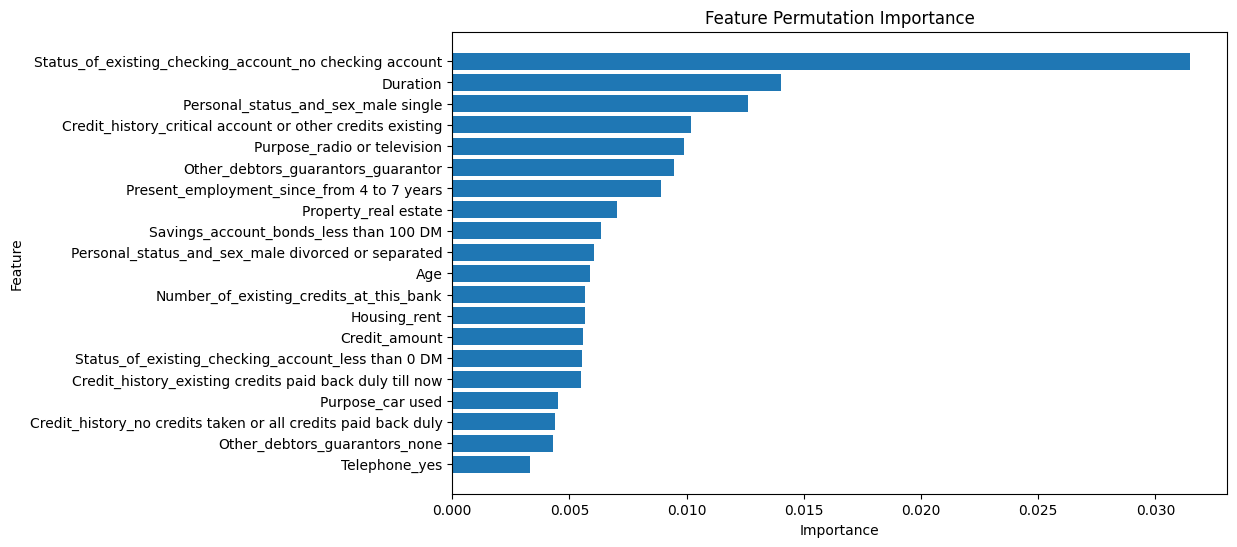

In [ ]:
plot_feat_permut_importance(svm2_feat_permut_import_df)

In [ ]:
svm2_perf, svm2_orig_missing, svm2_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    german_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Duration
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration']

--- NEW ITERATION ---
Removing feature:  Personal_status_and_sex_male single
Removing related features:  ['Personal_status_and_sex_male divorced or separated', 'Personal_status_and_sex_male married or widowed', 'Personal_status_and_sex_male single']
Original feat removed so far:  ['Status_of_existing_checking_account', 'Duration', 'Personal_status_and_sex']

--- NEW ITERATION ---
Removing feature:  Credit_history_critical account or other credits existing
Removi

In [ ]:
svm2_perf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   52  98   42   8      55.32   86.67        70.00      75.0     67.53   
1   51  73   67   9      43.22   85.00        52.14      62.0     57.30   
2   51  73   67   9      43.22   85.00        52.14      62.0     57.30   
3   44  84   56  16      44.00   73.33        60.00      64.0     55.00   
4   47  74   66  13      41.59   78.33        52.86      60.5     54.34   
5   48  70   70  12      40.68   80.00        50.00      59.0     53.93   
6   48  67   73  12      39.67   80.00        47.86      57.5     53.04   
7   51  53   87   9      36.96   85.00        37.86      52.0     51.52   
8   50  49   91  10      35.46   83.33        35.00      49.5     49.75   
9   58  21  119   2      32.77   96.67        15.00      39.5     48.95   
10  58  18  122   2      32.22   96.67        12.86      38.0     48.33   
11  58  19  121   2      32.40   96.67        13.57      38.5     48.54   
12  58  23  117   2      33.14   96.67        16.43      40.5     49.36   
13  55  27  113   5      32.74   91.67        19.29      41.0     48.25   
14  56  23  117   4      32.37   93.33        16.43      39.5     48.07   
15  57  15  125   3      31.32   95.00        10.71      36.0     47.11   
16  59   5  135   1      30.41   98.33         3.57      32.0     46.46   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               78.33                 0   
1               68.57                 1   
2               68.57                 2   
3               66.67                 3   
4               65.60                 4   
5               65.00                 5   
6               63.93                 6   
7               61.43                 7   
8               59.17                 8   
9               55.83                 9   
10              54.76                10   
11              55.12                11   
12              56.55                12   
13              55.48                13   
14              54.88                14   
15              52.86                15   
16              50.95                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm2_perf_mf, svm2_orig_missing_mf, svm2_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 01:52:37.384667

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age', 'Number_of_existing_credits_at_this_bank']
Categorical columns:  ['Number_of_people_being_liable_to_provide_maintenance_for', 'Telephone_yes', 'Foreign_worker_yes', 'Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account', 'Credit_history_critical account or other credits existing', 'Credit_history_delay in paying off in the past', 'Cre

In [ ]:
svm2_perf_mf

tp  tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   52  98   42   8      55.32   86.67        70.00      75.0     67.53   
1   43  80   60  17      41.75   71.67        57.14      61.5     52.76   
2   44  79   61  16      41.90   73.33        56.43      61.5     53.33   
3   40  84   56  20      41.67   66.67        60.00      62.0     51.28   
4   42  71   69  18      37.84   70.00        50.71      56.5     49.12   
5   45  57   83  15      35.16   75.00        40.71      51.0     47.87   
6   45  56   84  15      34.88   75.00        40.00      50.5     47.62   
7   45  64   76  15      37.19   75.00        45.71      54.5     49.72   
8   44  53   87  16      33.59   73.33        37.86      48.5     46.07   
9   58   7  133   2      30.37   96.67         5.00      32.5     46.22   
10  58   7  133   2      30.37   96.67         5.00      32.5     46.22   
11  59   6  134   1      30.57   98.33         4.29      32.5     46.64   
12  59   6  134   1      30.57   98.33         4.29      32.5     46.64   
13  57   5  135   3      29.69   95.00         3.57      31.0     45.24   
14  57   5  135   3      29.69   95.00         3.57      31.0     45.24   
15  57   4  136   3      29.53   95.00         2.86      30.5     45.06   
16  59   3  137   1      30.10   98.33         2.14      31.0     46.09   
17  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
18  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
19  60   0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60   0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               78.33                 0   
1               64.40                 1   
2               64.88                 2   
3               63.33                 3   
4               60.36                 4   
5               57.86                 5   
6               57.50                 6   
7               60.36                 7   
8               55.60                 8   
9               50.83                 9   
10              50.83                10   
11              51.31                11   
12              51.31                12   
13              49.29                13   
14              49.29                14   
15              48.93                15   
16              50.24                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

##**Logistic Regression**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr2_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],            # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']         # Algorithm for optimization
  }
else:
  # best model
  lr2_param_grid = {
    'C': [0.1],
    'penalty': ['l2'],
    'solver': ['saga']
  }

lr2_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr2_grid_search, lr2_best_model, lr2_best_params = hyperparameter_tuning(
    lr2_classifier, lr2_param_grid, 5, 5, 'balanced_accuracy', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-19 01:55:29.285820

Nested Cross-validation Results:
Individual scores: [0.67113095 0.74404762 0.67559524 0.6889881  0.77083333]
Average nested CV score: 0.710 (+/- 0.080)

Fitting final model on entire dataset...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}

Best Model Performance:
Best CV score: 0.710

Train score: 0.731
Test score: 0.710
Train-test score difference: 0.021
2025-01-19 01:55:29.485618

Execution time: 0.00 minutes


```
Starting hyperparameter tuning at: 2025-01-15 01:28:24.191234

Nested Cross-validation Results:
Individual scores: [0.68005952 0.70684524 0.68452381 0.70535714 0.7514881 ]
Average nested CV score: 0.706 (+/- 0.051)

Fitting final model on entire dataset...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}

Best Model Performance:
Best CV score: 0.710

Train score: 0.731
Test score: 0.710
Train-test score difference: 0.021
2025-01-15 01:28:29.474346

Execution time: 0.09 minutes
```




In [ ]:
lr2_classifier, train_pred, test_pred = apply_model(lr2_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr2_feat_permut_import_df = analyze_feat_permut_import(lr2_classifier, lr_X_train, y_train, scoring_metric="balanced_accuracy")
lr2_feat_permut_import_df[lr2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0   Status_of_existing_checking_account_no checkin...    0.024881  0.010870
16                                   Purpose_car used    0.009464  0.003568
18                Personal_status_and_sex_male single    0.008929  0.006172
4   Credit_history_critical account or other credi...    0.008095  0.013117
3              Savings_account_bonds_less than 100 DM    0.006964  0.009058
36                           Job_unskilled - resident    0.005179  0.002279
2                                            Duration    0.004643  0.002371
5   Credit_history_no credits taken or all credits...    0.004167  0.003346
22         Present_employment_since_from 4 to 7 years    0.003869  0.002497
11                                                Age    0.003393  0.002271
30  Status_of_existing_checking_account_greater or...    0.002679  0.002138
13                    Property_unknown or no property    0.002440  0.003008
9                         Purpose_radio or television    0.002381  0.005799
27                 Other_debtors_guarantors_guarantor    0.001726  0.002794
10                                       Housing_rent    0.001310  0.002840
1   Status_of_existing_checking_account_less than ...    0.001190  0.006044
34                                 Purpose_retraining    0.000714  0.000357
46         Job_unemployed or unskilled - non-resident    0.000655  0.002022
47                                     Purpose_others    0.000357  0.000437
28  Personal_status_and_sex_male divorced or separ...    0.000238  0.001960
42                      Other_debtors_guarantors_none    0.000238  0.000739
23                                  Purpose_education    0.000179  0.002240
26  Present_employment_since_greater or equal to 7...   -0.000060  0.001211
35                                    Purpose_repairs   -0.000060  0.000663
8                                       Credit_amount   -0.000417  0.003540
21                Present_employment_since_unemployed   -0.000536  0.001211
31            Number_of_existing_credits_at_this_bank   -0.000714  0.001626
38    Personal_status_and_sex_male married or widowed   -0.000774  0.002101
19                                 Foreign_worker_yes   -0.000893  0.002695
25          Savings_account_bonds_from 500 to 1000 DM   -0.000893  0.000565
29  Credit_history_existing credits paid back duly...   -0.001012  0.002101
43  Number_of_people_being_liable_to_provide_maint...   -0.001071  0.002494
7                                         Housing_own   -0.001190  0.001129
20  Savings_account_bonds_greater or equal to 1000 DM   -0.001548  0.002206
39     Credit_history_delay in paying off in the past   -0.001548  0.001211
40                            Present_residence_since   -0.001786  0.004572
14                               Property_real estate   -0.001845  0.002339
6    Savings_account_bonds_unknown/no savings account   -0.002798  0.004809
33                                      Telephone_yes   -0.002857  0.004270
15                                    Purpose_car new   -0.003512  0.002108
12          Present_employment_since_less than 1 year   -0.003750  0.003715
17                       Other_installment_plans_none   -0.004048  0.004449
24  Installment_rate_in_percentage_of_disposable_i...   -0.004405  0.002022
41                     Purpose_furniture or equipment   -0.006310  0.003534

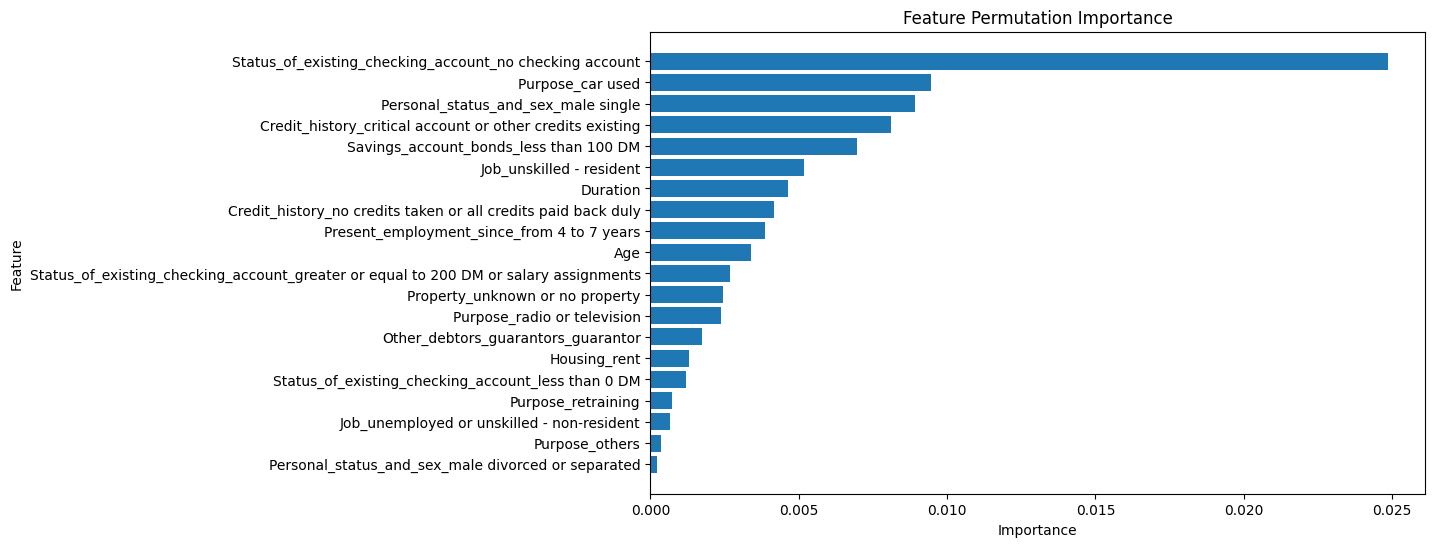

In [ ]:
plot_feat_permut_importance(lr2_feat_permut_import_df)

In [ ]:
lr2_perf, lr2_orig_missing, lr2_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    german_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=german_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Original feat removed so far:  ['Status_of_existing_checking_account']

--- NEW ITERATION ---
Removing feature:  Purpose_car used
Removing related features:  ['Purpose_car new', 'Purpose_car used', 'Purpose_domestic appliances', 'Purpose_education', 'Purpose_furniture or equipment', 'Purpose_others', 'Purpose_radio or television', 'Purpose_repairs', 'Purpose_retraining']
Original feat removed so far:  ['Status_of_existing_checking_account', 'Purpose']

--- NEW ITERATION ---
Removing feature:  Personal_status_and_sex_male single
Removing related features:  ['Personal_status_and_sex_male divorced or separated', 'Personal_status_and_sex_male married or widowed', 'Per

In [ ]:
lr2_perf

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   50  102   38  10      56.82   83.33        72.86      76.0     67.57   
1   51   80   60   9      45.95   85.00        57.14      65.5     59.65   
2   50   75   65  10      43.48   83.33        53.57      62.5     57.14   
3   47   91   49  13      48.96   78.33        65.00      69.0     60.26   
4   50   71   69  10      42.02   83.33        50.71      60.5     55.87   
5   57   46   94   3      37.75   95.00        32.86      51.5     54.03   
6   57   45   95   3      37.50   95.00        32.14      51.0     53.77   
7   58   45   95   2      37.91   96.67        32.14      51.5     54.46   
8   59   33  107   1      35.54   98.33        23.57      46.0     52.21   
9   58   32  108   2      34.94   96.67        22.86      45.0     51.33   
10  58   23  117   2      33.14   96.67        16.43      40.5     49.36   
11  58   18  122   2      32.22   96.67        12.86      38.0     48.33   
12  58   24  116   2      33.33   96.67        17.14      41.0     49.57   
13  57   25  115   3      33.14   95.00        17.86      41.0     49.14   
14  52   27  113   8      31.52   86.67        19.29      39.5     46.22   
15  52   28  112   8      31.71   86.67        20.00      40.0     46.43   
16  52   23  117   8      30.77   86.67        16.43      37.5     45.41   
17  51   26  114   9      30.91   85.00        18.57      38.5     45.33   
18  50   34  106  10      32.05   83.33        24.29      42.0     46.30   
19  53   21  119   7      30.81   88.33        15.00      37.0     45.69   
20  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               78.10                 0   
1               71.07                 1   
2               68.45                 2   
3               71.67                 3   
4               67.02                 4   
5               63.93                 5   
6               63.57                 6   
7               64.40                 7   
8               60.95                 8   
9               59.76                 9   
10              56.55                10   
11              54.76                11   
12              56.90                12   
13              56.43                13   
14              52.98                14   
15              53.33                15   
16              51.55                16   
17              51.79                17   
18              53.81                18   
19              51.67                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr2_perf_mf, lr2_orig_missing_mf, lr2_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=german_encoded_vars_family,
    categorical_vars=lr_german_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-19 01:55:30.325261

--- NEW ITERATION ---
Removing feature:  Status_of_existing_checking_account_no checking account
Removing related features:  ['Status_of_existing_checking_account_greater or equal to 200 DM or salary assignments', 'Status_of_existing_checking_account_less than 0 DM', 'Status_of_existing_checking_account_no checking account']
Nr. columns with nan:  3
Numerical columns:  ['Duration', 'Credit_amount', 'Age', 'Installment_rate_in_percentage_of_disposable_income', 'Number_of_existing_credits_at_this_bank', 'Present_residence_since']
Categorical columns:  ['Status_of_existing_checking_account_no checking account', 'Status_of_existing_checking_account_less than 0 DM', 'Savings_account_bonds_less than 100 DM', 'Credit_history_critical account or other credits existing', 'Credit_history_no credits taken or all credits paid back duly', 'Savings_account_bonds_unknown/no savings account', 'Housing_own', 'Purpose_radio or television', 'Housing_rent', 'Present_employment_

In [ ]:
lr2_perf_mf

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   50  102   38  10      56.82   83.33        72.86      76.0     67.57   
1   34  107   33  26      50.75   56.67        76.43      70.5     53.54   
2   35  104   36  25      49.30   58.33        74.29      69.5     53.44   
3   34  108   32  26      51.52   56.67        77.14      71.0     53.97   
4   33  103   37  27      47.14   55.00        73.57      68.0     50.77   
5   36   92   48  24      42.86   60.00        65.71      64.0     50.00   
6   34   90   50  26      40.48   56.67        64.29      62.0     47.22   
7   35   89   51  25      40.70   58.33        63.57      62.0     47.95   
8   28   97   43  32      39.44   46.67        69.29      62.5     42.75   
9   30   97   43  30      41.10   50.00        69.29      63.5     45.11   
10  26   90   50  34      34.21   43.33        64.29      58.0     38.24   
11  28   89   51  32      35.44   46.67        63.57      58.5     40.29   
12  31   76   64  29      32.63   51.67        54.29      53.5     40.00   
13  43   63   77  17      35.83   71.67        45.00      53.0     47.78   
14  35   65   75  25      31.82   58.33        46.43      50.0     41.18   
15  35   65   75  25      31.82   58.33        46.43      50.0     41.18   
16  35   62   78  25      30.97   58.33        44.29      48.5     40.46   
17  36   61   79  24      31.30   60.00        43.57      48.5     41.14   
18  36   61   79  24      31.30   60.00        43.57      48.5     41.14   
19  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
20  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

    balanced_accuracy  num_feat_missing  \
0               78.10                 0   
1               66.55                 1   
2               66.31                 2   
3               66.90                 3   
4               64.29                 4   
5               62.86                 5   
6               60.48                 6   
7               60.95                 7   
8               57.98                 8   
9               59.64                 9   
10              53.81                10   
11              55.12                11   
12              52.98                12   
13              58.33                13   
14              52.38                14   
15              52.38                15   
16              51.31                16   
17              51.79                17   
18              51.79                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Status_of_existing_checking_account_greater ...  
2   ['Status_of_existing_checking_account_greater ...  
3   ['Status_of_existing_checking_account_greater ...  
4   ['Status_of_existing_checking_account_greater ...  
5   ['Status_of_existing_checking_account_greater ...  
6   ['Status_of_existing_checking_account_greater ...  
7   ['Status_of_existing_checking_account_greater ...  
8   ['Status_of_existing_checking_account_greater ...  
9   ['Status_of_existing_checking_account_greater ...  
10  ['Status_of_existing_checking_account_greater ...  
11  ['Status_of_existing_checking_account_greater ...  
12  ['Status_of_existing_checking_account_greater ...  
13  ['Status_of_existing_checking_account_greater ...  
14  ['Status_of_existing_checking_account_greater ...  
15  ['Status_of_existing_checking_account_greater ...  
16  ['Status_of_existing_checking_account_greater ...  
17  ['Status_of_existing_checking_account_greater ...  
18  ['Status_of_existing_checking_account_greater ...  
19  ['Status_of_existing_checking_account_greater ...  
20  ['Status_of_existing_checking_account_greater ...

# **Results comparison**

## **F1-score**

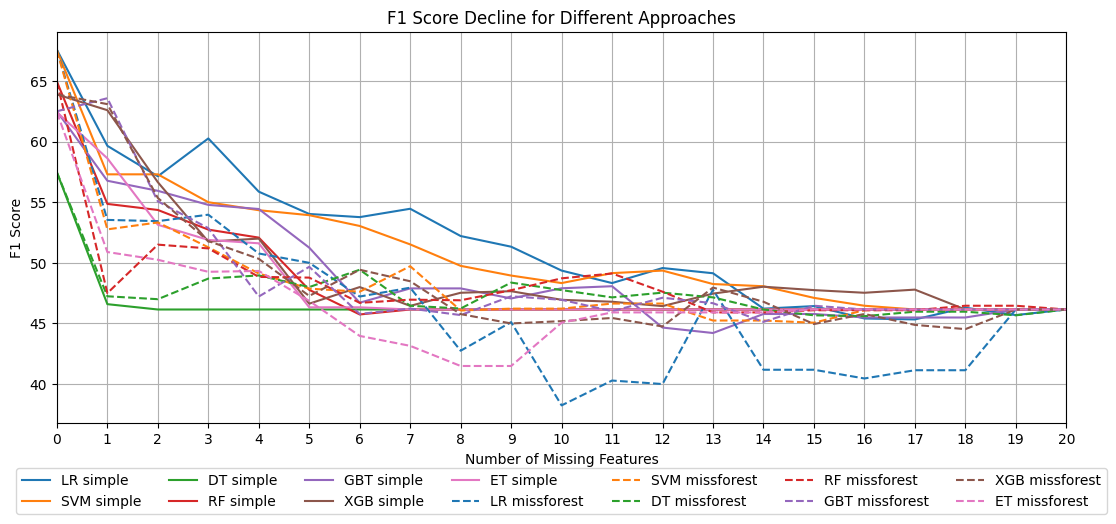

In [ ]:
# # Line plot for the f1 score of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr_perf['num_feat_missing'], lr_perf['f1_score'], label='LR simple', color=colors[0])
plt.plot(svm_perf['num_feat_missing'], svm_perf['f1_score'], label='SVM simple', color=colors[1])
plt.plot(dt_perf['num_feat_missing'], dt_perf['f1_score'], label='DT simple', color=colors[2])
plt.plot(rf_perf['num_feat_missing'], rf_perf['f1_score'], label='RF simple', color=colors[3])
plt.plot(gbt_perf['num_feat_missing'], gbt_perf['f1_score'], label='GBT simple', color=colors[4])
plt.plot(xgb_perf['num_feat_missing'], xgb_perf['f1_score'], label='XGB simple', color=colors[5])
plt.plot(et_perf['num_feat_missing'], et_perf['f1_score'], label='ET simple', color=colors[6])

plt.plot(lr_perf_mf['num_feat_missing'], lr_perf_mf['f1_score'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm_perf_mf['num_feat_missing'], svm_perf_mf['f1_score'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt_perf_mf['num_feat_missing'], dt_perf_mf['f1_score'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf_perf_mf['num_feat_missing'], rf_perf_mf['f1_score'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt_perf_mf['num_feat_missing'], gbt_perf_mf['f1_score'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb_perf_mf['num_feat_missing'], xgb_perf_mf['f1_score'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et_perf_mf['num_feat_missing'], et_perf_mf['f1_score'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score')
plt.title('F1 Score Decline for Different Approaches')
plt.xticks(et_perf.index.astype(int))
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

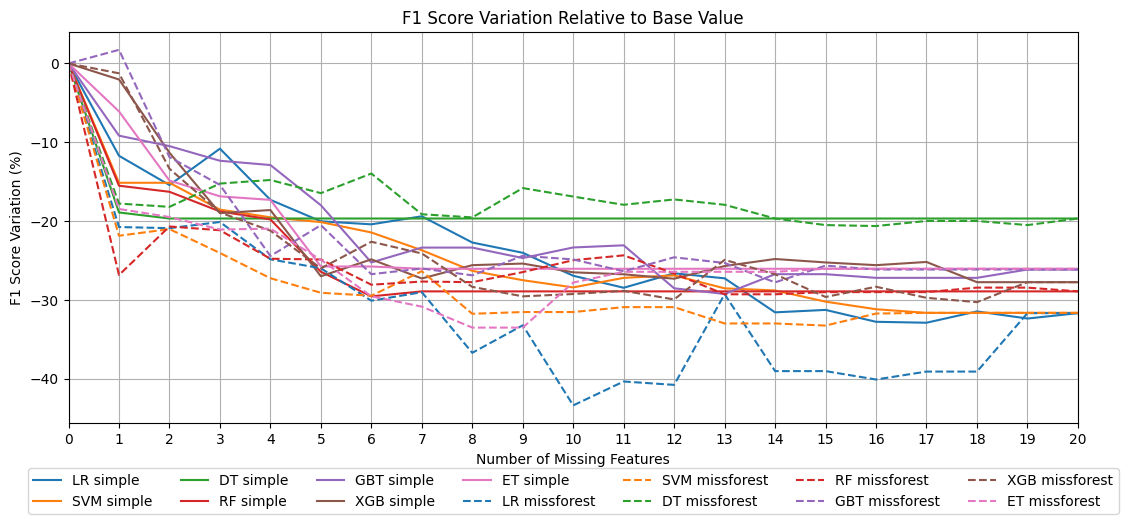

In [ ]:
# Line plot for the f1 score variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the F1-score variation for each model
for perf_df, label, color, linestyle in zip(
    [lr_perf, svm_perf, dt_perf, rf_perf, gbt_perf, xgb_perf, et_perf,
     lr_perf_mf, svm_perf_mf, dt_perf_mf, rf_perf_mf, gbt_perf_mf, xgb_perf_mf, et_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base F1-score
    f1_variation = (perf_df['f1_score'] - perf_df['f1_score'].iloc[0]) / perf_df['f1_score'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], f1_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score Variation (%)')
plt.title('F1 Score Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##**Balanced accuracy**

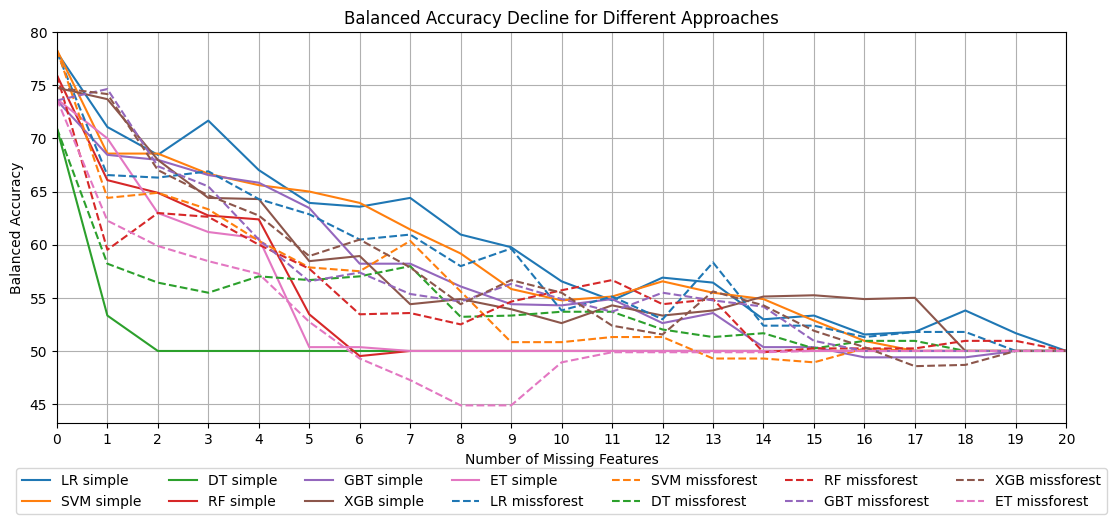

In [ ]:
# # Line plot for the balanced accuracy of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr2_perf['num_feat_missing'], lr2_perf['balanced_accuracy'], label='LR simple', color=colors[0])
plt.plot(svm2_perf['num_feat_missing'], svm2_perf['balanced_accuracy'], label='SVM simple', color=colors[1])
plt.plot(dt2_perf['num_feat_missing'], dt2_perf['balanced_accuracy'], label='DT simple', color=colors[2])
plt.plot(rf2_perf['num_feat_missing'], rf2_perf['balanced_accuracy'], label='RF simple', color=colors[3])
plt.plot(gbt2_perf['num_feat_missing'], gbt2_perf['balanced_accuracy'], label='GBT simple', color=colors[4])
plt.plot(xgb2_perf['num_feat_missing'], xgb2_perf['balanced_accuracy'], label='XGB simple', color=colors[5])
plt.plot(et2_perf['num_feat_missing'], et2_perf['balanced_accuracy'], label='ET simple', color=colors[6])

plt.plot(lr2_perf_mf['num_feat_missing'], lr2_perf_mf['balanced_accuracy'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm2_perf_mf['num_feat_missing'], svm2_perf_mf['balanced_accuracy'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt2_perf_mf['num_feat_missing'], dt2_perf_mf['balanced_accuracy'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf2_perf_mf['num_feat_missing'], rf2_perf_mf['balanced_accuracy'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt2_perf_mf['num_feat_missing'], gbt2_perf_mf['balanced_accuracy'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb2_perf_mf['num_feat_missing'], xgb2_perf_mf['balanced_accuracy'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et2_perf_mf['num_feat_missing'], et2_perf_mf['balanced_accuracy'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Decline for Different Approaches')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

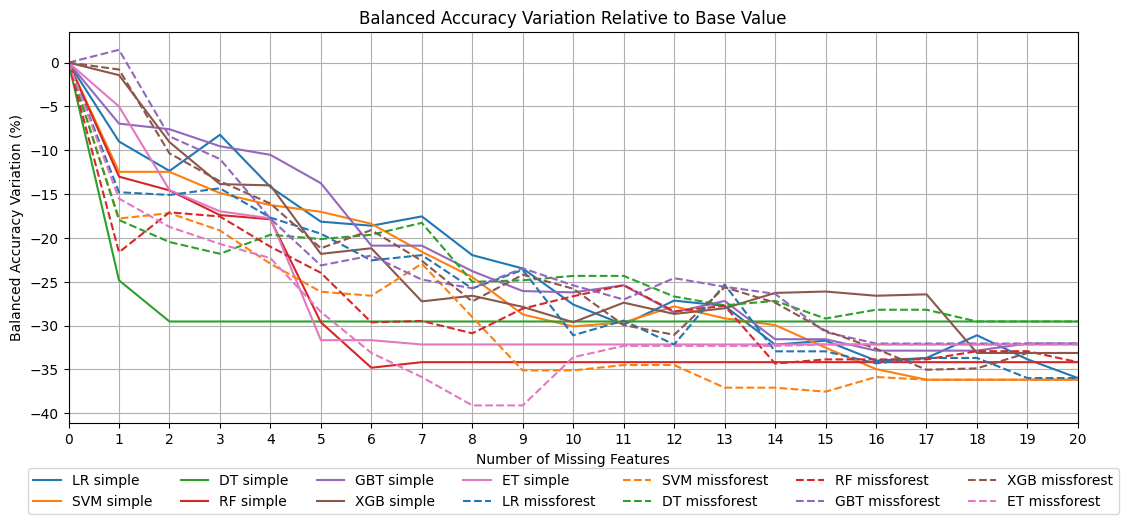

In [ ]:
# Line plot for the balanced accuracy variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the Balanced Accuracy variation for each model
for perf_df, label, color, linestyle in zip(
    [lr2_perf, svm2_perf, dt2_perf, rf2_perf, gbt2_perf, xgb2_perf, et2_perf,
     lr2_perf_mf, svm2_perf_mf, dt2_perf_mf, rf2_perf_mf, gbt2_perf_mf, xgb2_perf_mf, et2_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base Balanced Accuracy
    balanced_accy_variation = (perf_df['balanced_accuracy'] - perf_df['balanced_accuracy'].iloc[0]) / perf_df['balanced_accuracy'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], balanced_accy_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy Variation (%)')
plt.title('Balanced Accuracy Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In this dataset there are few highly correlated variables (even considerind the ohe). So the ensemble models like Random Forests and Extra Trees do not benefit from the power of backup variables because they actually do not exist.

From the analysis of F1 and Balanced Accuracy, Decision Trees and XGBoost seem to be the less resilient to features missing.

# **Save results**

In [ ]:
dataset_dict = {
    'lr_perf': lr_perf,
    'svm_perf': svm_perf,
    'dt_perf': dt_perf,
    'rf_perf': rf_perf,
    'gbt_perf': gbt_perf,
    'xgb_perf': xgb_perf,
    'et_perf': et_perf,
    'lr_perf_mf': lr_perf_mf,
    'svm_perf_mf': svm_perf_mf,
    'dt_perf_mf': dt_perf_mf,
    'rf_perf_mf': rf_perf_mf,
    'gbt_perf_mf': gbt_perf_mf,
    'xgb_perf_mf': xgb_perf_mf,
    'et_perf_mf': et_perf_mf,
    'lr2_perf': lr2_perf,
    'svm2_perf': svm2_perf,
    'dt2_perf': dt2_perf,
    'rf2_perf': rf2_perf,
    'gbt2_perf': gbt2_perf,
    'xgb2_perf': xgb2_perf,
    'et2_perf': et2_perf,
    'lr2_perf_mf': lr2_perf_mf,
    'svm2_perf_mf': svm2_perf_mf,
    'dt2_perf_mf': dt2_perf_mf,
    'rf2_perf_mf': rf2_perf_mf,
    'gbt2_perf_mf': gbt2_perf_mf,
    'xgb2_perf_mf': xgb2_perf_mf,
    'et2_perf_mf': et2_perf_mf,
}

all_data = combine_datasets(
    dataset_dict, 'German Credit', 'Scenario 1: standard', RANDOM_STATE
)
save_dataset(all_data, 'german_credit_scenario1_seed_2025.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
all_data

tp   tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0    50  102   38  10      56.82   83.33        72.86      76.0     67.57   
1    51   80   60   9      45.95   85.00        57.14      65.5     59.65   
2    50   75   65  10      43.48   83.33        53.57      62.5     57.14   
3    47   91   49  13      48.96   78.33        65.00      69.0     60.26   
4    50   71   69  10      42.02   83.33        50.71      60.5     55.87   
..   ..  ...  ...  ..        ...     ...          ...       ...       ...   
583  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
584  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
585  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
586  60    0  140   0      30.00  100.00         0.00      30.0     46.15   
587  60    0  140   0      30.00  100.00         0.00      30.0     46.15   

     balanced_accuracy  num_feat_missing  \
0                78.10                 0   
1                71.07                 1   
2                68.45                 2   
3                71.67                 3   
4                67.02                 4   
..                 ...               ...   
583              50.00                16   
584              50.00                17   
585              50.00                18   
586              50.00                19   
587              50.00                20   

                                               imputed      dataset  \
0                                                           lr_perf   
1    ['Status_of_existing_checking_account_greater ...      lr_perf   
2    ['Status_of_existing_checking_account_greater ...      lr_perf   
3    ['Status_of_existing_checking_account_greater ...      lr_perf   
4    ['Status_of_existing_checking_account_greater ...      lr_perf   
..                                                 ...          ...   
583  ['Status_of_existing_checking_account_greater ...  et2_perf_mf   
584  ['Status_of_existing_checking_account_greater ...  et2_perf_mf   
585  ['Status_of_existing_checking_account_greater ...  et2_perf_mf   
586  ['Status_of_existing_checking_account_greater ...  et2_perf_mf   
587  ['Status_of_existing_checking_account_greater ...  et2_perf_mf   

            source              scenario  random_state             metric  
0    German Credit  Scenario 1: standard          2025           f1 score  
1    German Credit  Scenario 1: standard          2025           f1 score  
2    German Credit  Scenario 1: standard          2025           f1 score  
3    German Credit  Scenario 1: standard          2025           f1 score  
4    German Credit  Scenario 1: standard          2025           f1 score  
..             ...                   ...           ...                ...  
583  German Credit  Scenario 1: standard          2025  balanced accuracy  
584  German Credit  Scenario 1: standard          2025  balanced accuracy  
585  German Credit  Scenario 1: standard          2025  balanced accuracy  
586  German Credit  Scenario 1: standard          2025  balanced accuracy  
587  German Credit  Scenario 1: standard          2025  balanced accuracy  

[588 rows x 17 columns]